# Sumo Run

## Moveto

In [1]:
import os, sys, socket, re, json, random
import numpy as np
#import torch
#import torch.nn as nn

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj loading ########################
duration   = 2000
m2m        = 1/2.23694
Leader_old = np.loadtxt('Old_leader_0.02.txt', delimiter='\t') # (33000, 3) (time, (position, speed, acc))
Leader_new = np.loadtxt('New_leader_0.02.txt', delimiter='\t')
fre        = 0.02
Run_len    = int(60/fre)
Time_len   = 11*Run_len    
########################## Function ##########################
def EIDM(spacing, v, *cv_arg, v0 = 30, s0=2, a0=0.8, b0=1.5, T=1.2, sigma=4, Kf=0.85, Kg=0.6,):
    cv_arg         = cv_arg[0]
    CAV_count      = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta    = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i]  = 0.3/(0.3+np.exp(i))
            temp_v  += alpha[i]*cv_arg[2*i]
            temp_a  += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int  = -a0*(s_star/spacing)**2
    acc    = a_free + a_int
    
    output = Kf*acc + Kg*(temp_v + temp_a)
    if output < -8:
        output = -8
    return output

v0=30; T0=1.2; s0=2; a0=0.8; b0=1.5; sigma=4; Kf=0.85; Kg=0.6
'''
class IDM(nn.Module):
    def __init__(self, 
        speed_desire, 
        time_gap, 
        acc_max, 
        dec_desire, 
        distance_jam
        ):
        super(IDM, self).__init__()  
        self.v_0 = speed_desire
        self.T   = time_gap
        self.a   = acc_max
        self.b   = dec_desire
        self.s_0 = distance_jam
        
    def forward(self, v_i, v_delta, s_i):
        s_temp = self.s_0 + v_i * self.T + v_i * v_delta / (2 * ((self.a * self.b)**0.5))
        output = self.a * (1 - (v_i / self.v_0)**4 - (s_temp / s_i)**2) 
        return output
'''
veh_len  = 5
lane_wid = 3.65
v0       = 30    

########################## Preliminaries ##########################
para_IDM  = [1.6, 0.73, 1.67]
T0        = np.random.normal(para_IDM[0], 0)#0.2)
a0        = np.random.normal(para_IDM[1], 0)#0.08)
b0        = np.random.normal(para_IDM[2], 0)#0.08)
s0        = np.random.normal(2, 0)#0.5)
#IDM_model = IDM(v0, T0, a0, b0, s0)

N_group     = 12
N_veh       = 5
N_veh_total = 55  
# gourp 0: 0 - 4
# group 1: 5 - 9
# group 2: 10 - 14
Dat = np.zeros((Time_len, N_group, N_veh, 3)) 
Dat_record = Dat.copy()
# Time_len: 33000
# N_group : 0 - old_leader platoon; 1-10 - new-leader platoon; 11 - non-sense
# N_veh   : 0 - leader; 1 - vehicle being but-in; >=2 -followers
# features: 0 - position; 1 - speed; 2 - acc
Dat_ego = np.zeros((Time_len, 6))
# longitudinal: 0 - position; 1 - speed; 2 - acc
# lateral     : 3 - position; 4 - speed; 5 - acc

Dat[:,0,0,1:3] = Leader_old[:,1:3]         # speed, acc

for i in range(1, N_group):
    if i == 1:
        Dat[:,i,0, 1:3] = Leader_new[:,1:3] # speed, acc
    else:
        Dat[(i-1)*Run_len:,i,0, 1:3] = Leader_new[0:-(i-1)*Run_len,1:3] # speed, acc

dis_0            = 91               # Spacing between two leaders
spacing_ego_0    = 75               # Spacing between the original leader and the ego vehicle
spacing_target_0 = 50               # Spacing between vehicles

Lane_ego     = 0                    # Ego vehicle start from Lane 0
Lane_target  = 1 
LC_direction = +1                   # left lane change
LC_do        = [0]*11               # Indication of lane change complete
# 1: 0->1; 1->2
#-1: 2->1; 1->0

############################## SUMO ############################################
#graph = sumolib.net.readNet('90_new_no.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
#vertex = graph.getNodes()
#edge = graph.getEdges(withInternal=True)

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(Leader_old[0,1]), departLane = str(0), typeID="vtypeauto")
traci.vehicle.setColor('ego', color=(0, 255, 0))
traci.vehicle.setLaneChangeMode('ego', 256)
traci.gui.track('ego')                    # Track the ego vehicle
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))
#traci.vehicle.getLanePosition("%d" % i)
#traci.vehicle.getSpeed("%d" % i)
#traci.vehicle.getAcceleration("%d" % i)
#traci.vehicle.getLaneIndex(self, vehID)
#traci.vehicle.getLateralLanePosition
#traci.vehicle.getLateralSpeed(self, vehID)
#traci.vehicle.changeLane(self, vehID, laneIndex, duration)
#traci.vehicle.changeLaneRelative(self, vehID, indexOffset, duration)





############################## Data transmission ############################################

#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))



data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]
y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 814.42, 0.55  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
traci.vehicle.setSpeed('ego', 0.0)

##################################### Run ########################################

traci.simulationStep()
step     = 0
max_iter = Time_len
fre        = 1/60#0.02
while step < max_iter-1:
    
    ############################ Read ego vehicle information ######################
    
    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    #print(data)
    y, x, z, vy, vx = data.split(";")
    #x, y = '6448.97', '-6645.57'
    
    #print(step, y)
    
    X_offset, Y_offset = 814.42, 0.55  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    #print(x,y)
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    traci.vehicle.setSpeed('ego', vy)
    eLanePos = traci.vehicle.getLanePosition('ego')
    # traci.vehicle.getLateralLanePosition('ego')
    #print(eLanePos)
    #print(x, y)
    #print(traci.vehicle.getPosition('ego'))
    

    ############################# Initialization ##########################
    if step==0:
        # ego vehicle
        eLanePos = traci.vehicle.getLanePosition('ego')
        Dat_ego[step,0] = eLanePos
        Dat_ego[step,1] = vy
        Dat_ego[step,2] = 0    
        Dat_ego[step,3] = lane_wid * (traci.vehicle.getLaneIndex('ego')+0.5) + traci.vehicle.getLateralLanePosition('ego') 
        Dat_ego[step,4] = vx
        Dat_ego[step,5] = 0
        #traci.vehicle.moveTo('ego', traci.vehicle.getLaneID('ego'), Dat_ego[step,0])
    
        # ego platoon
        Lane_ego     = traci.vehicle.getLaneIndex('ego')              # lane index for the ego platoon
        Lane_target  = 1                                              # Lane index for the target platoon
        LC_direction = Lane_target - Lane_ego                         # lane-change direction
        
        Lane_ego_last     = Lane_ego                                  # Saved as backup
        Lane_target_last  = Lane_target
        LC_direction_last = LC_direction
        
        idx_group_ego     = 0                                         # Idx of the platoon
        # The leader
        Dat[step,idx_group_ego,0,0] = eLanePos + spacing_ego_0        # Initial position of the original leader related to ego
        pos_tmp, speed_tmp, acc_tmp = Dat[step,idx_group_ego,0]       # Read information
        # Add vehicle
        vid = "%d" % 0                                                # Vehicle ID
        traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_ego), typeID="vtypeauto")
        traci.vehicle.setColor(vid, (255, 0, 0))
        traci.vehicle.setLaneChangeMode(vid, 256)
        traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_ego), pos_tmp)
        Dat_record[step,idx_group_ego,0, 0] = traci.vehicle.getLanePosition(vid)
        Dat_record[step,idx_group_ego,0, 1] = speed_tmp
        Dat_record[step,idx_group_ego,0, 2] = acc_tmp

        # The follower
        for i in range(1, N_veh):
            Dat[step,idx_group_ego,i,0] = eLanePos - spacing_target_0 * i # Position
            Dat[step,idx_group_ego,i,1] = Dat[step,idx_group_ego,0,1]     # Speed
            Dat[step,idx_group_ego,i,2] = 0                               # Acc
            pos_tmp, speed_tmp, acc_tmp = Dat[step,idx_group_ego,i]       # Read information
            # Add vehicle
            vid = "%d" % (idx_group_ego * N_veh + i)                      # Vehicle ID
            traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_ego), typeID="vtypeauto")
            traci.vehicle.setColor(vid, (0, 0, 255))
            traci.vehicle.setLaneChangeMode(vid, 256)
            traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_ego), pos_tmp)
            Dat_record[step,idx_group_ego,i, 0] = traci.vehicle.getLanePosition(vid)
            Dat_record[step,idx_group_ego,i, 1] = speed_tmp
            Dat_record[step,idx_group_ego,i, 2] = acc_tmp
            
        
        # target platoon
        idx_group_target = 1                                              # Index for the target platoo
        
        Dat[step,idx_group_target,0,0] = eLanePos - dis_0 + spacing_ego_0 # Initial position related to ego
        pos_tmp, speed_tmp, acc_tmp    = Dat[step,idx_group_target,0]     # Read information
        # Add vehicle
        vid = "%d" % (idx_group_target * N_veh)                           # Vehicle ID          
        traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_target), typeID="vtypeauto")
        traci.vehicle.setColor(vid, (255, 0, 0))
        traci.vehicle.setLaneChangeMode(vid, 256)
        traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_target), pos_tmp)
        Dat_record[step,idx_group_target,0, 0] = traci.vehicle.getLanePosition(vid)
        Dat_record[step,idx_group_target,0, 1] = speed_tmp
        Dat_record[step,idx_group_target,0, 2] = acc_tmp
        
        for i in range(1, N_veh):
            Dat[step,idx_group_target,i,0] = Dat[step,idx_group_target,0,0] - spacing_target_0 * i
            Dat[step,idx_group_target,i,1] = Dat[step,idx_group_target,0,1]
            Dat[step,idx_group_target,i,2] = 0
            pos_tmp, speed_tmp, acc_tmp    = Dat[step,idx_group_target,i]  # Read information
            # Add vehicle
            vid = "%d" % (idx_group_target * N_veh + i)                    # Vehicle ID
            traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_target), typeID="vtypeauto")
            traci.vehicle.setColor(vid, (0, 0, 255))
            traci.vehicle.setLaneChangeMode(vid, 256)
            traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_target), pos_tmp)
            Dat_record[step,idx_group_target,i, 0] = traci.vehicle.getLanePosition(vid)
            Dat_record[step,idx_group_target,i, 1] = speed_tmp
            Dat_record[step,idx_group_target,i, 2] = acc_tmp


    
    ############################# Add platoon  ##########################
    elif step % Run_len == 0 and step != max_iter - 1:  
        # Lane-change direction
        Lane_ego = traci.vehicle.getLaneIndex('ego')       # Lane index of the ego vehicle
        if Lane_ego == 0 or Lane_ego == 2:
            Lane_target = 1
        elif Lane_ego == 1:
            Lane_target = Lane_ego + LC_direction_last
        LC_direction = Lane_target - Lane_ego       
        print(LC_direction)
        
        if Lane_ego != Lane_ego_last:                      # Did change lane
            # Remove vehicles
            idx_group_remove = idx_group_ego               # Remove old platoon
            idx_group_ego = int (step  / Run_len)     # New platoon become the ego platoon
        else:                                              # No lane change
            # Remove vehicles
            idx_group_remove = int (step / Run_len)  # Remove the new platoon
        # Remove vehicles
        for i in range(N_veh):
            vid = "%d" % (idx_group_remove * N_veh + i)
            traci.vehicle.remove(vid)
        
        Lane_ego_last     = Lane_ego
        Lane_target_last  = Lane_target
        LC_direction_last = LC_direction 
        
        # Add new platoon
        idx_group_target  = int (step / Run_len) + 1  # Index of the new platoon
        
        # The leader
        #ego_leader_pos                 = traci.vehicle.getLanePosition("%d" % (idx_group_ego * N_veh))
        ego_leader_pos                 = traci.vehicle.getLanePosition('ego')
        Dat[step,idx_group_target,0,0] = ego_leader_pos - dis_0 + spacing_ego_0 # Postion related to ego
        pos_tmp, _, _                  = Dat[step,idx_group_target,0]        # Speed
        _, speed_tmp, acc_tmp          = Dat[step + 1,idx_group_target,0]    # Acc      
        # Add vehicle
        vid = "%d" % (idx_group_target * N_veh)              # Vehicle ID
        traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_target), typeID="vtypeauto")
        traci.vehicle.setColor(vid, (255, 0, 0))
        traci.vehicle.setLaneChangeMode(vid, 256)
        traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_target), pos_tmp)
        Dat_record[step,idx_group_target,0, 0] = traci.vehicle.getLanePosition(vid)
        Dat_record[step,idx_group_target,0, 1] = speed_tmp
        Dat_record[step,idx_group_target,0, 2] = acc_tmp
        
        # The followers
        for i in range(1, N_veh):
            Dat[step,idx_group_target,i,0] = Dat[step,idx_group_target,0,0] -spacing_target_0 * i
            Dat[step,idx_group_target,i,1] = Dat[step + 1,idx_group_target,0,1]
            Dat[step,idx_group_target,i,2] = 0
            pos_tmp, speed_tmp, acc_tmp    = Dat[step,idx_group_target,i]
            # Add vehicle
            vid = "%d" % (idx_group_target * N_veh + i)                         # Vehicle ID
            traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_target), typeID="vtypeauto")
            traci.vehicle.setColor(vid, (0, 0, 255))
            traci.vehicle.setLaneChangeMode(vid, 256)
            traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_target), pos_tmp)
            Dat_record[step,idx_group_target,i, 0] = traci.vehicle.getLanePosition(vid)
            Dat_record[step,idx_group_target,i, 1] = speed_tmp
            Dat_record[step,idx_group_target,i, 2] = acc_tmp

    ############################ Leaders #############################
    if step != 0:
        # ego platoon information
        # the leader
        vid = "%d" % (idx_group_ego * N_veh)
        Dat[step,idx_group_ego,0,0] = Dat[step-1,idx_group_ego,0,0] + Dat[step,idx_group_ego,0,1] * fre
        traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_ego), Dat[step,idx_group_ego,0,0])
        Dat_record[step,idx_group_ego,0, 0] = traci.vehicle.getLanePosition(vid)
        Dat_record[step,idx_group_ego,0, 1] = (Dat_record[step,idx_group_ego,0, 0] - Dat_record[step-1,idx_group_ego,0, 0])/fre
        Dat_record[step,idx_group_ego,0, 2] = (Dat_record[step,idx_group_ego,0, 1] - Dat_record[step-1,idx_group_ego,0, 1])/fre
        
        if step % Run_len != 0:
            # target platoon
            # the leader
            vid = "%d" % (idx_group_target * N_veh)
            Dat[step,idx_group_target,0,0] = Dat[step-1,idx_group_target,0,0] + Dat[step,idx_group_target,0,1] * fre
            traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_target), Dat[step,idx_group_target,0,0])
            Dat_record[step,idx_group_target,0, 0] = traci.vehicle.getLanePosition(vid)
            Dat_record[step,idx_group_target,0, 1] = (Dat_record[step,idx_group_target,0, 0] - Dat_record[step-1,idx_group_target,0, 0])/fre
            Dat_record[step,idx_group_target,0, 2] = (Dat_record[step,idx_group_target,0, 1] - Dat_record[step-1,idx_group_target,0, 1])/fre
        


    ############################# Ego vehicle ##########################
    if step != 0:
        # Information for the ego vehicle
        Dat_ego[step,0] = traci.vehicle.getLanePosition('ego')
        Dat_ego[step,1] = vy
        Dat_ego[step,2] = (Dat_ego[step,1] - Dat_ego[step-1,1])/fre
        
        Dat_ego[step,3] = lane_wid * (traci.vehicle.getLaneIndex('ego')+0.5) + traci.vehicle.getLateralLanePosition('ego') 
        Dat_ego[step,4] = vx
        Dat_ego[step,5] = (Dat_ego[step,4] - Dat_ego[step-1,4])/fre
        '''
        # The preceding vheicle information
        if step == 0:
            Leader = 0
        else:
            Leader = int(traci.vehicle.getLeader('ego')[0])

        idx_veh_tmp                 = Leader % N_veh                         # Vehicle index
        idx_group_tmp               = int(Leader/N_veh)                      # Platoon index
        pos_tmp, speed_tmp, acc_tmp = Dat_ego[step-1,0:3]                      # Read information of the ego vehicle
        pos_pre, speed_pre, acc_pre = Dat[step-1,idx_group_tmp,idx_veh_tmp]    # Read information of the target vehicle
        # EIDM
        space    = pos_pre - pos_tmp - veh_len
        v        = speed_tmp
        rel_v    = speed_pre - speed_tmp
        rel_acc  = acc_pre - acc_tmp
        acc_next = EIDM(space, v, (rel_v,rel_acc))

        # IDM
        #v        = speed_tmp
        #v_delt   = speed_tmp - speed_pre
        #spacing  = pos_pre - pos_tmp - veh_len
        #acc_next = IDM_model(v, v_delt, spacing)    

        Dat_ego[step,2] = acc_next
        Dat_ego[step,1] =  Dat_ego[step-1,1] +  Dat_ego[step,2] * fre
        Dat_ego[step,0] =  Dat_ego[step-1,0] +  Dat_ego[step,1] * fre

        traci.vehicle.moveTo('ego', traci.vehicle.getLaneID('ego'), Dat_ego[step,0])

        #print(step, Leader, acc_next, traci.vehicle.getLaneIndex('ego')==Lane_target)

        # Lane-change decision-making
        if (step + 1) % Run_len > (20/fre) and step != max_iter - 1:              # Time step
            if LC_direction   == 1:                                               # Lane change direction
                if len(traci.vehicle.getLeftLeaders('ego'))!=0:                   # Exist preceding vehicle
                    if int(traci.vehicle.getLeftLeaders('ego')[0][0]) == idx_group_target * N_veh and LC_do[int((step + 1) / Run_len)]  == 0:                    # No lane change within this 60s
                        if Dat[step,idx_group_target,0,0] - pos_tmp >= 7.0 and pos_tmp - Dat[step,idx_group_target,1,0]>= 7.0:
                            traci.vehicle.changeLaneRelative('ego', LC_direction, 5)  # Change lane with relative direction
                            LC_do[int((step + 1) / Run_len)] = 1                      # Mark lane change
            elif LC_direction == -1:
                if len(traci.vehicle.getRightLeaders('ego'))!=0:
                    if int(traci.vehicle.getRightLeaders('ego')[0][0]) == idx_group_target * N_veh and LC_do[int((step + 1) / Run_len)]  == 0:
                        if Dat[step,idx_group_target,0,0] - pos_tmp >= 7.0 and pos_tmp - Dat[step,idx_group_target,1,0]>= 7.0:
                            traci.vehicle.changeLaneRelative('ego', LC_direction, 5)
                            LC_do[int((step + 1) / Run_len)] = 1
    
        '''

    ############################# Followers ##########################
    if step != 0:

        # The follower
        for i in range(1, N_veh):
            vid = "%d" % (idx_group_ego * N_veh + i)
            # Read information
            pos_tmp, speed_tmp, acc_tmp = Dat[step-1,idx_group_ego,i]
            pos_pre, speed_pre, acc_pre = Dat[step-1,idx_group_ego,i-1]
            if i == 1 and step != 0 and step % Run_len != 0:
                if traci.vehicle.getLeader(vid)[0]=='ego':
                    pos_pre, speed_pre, acc_pre = Dat_ego[step-1,0:3]
            # EIDM
            space    = pos_pre - pos_tmp - veh_len
            v        = speed_tmp
            rel_v    = speed_pre - speed_tmp
            rel_acc  = acc_pre - acc_tmp
            acc_next = EIDM(space, v, (rel_v,rel_acc))

            # IDM
            #v        = speed_tmp
            #v_delt   = speed_tmp - speed_pre
            #spacing  = pos_pre - pos_tmp - veh_len
            #acc_next = IDM_model(v, v_delt, spacing)    

            Dat[step,idx_group_ego,i,2] = acc_next
            Dat[step,idx_group_ego,i,1] = Dat[step-1,idx_group_ego,i,1] + Dat[step,idx_group_ego,i,2] * fre
            Dat[step,idx_group_ego,i,0] = Dat[step-1,idx_group_ego,i,0] + Dat[step,idx_group_ego,i,1] * fre
            traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_ego), Dat[step,idx_group_ego,i,0])
            Dat_record[step,idx_group_ego,i, 0] = traci.vehicle.getLanePosition(vid)
            Dat_record[step,idx_group_ego,i, 1] = (Dat_record[step,idx_group_ego,i, 0] - Dat_record[step-1,idx_group_ego,i, 0])/fre
            Dat_record[step,idx_group_ego,i, 2] = (Dat_record[step,idx_group_ego,i, 1] - Dat_record[step-1,idx_group_ego,i, 1])/fre
        

        if step % Run_len != 0:
            # target platoon
            # the followers
            for i in range(1, N_veh):
                vid = "%d" % (idx_group_target * N_veh + i)
                # read information
                pos_tmp, speed_tmp, acc_tmp = Dat[step-1,idx_group_target,i]
                pos_pre, speed_pre, acc_pre = Dat[step-1,idx_group_target,i-1]
                if i == 1 and step != 0 and step % Run_len != 0:
                    if traci.vehicle.getLeader(vid)[0]=='ego':
                        pos_pre, speed_pre, acc_pre = Dat_ego[step-1,0:3]
                # EIDM
                space    = pos_pre - pos_tmp - veh_len
                v        = speed_tmp
                rel_v    = speed_pre - speed_tmp
                rel_acc  = acc_pre - acc_tmp
                acc_next = EIDM(space, v, (rel_v,rel_acc))

                # IDM
                #v        = speed_tmp
                #v_delt   = speed_tmp - speed_pre
                #spacing  = pos_pre - pos_tmp - veh_len
                #acc_next = IDM_model(v, v_delt, spacing)   

                Dat[step,idx_group_target,i,2] = acc_next
                Dat[step,idx_group_target,i,1] = Dat[step-1,idx_group_target,i,1] + Dat[step,idx_group_target,i,2] * fre
                Dat[step,idx_group_target,i,0] = Dat[step-1,idx_group_target,i,0] + Dat[step,idx_group_target,i,1] * fre
                traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_target), Dat[step,idx_group_target,i,0])
                Dat_record[step,idx_group_target,i, 0] = traci.vehicle.getLanePosition(vid)
                Dat_record[step,idx_group_target,i, 1] = (Dat_record[step,idx_group_target,i, 0] - Dat_record[step-1,idx_group_target,i, 0])/fre
                Dat_record[step,idx_group_target,i, 2] = (Dat_record[step,idx_group_target,i, 1] - Dat_record[step-1,idx_group_target,i, 1])/fre

                
                
    ############################# Message transmission ##########################
    Message =''
    Message =  "0" + "," + "0" + "," + str(step)+ "," + Message

    for i in range(0, N_veh):       
        vid = "%d" % (idx_group_ego * N_veh + i)
        Message += vid + ',' 

        Position = traci.vehicle.getPosition(vid)
        vel = "{0:.3f}".format(Dat[step,idx_group_ego,i,1])
        acc = Dat[step,idx_group_ego,i,2]

        xx = "{0:.3f}".format(Position[0]-X_offset) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 
        Message += xx + "," + yy +","

        angle = traci.vehicle.getAngle('ego')
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","

        if acc < -0.1:
            sig = 3
        else:
            sig = 0
        Message +=  str(sig) + "," + str(vel) + ","   
        
    PRINT = []
    for i in range(0, N_veh):
        vid = "%d" % (idx_group_target * N_veh + i)
        Message += vid + ',' 

        Position = traci.vehicle.getPosition(vid)
        vel = "{0:.3f}".format(Dat[step,idx_group_target,i,1])
        acc = Dat[step,idx_group_target,i,2]

        xx = "{0:.3f}".format(Position[0]-X_offset) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 
        Message += xx + "," + yy +","

        PRINT.append(yy)
        
        angle = traci.vehicle.getAngle('ego')
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","

        if acc < -0.1:
            sig = 3
        else:
            sig = 0
        Message +=  str(sig) + "," + str(vel) + ","  
        
    
    print(step, PRINT)    
    Message = Message[:-1]
    #print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))
    
    #print(Message)
    # Save the Dat
    if step == max_iter-2:
        print(Dat.shape)
        np.savetxt('Result/Data_EIDM_record.txt',Dat_record.reshape(-1,3),fmt = '%.15f', delimiter='\t', newline='\n')
        np.savetxt('Result/Data_EIDM.txt',Dat.reshape(-1,3),fmt = '%.15f', delimiter='\t', newline='\n')
        np.savetxt('Result/Data_ego_EIDM.txt',Dat_ego, fmt = '%.15f', delimiter='\t', newline='\n')
    
    step += 1
    
    traci.simulationStep()
    if step > max_iter:
        break

traci.close()

0 ['7958.292', '7908.292', '7858.292', '7808.292', '7758.292']
1 ['7958.728', '7908.728', '7858.728', '7808.728', '7758.728']
2 ['7959.164', '7909.164', '7859.164', '7809.164', '7759.164']
3 ['7959.600', '7909.599', '7859.599', '7809.599', '7759.599']
4 ['7960.035', '7910.035', '7860.035', '7810.035', '7760.035']
5 ['7960.471', '7910.471', '7860.471', '7810.471', '7760.471']
6 ['7960.907', '7910.907', '7860.907', '7810.906', '7760.906']
7 ['7961.343', '7911.342', '7861.342', '7811.342', '7761.342']
8 ['7961.779', '7911.778', '7861.778', '7811.778', '7761.778']
9 ['7962.214', '7912.214', '7862.213', '7812.213', '7762.213']
10 ['7962.650', '7912.649', '7862.649', '7812.649', '7762.649']
11 ['7963.086', '7913.085', '7863.085', '7813.085', '7763.085']
12 ['7963.522', '7913.520', '7863.520', '7813.520', '7763.520']
13 ['7963.957', '7913.956', '7863.956', '7813.956', '7763.956']
14 ['7964.393', '7914.391', '7864.391', '7814.391', '7764.391']
15 ['7964.829', '7914.827', '7864.827', '7814.827'

137 ['8017.648', '7967.754', '7917.779', '7867.786', '7817.787']
138 ['8018.078', '7968.186', '7918.212', '7868.218', '7818.220']
139 ['8018.509', '7968.618', '7918.644', '7868.651', '7818.653']
140 ['8018.939', '7969.050', '7919.077', '7869.084', '7819.086']
141 ['8019.370', '7969.482', '7919.509', '7869.517', '7819.518']
142 ['8019.800', '7969.914', '7919.942', '7869.949', '7819.951']
143 ['8020.231', '7970.346', '7920.374', '7870.382', '7820.384']
144 ['8020.661', '7970.777', '7920.807', '7870.815', '7820.816']
145 ['8021.091', '7971.209', '7921.239', '7871.247', '7821.249']
146 ['8021.522', '7971.641', '7921.672', '7871.680', '7821.682']
147 ['8021.952', '7972.073', '7922.104', '7872.112', '7822.114']
148 ['8022.382', '7972.505', '7922.536', '7872.545', '7822.547']
149 ['8022.813', '7972.936', '7922.969', '7872.977', '7822.979']
150 ['8023.243', '7973.368', '7923.401', '7873.410', '7823.412']
151 ['8023.673', '7973.800', '7923.833', '7873.842', '7823.845']
152 ['8024.103', '7974.23

265 ['8072.582', '8022.844', '7972.961', '7923.010', '7873.028']
266 ['8073.011', '8023.273', '7973.391', '7923.440', '7873.458']
267 ['8073.440', '8023.702', '7973.820', '7923.870', '7873.888']
268 ['8073.868', '8024.131', '7974.250', '7924.300', '7874.319']
269 ['8074.297', '8024.560', '7974.679', '7924.730', '7874.749']
270 ['8074.726', '8024.989', '7975.109', '7925.160', '7875.179']
271 ['8075.155', '8025.418', '7975.539', '7925.590', '7875.610']
272 ['8075.585', '8025.847', '7975.968', '7926.020', '7876.040']
273 ['8076.014', '8026.276', '7976.398', '7926.450', '7876.470']
274 ['8076.443', '8026.705', '7976.827', '7926.880', '7876.900']
275 ['8076.872', '8027.134', '7977.257', '7927.310', '7877.330']
276 ['8077.302', '8027.563', '7977.686', '7927.740', '7877.761']
277 ['8077.731', '8027.992', '7978.116', '7928.170', '7878.191']
278 ['8078.161', '8028.421', '7978.545', '7928.600', '7878.621']
279 ['8078.591', '8028.849', '7978.975', '7929.030', '7879.051']
280 ['8079.021', '8029.27

392 ['8127.649', '8077.418', '8027.445', '7977.507', '7927.549']
393 ['8128.083', '8077.849', '8027.874', '7977.935', '7927.977']
394 ['8128.518', '8078.279', '8028.303', '7978.363', '7928.406']
395 ['8128.952', '8078.710', '8028.731', '7978.792', '7928.834']
396 ['8129.387', '8079.141', '8029.160', '7979.220', '7929.262']
397 ['8129.821', '8079.571', '8029.589', '7979.648', '7929.690']
398 ['8130.256', '8080.002', '8030.018', '7980.076', '7930.119']
399 ['8130.690', '8080.433', '8030.446', '7980.505', '7930.547']
400 ['8131.124', '8080.863', '8030.875', '7980.933', '7930.975']
401 ['8131.559', '8081.294', '8031.304', '7981.361', '7931.403']
402 ['8131.993', '8081.725', '8031.732', '7981.789', '7931.832']
403 ['8132.427', '8082.155', '8032.161', '7982.217', '7932.260']
404 ['8132.861', '8082.586', '8032.590', '7982.646', '7932.688']
405 ['8133.295', '8083.017', '8033.019', '7983.074', '7933.116']
406 ['8133.729', '8083.447', '8033.447', '7983.502', '7933.544']
407 ['8134.163', '8083.87

528 ['8186.570', '8135.999', '8085.752', '8035.690', '7985.698']
529 ['8187.001', '8136.429', '8086.181', '8036.118', '7986.125']
530 ['8187.431', '8136.860', '8086.609', '8036.545', '7986.552']
531 ['8187.861', '8137.290', '8087.038', '8036.973', '7986.979']
532 ['8188.292', '8137.720', '8087.467', '8037.400', '7987.406']
533 ['8188.722', '8138.151', '8087.895', '8037.827', '7987.833']
534 ['8189.152', '8138.581', '8088.324', '8038.255', '7988.259']
535 ['8189.582', '8139.011', '8088.753', '8038.682', '7988.686']
536 ['8190.012', '8139.441', '8089.181', '8039.110', '7989.113']
537 ['8190.442', '8139.872', '8089.610', '8039.537', '7989.540']
538 ['8190.872', '8140.302', '8090.038', '8039.965', '7989.967']
539 ['8191.302', '8140.732', '8090.467', '8040.392', '7990.394']
540 ['8191.732', '8141.162', '8090.896', '8040.820', '7990.821']
541 ['8192.162', '8141.592', '8091.324', '8041.247', '7991.248']
542 ['8192.592', '8142.022', '8091.753', '8041.674', '7991.674']
543 ['8193.022', '8142.45

664 ['8244.932', '8194.390', '8144.000', '8093.788', '8043.702']
665 ['8245.362', '8194.819', '8144.428', '8094.215', '8044.128']
666 ['8245.791', '8195.247', '8144.855', '8094.642', '8044.554']
667 ['8246.221', '8195.676', '8145.283', '8095.069', '8044.980']
668 ['8246.650', '8196.104', '8145.711', '8095.495', '8045.406']
669 ['8247.080', '8196.533', '8146.139', '8095.922', '8045.832']
670 ['8247.510', '8196.962', '8146.567', '8096.349', '8046.258']
671 ['8247.939', '8197.390', '8146.995', '8096.776', '8046.685']
672 ['8248.369', '8197.819', '8147.422', '8097.203', '8047.111']
673 ['8248.799', '8198.247', '8147.850', '8097.630', '8047.537']
674 ['8249.229', '8198.676', '8148.278', '8098.057', '8047.963']
675 ['8249.658', '8199.105', '8148.706', '8098.483', '8048.389']
676 ['8250.088', '8199.533', '8149.134', '8098.910', '8048.815']
677 ['8250.518', '8199.962', '8149.561', '8099.337', '8049.241']
678 ['8250.948', '8200.390', '8149.989', '8099.764', '8049.667']
679 ['8251.378', '8200.81

800 ['8303.239', '8252.647', '8202.146', '8151.808', '8101.614']
801 ['8303.662', '8253.074', '8202.573', '8152.235', '8102.039']
802 ['8304.084', '8253.501', '8203.000', '8152.661', '8102.465']
803 ['8304.507', '8253.928', '8203.427', '8153.087', '8102.891']
804 ['8304.929', '8254.355', '8203.854', '8153.514', '8103.316']
805 ['8305.351', '8254.781', '8204.281', '8153.940', '8103.742']
806 ['8305.772', '8255.208', '8204.708', '8154.366', '8104.167']
807 ['8306.194', '8255.635', '8205.135', '8154.793', '8104.593']
808 ['8306.616', '8256.061', '8205.562', '8155.219', '8105.018']
809 ['8307.037', '8256.488', '8205.989', '8155.645', '8105.444']
810 ['8307.458', '8256.914', '8206.416', '8156.072', '8105.869']
811 ['8307.879', '8257.340', '8206.843', '8156.498', '8106.295']
812 ['8308.300', '8257.767', '8207.270', '8156.924', '8106.720']
813 ['8308.721', '8258.193', '8207.696', '8157.350', '8107.146']
814 ['8309.142', '8258.619', '8208.123', '8157.777', '8107.571']
815 ['8309.563', '8259.04

936 ['8359.817', '8310.185', '8260.004', '8209.700', '8159.442']
937 ['8360.231', '8310.605', '8260.427', '8210.124', '8159.867']
938 ['8360.645', '8311.024', '8260.850', '8210.549', '8160.292']
939 ['8361.059', '8311.444', '8261.274', '8210.974', '8160.717']
940 ['8361.474', '8311.863', '8261.697', '8211.398', '8161.141']
941 ['8361.888', '8312.283', '8262.120', '8211.823', '8161.566']
942 ['8362.302', '8312.702', '8262.543', '8212.248', '8161.991']
943 ['8362.717', '8313.122', '8262.966', '8212.672', '8162.416']
944 ['8363.131', '8313.541', '8263.390', '8213.097', '8162.840']
945 ['8363.546', '8313.961', '8263.813', '8213.521', '8163.265']
946 ['8363.960', '8314.380', '8264.236', '8213.946', '8163.690']
947 ['8364.375', '8314.799', '8264.659', '8214.370', '8164.114']
948 ['8364.789', '8315.219', '8265.082', '8214.795', '8164.539']
949 ['8365.204', '8315.638', '8265.505', '8215.219', '8164.963']
950 ['8365.619', '8316.057', '8265.928', '8215.644', '8165.388']
951 ['8366.033', '8316.47

1071 ['8415.826', '8366.638', '8316.911', '8266.863', '8216.686']
1072 ['8416.238', '8367.055', '8317.331', '8267.285', '8217.109']
1073 ['8416.650', '8367.471', '8317.750', '8267.707', '8217.533']
1074 ['8417.063', '8367.887', '8318.170', '8268.129', '8217.956']
1075 ['8417.475', '8368.304', '8318.590', '8268.551', '8218.379']
1076 ['8417.888', '8368.720', '8319.010', '8268.973', '8218.802']
1077 ['8418.301', '8369.137', '8319.429', '8269.395', '8219.225']
1078 ['8418.714', '8369.553', '8319.849', '8269.817', '8219.648']
1079 ['8419.127', '8369.970', '8320.269', '8270.239', '8220.071']
1080 ['8419.541', '8370.386', '8320.688', '8270.661', '8220.494']
1081 ['8419.954', '8370.803', '8321.108', '8271.083', '8220.918']
1082 ['8420.368', '8371.219', '8321.527', '8271.505', '8221.341']
1083 ['8420.782', '8371.636', '8321.947', '8271.927', '8221.764']
1084 ['8421.196', '8372.052', '8322.366', '8272.349', '8222.187']
1085 ['8421.610', '8372.468', '8322.786', '8272.770', '8222.610']
1086 ['842

1198 ['8469.788', '8419.801', '8370.156', '8320.335', '8270.321']
1199 ['8470.228', '8420.224', '8370.575', '8320.755', '8270.743']
1200 ['8470.667', '8420.648', '8370.995', '8321.175', '8271.164']
1201 ['8471.107', '8421.071', '8371.415', '8321.596', '8271.586']
1202 ['8471.547', '8421.494', '8371.835', '8322.016', '8272.007']
1203 ['8471.987', '8421.918', '8372.255', '8322.436', '8272.429']
1204 ['8472.427', '8422.342', '8372.675', '8322.857', '8272.850']
1205 ['8472.868', '8422.765', '8373.095', '8323.277', '8273.271']
1206 ['8473.309', '8423.189', '8373.515', '8323.697', '8273.693']
1207 ['8473.750', '8423.613', '8373.935', '8324.118', '8274.114']
1208 ['8474.191', '8424.037', '8374.355', '8324.538', '8274.536']
1209 ['8474.633', '8424.461', '8374.775', '8324.958', '8274.957']
1210 ['8475.075', '8424.886', '8375.195', '8325.379', '8275.379']
1211 ['8475.517', '8425.310', '8375.615', '8325.799', '8275.800']
1212 ['8475.959', '8425.734', '8376.036', '8326.219', '8276.221']
1213 ['847

1324 ['8526.975', '8474.040', '8423.403', '8373.358', '8323.382']
1325 ['8527.444', '8474.479', '8423.830', '8373.780', '8323.803']
1326 ['8527.913', '8474.918', '8424.256', '8374.202', '8324.224']
1327 ['8528.382', '8475.357', '8424.683', '8374.624', '8324.645']
1328 ['8528.851', '8475.796', '8425.110', '8375.046', '8325.067']
1329 ['8529.320', '8476.235', '8425.536', '8375.468', '8325.488']
1330 ['8529.790', '8476.675', '8425.963', '8375.890', '8325.909']
1331 ['8530.260', '8477.114', '8426.390', '8376.312', '8326.330']
1332 ['8530.730', '8477.554', '8426.817', '8376.735', '8326.751']
1333 ['8531.200', '8477.994', '8427.244', '8377.157', '8327.172']
1334 ['8531.671', '8478.434', '8427.671', '8377.579', '8327.593']
1335 ['8532.141', '8478.874', '8428.098', '8378.001', '8328.014']
1336 ['8532.612', '8479.315', '8428.525', '8378.424', '8328.435']
1337 ['8533.084', '8479.755', '8428.953', '8378.846', '8328.857']
1338 ['8533.555', '8480.196', '8429.380', '8379.269', '8329.278']
1339 ['853

1449 ['8586.983', '8529.965', '8477.349', '8426.410', '8376.113']
1450 ['8587.469', '8530.421', '8477.786', '8426.838', '8376.536']
1451 ['8587.956', '8530.876', '8478.224', '8427.265', '8376.959']
1452 ['8588.442', '8531.332', '8478.661', '8427.693', '8377.382']
1453 ['8588.928', '8531.787', '8479.098', '8428.120', '8377.805']
1454 ['8589.415', '8532.243', '8479.536', '8428.548', '8378.229']
1455 ['8589.901', '8532.699', '8479.973', '8428.976', '8378.652']
1456 ['8590.387', '8533.155', '8480.411', '8429.403', '8379.075']
1457 ['8590.873', '8533.611', '8480.849', '8429.831', '8379.498']
1458 ['8591.360', '8534.068', '8481.286', '8430.259', '8379.921']
1459 ['8591.846', '8534.524', '8481.724', '8430.687', '8380.345']
1460 ['8592.332', '8534.980', '8482.162', '8431.115', '8380.768']
1461 ['8592.818', '8535.437', '8482.600', '8431.543', '8381.192']
1462 ['8593.305', '8535.894', '8483.039', '8431.971', '8381.615']
1463 ['8593.791', '8536.350', '8483.477', '8432.399', '8382.038']
1464 ['859

1586 ['8652.906', '8593.044', '8537.996', '8485.508', '8434.373']
1587 ['8653.376', '8593.507', '8538.443', '8485.943', '8434.801']
1588 ['8653.845', '8593.970', '8538.891', '8486.379', '8435.229']
1589 ['8654.314', '8594.433', '8539.338', '8486.814', '8435.657']
1590 ['8654.783', '8594.895', '8539.786', '8487.250', '8436.085']
1591 ['8655.251', '8595.358', '8540.234', '8487.685', '8436.513']
1592 ['8655.719', '8595.820', '8540.681', '8488.121', '8436.941']
1593 ['8656.186', '8596.283', '8541.129', '8488.557', '8437.369']
1594 ['8656.653', '8596.746', '8541.577', '8488.993', '8437.797']
1595 ['8657.120', '8597.208', '8542.025', '8489.429', '8438.225']
1596 ['8657.587', '8597.671', '8542.473', '8489.864', '8438.653']
1597 ['8658.053', '8598.133', '8542.921', '8490.300', '8439.082']
1598 ['8658.519', '8598.595', '8543.369', '8490.737', '8439.510']
1599 ['8658.984', '8599.058', '8543.817', '8491.173', '8439.938']
1600 ['8659.449', '8599.520', '8544.265', '8491.609', '8440.367']
1601 ['865

1713 ['8709.701', '8651.130', '8595.029', '8541.193', '8489.031']
1714 ['8710.128', '8651.579', '8595.478', '8541.634', '8489.464']
1715 ['8710.555', '8652.027', '8595.926', '8542.074', '8489.897']
1716 ['8710.982', '8652.476', '8596.375', '8542.515', '8490.330']
1717 ['8711.409', '8652.925', '8596.824', '8542.956', '8490.763']
1718 ['8711.836', '8653.373', '8597.272', '8543.397', '8491.196']
1719 ['8712.262', '8653.821', '8597.721', '8543.838', '8491.629']
1720 ['8712.688', '8654.269', '8598.169', '8544.279', '8492.062']
1721 ['8713.114', '8654.717', '8598.618', '8544.720', '8492.495']
1722 ['8713.540', '8655.165', '8599.066', '8545.161', '8492.928']
1723 ['8713.965', '8655.613', '8599.515', '8545.602', '8493.361']
1724 ['8714.391', '8656.060', '8599.963', '8546.043', '8493.794']
1725 ['8714.816', '8656.507', '8600.412', '8546.484', '8494.228']
1726 ['8715.241', '8656.955', '8600.860', '8546.925', '8494.661']
1727 ['8715.666', '8657.402', '8601.308', '8547.366', '8495.094']
1728 ['871

1841 ['8763.669', '8707.540', '8652.065', '8597.690', '8544.673']
1842 ['8764.087', '8707.974', '8652.507', '8598.131', '8545.109']
1843 ['8764.504', '8708.408', '8652.949', '8598.572', '8545.546']
1844 ['8764.922', '8708.841', '8653.390', '8599.014', '8545.982']
1845 ['8765.339', '8709.275', '8653.832', '8599.455', '8546.418']
1846 ['8765.757', '8709.708', '8654.274', '8599.896', '8546.854']
1847 ['8766.174', '8710.142', '8654.715', '8600.337', '8547.290']
1848 ['8766.592', '8710.575', '8655.156', '8600.778', '8547.726']
1849 ['8767.009', '8711.008', '8655.598', '8601.219', '8548.163']
1850 ['8767.426', '8711.441', '8656.039', '8601.660', '8548.599']
1851 ['8767.843', '8711.874', '8656.480', '8602.101', '8549.035']
1852 ['8768.260', '8712.307', '8656.921', '8602.542', '8549.471']
1853 ['8768.677', '8712.740', '8657.363', '8602.982', '8549.908']
1854 ['8769.094', '8713.173', '8657.804', '8603.423', '8550.344']
1855 ['8769.511', '8713.606', '8658.245', '8603.864', '8550.780']
1856 ['876

1967 ['8815.999', '8761.578', '8707.219', '8653.075', '8599.674']
1968 ['8816.412', '8762.002', '8707.653', '8653.512', '8600.111']
1969 ['8816.826', '8762.427', '8708.087', '8653.950', '8600.547']
1970 ['8817.239', '8762.851', '8708.520', '8654.387', '8600.984']
1971 ['8817.653', '8763.276', '8708.954', '8654.825', '8601.420']
1972 ['8818.066', '8763.700', '8709.387', '8655.262', '8601.856']
1973 ['8818.479', '8764.125', '8709.821', '8655.700', '8602.293']
1974 ['8818.893', '8764.549', '8710.254', '8656.137', '8602.729']
1975 ['8819.306', '8764.973', '8710.687', '8656.574', '8603.166']
1976 ['8819.719', '8765.397', '8711.121', '8657.011', '8603.602']
1977 ['8820.132', '8765.821', '8711.554', '8657.449', '8604.038']
1978 ['8820.545', '8766.245', '8711.987', '8657.886', '8604.475']
1979 ['8820.958', '8766.669', '8712.420', '8658.323', '8604.911']
1980 ['8821.372', '8767.093', '8712.853', '8658.760', '8605.347']
1981 ['8821.785', '8767.517', '8713.286', '8659.197', '8605.784']
1982 ['882

2096 ['8869.057', '8815.934', '8762.697', '8709.192', '8655.862']
2097 ['8869.467', '8816.352', '8763.124', '8709.624', '8656.297']
2098 ['8869.876', '8816.771', '8763.551', '8710.057', '8656.731']
2099 ['8870.285', '8817.189', '8763.977', '8710.489', '8657.165']
2100 ['8870.695', '8817.607', '8764.404', '8710.921', '8657.599']
2101 ['8871.104', '8818.025', '8764.830', '8711.353', '8658.034']
2102 ['8871.513', '8818.443', '8765.256', '8711.786', '8658.468']
2103 ['8871.923', '8818.861', '8765.683', '8712.218', '8658.902']
2104 ['8872.332', '8819.279', '8766.109', '8712.650', '8659.336']
2105 ['8872.742', '8819.697', '8766.535', '8713.082', '8659.770']
2106 ['8873.152', '8820.115', '8766.961', '8713.514', '8660.204']
2107 ['8873.561', '8820.533', '8767.387', '8713.945', '8660.639']
2108 ['8873.971', '8820.951', '8767.813', '8714.377', '8661.073']
2109 ['8874.381', '8821.369', '8768.239', '8714.809', '8661.507']
2110 ['8874.790', '8821.787', '8768.665', '8715.241', '8661.941']
2111 ['887

2229 ['8924.253', '8871.499', '8819.099', '8766.344', '8713.403']
2230 ['8924.673', '8871.918', '8819.522', '8766.771', '8713.833']
2231 ['8925.094', '8872.337', '8819.944', '8767.198', '8714.264']
2232 ['8925.514', '8872.756', '8820.366', '8767.625', '8714.695']
2233 ['8925.934', '8873.174', '8820.789', '8768.053', '8715.126']
2234 ['8926.355', '8873.593', '8821.211', '8768.480', '8715.556']
2235 ['8926.775', '8874.012', '8821.633', '8768.907', '8715.987']
2236 ['8927.195', '8874.431', '8822.056', '8769.334', '8716.418']
2237 ['8927.616', '8874.850', '8822.478', '8769.761', '8716.848']
2238 ['8928.036', '8875.269', '8822.900', '8770.188', '8717.279']
2239 ['8928.456', '8875.687', '8823.322', '8770.616', '8717.710']
2240 ['8928.876', '8876.106', '8823.745', '8771.043', '8718.140']
2241 ['8929.296', '8876.525', '8824.167', '8771.470', '8718.571']
2242 ['8929.716', '8876.944', '8824.589', '8771.897', '8719.001']
2243 ['8930.136', '8877.363', '8825.011', '8772.324', '8719.432']
2244 ['893

2358 ['8978.110', '8925.527', '8873.488', '8821.259', '8768.765']
2359 ['8978.525', '8925.946', '8873.909', '8821.683', '8769.192']
2360 ['8978.939', '8926.364', '8874.330', '8822.107', '8769.620']
2361 ['8979.354', '8926.782', '8874.751', '8822.531', '8770.047']
2362 ['8979.768', '8927.201', '8875.171', '8822.956', '8770.475']
2363 ['8980.182', '8927.619', '8875.592', '8823.380', '8770.902']
2364 ['8980.596', '8928.037', '8876.013', '8823.804', '8771.330']
2365 ['8981.010', '8928.455', '8876.434', '8824.228', '8771.757']
2366 ['8981.423', '8928.874', '8876.855', '8824.652', '8772.185']
2367 ['8981.837', '8929.292', '8877.276', '8825.076', '8772.612']
2368 ['8982.250', '8929.710', '8877.696', '8825.500', '8773.040']
2369 ['8982.664', '8930.128', '8878.117', '8825.925', '8773.467']
2370 ['8983.077', '8930.546', '8878.538', '8826.349', '8773.894']
2371 ['8983.491', '8930.964', '8878.959', '8826.773', '8774.322']
2372 ['8983.904', '8931.382', '8879.380', '8827.197', '8774.749']
2373 ['898

2485 ['9030.399', '8978.463', '8926.823', '8874.997', '8822.899']
2486 ['9030.811', '8978.879', '8927.242', '8875.419', '8823.324']
2487 ['9031.223', '8979.295', '8927.661', '8875.841', '8823.749']
2488 ['9031.634', '8979.710', '8928.080', '8876.263', '8824.174']
2489 ['9032.046', '8980.126', '8928.499', '8876.685', '8824.599']
2490 ['9032.458', '8980.542', '8928.918', '8877.107', '8825.024']
2491 ['9032.869', '8980.957', '8929.337', '8877.529', '8825.449']
2492 ['9033.281', '8981.373', '8929.756', '8877.951', '8825.874']
2493 ['9033.692', '8981.789', '8930.175', '8878.373', '8826.299']
2494 ['9034.104', '8982.204', '8930.593', '8878.794', '8826.723']
2495 ['9034.515', '8982.620', '8931.012', '8879.216', '8827.148']
2496 ['9034.926', '8983.036', '8931.431', '8879.638', '8827.573']
2497 ['9035.338', '8983.451', '8931.850', '8880.060', '8827.998']
2498 ['9035.749', '8983.867', '8932.269', '8880.482', '8828.423']
2499 ['9036.160', '8984.282', '8932.688', '8880.904', '8828.847']
2500 ['903

2612 ['9082.874', '9031.217', '8979.936', '8928.473', '8876.733']
2613 ['9083.291', '9031.633', '8980.353', '8928.893', '8877.156']
2614 ['9083.708', '9032.049', '8980.771', '8929.314', '8877.579']
2615 ['9084.125', '9032.465', '8981.189', '8929.734', '8878.002']
2616 ['9084.542', '9032.881', '8981.607', '8930.154', '8878.424']
2617 ['9084.960', '9033.297', '8982.024', '8930.574', '8878.847']
2618 ['9085.377', '9033.713', '8982.442', '8930.994', '8879.270']
2619 ['9085.795', '9034.129', '8982.860', '8931.415', '8879.693']
2620 ['9086.212', '9034.545', '8983.277', '8931.835', '8880.115']
2621 ['9086.630', '9034.962', '8983.695', '8932.255', '8880.538']
2622 ['9087.047', '9035.378', '8984.113', '8932.675', '8880.961']
2623 ['9087.465', '9035.794', '8984.531', '8933.095', '8881.384']
2624 ['9087.883', '9036.210', '8984.948', '8933.515', '8881.806']
2625 ['9088.300', '9036.626', '8985.366', '8933.935', '8882.229']
2626 ['9088.718', '9037.043', '8985.784', '8934.355', '8882.652']
2627 ['908

2738 ['9135.677', '9083.798', '9032.590', '8981.359', '8929.909']
2739 ['9136.094', '9084.216', '9033.009', '8981.778', '8930.331']
2740 ['9136.511', '9084.634', '9033.427', '8982.198', '8930.752']
2741 ['9136.928', '9085.052', '9033.845', '8982.617', '8931.173']
2742 ['9137.345', '9085.470', '9034.263', '8983.037', '8931.594']
2743 ['9137.761', '9085.888', '9034.682', '8983.456', '8932.016']
2744 ['9138.178', '9086.306', '9035.100', '8983.875', '8932.437']
2745 ['9138.594', '9086.724', '9035.518', '8984.295', '8932.858']
2746 ['9139.010', '9087.143', '9035.936', '8984.714', '8933.280']
2747 ['9139.426', '9087.561', '9036.354', '8985.134', '8933.701']
2748 ['9139.841', '9087.978', '9036.773', '8985.553', '8934.122']
2749 ['9140.257', '9088.396', '9037.191', '8985.972', '8934.543']
2750 ['9140.672', '9088.814', '9037.609', '8986.392', '8934.965']
2751 ['9141.087', '9089.232', '9038.027', '8986.811', '8935.386']
2752 ['9141.502', '9089.650', '9038.446', '8987.230', '8935.807']
2753 ['914

2866 ['9188.498', '9137.151', '9086.099', '9035.017', '8983.775']
2867 ['9188.908', '9137.567', '9086.517', '9035.435', '8984.196']
2868 ['9189.318', '9137.982', '9086.934', '9035.854', '8984.616']
2869 ['9189.728', '9138.398', '9087.352', '9036.273', '8985.036']
2870 ['9190.138', '9138.813', '9087.769', '9036.692', '8985.457']
2871 ['9190.547', '9139.228', '9088.187', '9037.111', '8985.877']
2872 ['9190.957', '9139.644', '9088.605', '9037.530', '8986.298']
2873 ['9191.367', '9140.059', '9089.022', '9037.949', '8986.718']
2874 ['9191.777', '9140.474', '9089.440', '9038.368', '8987.138']
2875 ['9192.186', '9140.889', '9089.857', '9038.787', '8987.559']
2876 ['9192.596', '9141.304', '9090.275', '9039.206', '8987.979']
2877 ['9193.005', '9141.720', '9090.692', '9039.625', '8988.399']
2878 ['9193.415', '9142.135', '9091.110', '9040.043', '8988.819']
2879 ['9193.824', '9142.550', '9091.527', '9040.462', '8989.240']
2880 ['9194.233', '9142.965', '9091.945', '9040.881', '8989.660']
2881 ['919

2993 ['9240.543', '9189.746', '9139.037', '9088.167', '9037.111']
2994 ['9240.955', '9190.159', '9139.453', '9088.585', '9037.531']
2995 ['9241.368', '9190.573', '9139.869', '9089.003', '9037.951']
2996 ['9241.780', '9190.987', '9140.285', '9089.421', '9038.370']
2997 ['9242.192', '9191.400', '9140.701', '9089.839', '9038.790']
2998 ['9242.605', '9191.814', '9141.117', '9090.257', '9039.209']
2999 ['9243.017', '9192.228', '9141.533', '9090.675', '9039.629']
1
3000 ['7958.292', '7908.292', '7858.292', '7808.292', '7758.292']
3001 ['7958.728', '7908.728', '7858.728', '7808.728', '7758.728']
3002 ['7959.164', '7909.164', '7859.164', '7809.164', '7759.164']
3003 ['7959.600', '7909.599', '7859.599', '7809.599', '7759.599']
3004 ['7960.035', '7910.035', '7860.035', '7810.035', '7760.035']
3005 ['7960.471', '7910.471', '7860.471', '7810.471', '7760.471']
3006 ['7960.907', '7910.907', '7860.907', '7810.907', '7760.907']
3007 ['7961.343', '7911.342', '7861.342', '7811.342', '7761.342']
3008 ['7

3123 ['8011.616', '7961.702', '7911.721', '7861.725', '7811.726']
3124 ['8012.047', '7962.135', '7912.154', '7862.158', '7812.159']
3125 ['8012.478', '7962.567', '7912.586', '7862.591', '7812.592']
3126 ['8012.909', '7962.999', '7913.019', '7863.024', '7813.025']
3127 ['8013.340', '7963.432', '7913.452', '7863.457', '7813.458']
3128 ['8013.771', '7963.864', '7913.885', '7863.890', '7813.891']
3129 ['8014.202', '7964.296', '7914.318', '7864.323', '7814.324']
3130 ['8014.633', '7964.729', '7914.751', '7864.756', '7814.757']
3131 ['8015.063', '7965.161', '7915.183', '7865.189', '7815.190']
3132 ['8015.494', '7965.593', '7915.616', '7865.622', '7815.623']
3133 ['8015.925', '7966.025', '7916.049', '7866.055', '7816.056']
3134 ['8016.356', '7966.457', '7916.481', '7866.487', '7816.489']
3135 ['8016.786', '7966.890', '7916.914', '7866.920', '7816.922']
3136 ['8017.217', '7967.322', '7917.347', '7867.353', '7817.355']
3137 ['8017.648', '7967.754', '7917.779', '7867.786', '7817.787']
3138 ['801

3250 ['8066.154', '8016.408', '7966.513', '7916.555', '7866.570']
3251 ['8066.583', '8016.837', '7966.943', '7916.986', '7867.001']
3252 ['8067.011', '8017.266', '7967.373', '7917.416', '7867.432']
3253 ['8067.440', '8017.695', '7967.803', '7917.847', '7867.862']
3254 ['8067.868', '8018.125', '7968.233', '7918.277', '7868.293']
3255 ['8068.296', '8018.554', '7968.663', '7918.707', '7868.723']
3256 ['8068.725', '8018.983', '7969.093', '7919.138', '7869.154']
3257 ['8069.153', '8019.412', '7969.523', '7919.568', '7869.584']
3258 ['8069.582', '8019.841', '7969.953', '7919.998', '7870.015']
3259 ['8070.010', '8020.270', '7970.382', '7920.428', '7870.445']
3260 ['8070.439', '8020.699', '7970.812', '7920.859', '7870.876']
3261 ['8070.867', '8021.128', '7971.242', '7921.289', '7871.306']
3262 ['8071.296', '8021.557', '7971.672', '7921.719', '7871.737']
3263 ['8071.725', '8021.986', '7972.102', '7922.149', '7872.167']
3264 ['8072.153', '8022.415', '7972.531', '7922.580', '7872.598']
3265 ['807

3376 ['8120.689', '8070.529', '8020.585', '7970.653', '7920.694']
3377 ['8121.125', '8070.959', '8021.014', '7971.081', '7921.123']
3378 ['8121.560', '8071.390', '8021.443', '7971.510', '7921.551']
3379 ['8121.995', '8071.820', '8021.871', '7971.938', '7921.980']
3380 ['8122.430', '8072.251', '8022.300', '7972.367', '7922.408']
3381 ['8122.865', '8072.682', '8022.729', '7972.795', '7922.837']
3382 ['8123.301', '8073.112', '8023.158', '7973.223', '7923.265']
3383 ['8123.736', '8073.543', '8023.586', '7973.652', '7923.694']
3384 ['8124.171', '8073.973', '8024.015', '7974.080', '7924.122']
3385 ['8124.606', '8074.404', '8024.444', '7974.509', '7924.550']
3386 ['8125.040', '8074.834', '8024.873', '7974.937', '7924.979']
3387 ['8125.475', '8075.265', '8025.302', '7975.365', '7925.407']
3388 ['8125.910', '8075.696', '8025.730', '7975.794', '7925.836']
3389 ['8126.345', '8076.126', '8026.159', '7976.222', '7926.264']
3390 ['8126.780', '8076.557', '8026.588', '7976.650', '7926.692']
3391 ['812

3502 ['8175.354', '8124.804', '8074.606', '8024.575', '7974.595']
3503 ['8175.786', '8125.234', '8075.034', '8025.002', '7975.022']
3504 ['8176.219', '8125.665', '8075.463', '8025.430', '7975.450']
3505 ['8176.651', '8126.096', '8075.892', '8025.857', '7975.877']
3506 ['8177.083', '8126.527', '8076.321', '8026.285', '7976.304']
3507 ['8177.515', '8126.957', '8076.749', '8026.713', '7976.731']
3508 ['8177.947', '8127.388', '8077.178', '8027.140', '7977.158']
3509 ['8178.379', '8127.819', '8077.607', '8027.568', '7977.585']
3510 ['8178.811', '8128.250', '8078.035', '8027.995', '7978.012']
3511 ['8179.243', '8128.680', '8078.464', '8028.423', '7978.439']
3512 ['8179.674', '8129.111', '8078.893', '8028.850', '7978.866']
3513 ['8180.106', '8129.541', '8079.322', '8029.278', '7979.293']
3514 ['8180.537', '8129.972', '8079.750', '8029.705', '7979.720']
3515 ['8180.969', '8130.403', '8080.179', '8030.133', '7980.147']
3516 ['8181.400', '8130.833', '8080.608', '8030.560', '7980.574']
3517 ['818

3629 ['8229.921', '8179.386', '8129.021', '8078.844', '8028.785']
3630 ['8230.350', '8179.815', '8129.449', '8079.271', '8029.211']
3631 ['8230.778', '8180.243', '8129.877', '8079.698', '8029.637']
3632 ['8231.207', '8180.672', '8130.306', '8080.125', '8030.064']
3633 ['8231.636', '8181.101', '8130.734', '8080.552', '8030.490']
3634 ['8232.064', '8181.530', '8131.162', '8080.979', '8030.916']
3635 ['8232.493', '8181.959', '8131.590', '8081.406', '8031.343']
3636 ['8232.921', '8182.387', '8132.018', '8081.833', '8031.769']
3637 ['8233.350', '8182.816', '8132.446', '8082.260', '8032.195']
3638 ['8233.779', '8183.245', '8132.874', '8082.687', '8032.621']
3639 ['8234.207', '8183.674', '8133.302', '8083.114', '8033.048']
3640 ['8234.636', '8184.102', '8133.730', '8083.541', '8033.474']
3641 ['8235.065', '8184.531', '8134.158', '8083.968', '8033.900']
3642 ['8235.494', '8184.960', '8134.586', '8084.395', '8034.326']
3643 ['8235.922', '8185.389', '8135.014', '8084.822', '8034.752']
3644 ['823

3754 ['8283.647', '8232.968', '8182.490', '8132.192', '8082.035']
3755 ['8284.076', '8233.397', '8182.918', '8132.619', '8082.460']
3756 ['8284.504', '8233.825', '8183.345', '8133.045', '8082.886']
3757 ['8284.933', '8234.253', '8183.773', '8133.472', '8083.312']
3758 ['8285.361', '8234.682', '8184.200', '8133.898', '8083.738']
3759 ['8285.789', '8235.110', '8184.628', '8134.325', '8084.163']
3760 ['8286.217', '8235.538', '8185.055', '8134.751', '8084.589']
3761 ['8286.645', '8235.967', '8185.482', '8135.178', '8085.015']
3762 ['8287.073', '8236.395', '8185.910', '8135.604', '8085.440']
3763 ['8287.501', '8236.823', '8186.337', '8136.031', '8085.866']
3764 ['8287.929', '8237.252', '8186.765', '8136.457', '8086.292']
3765 ['8288.356', '8237.680', '8187.192', '8136.884', '8086.717']
3766 ['8288.784', '8238.108', '8187.620', '8137.310', '8087.143']
3767 ['8289.211', '8238.536', '8188.047', '8137.737', '8087.569']
3768 ['8289.639', '8238.964', '8188.474', '8138.163', '8087.995']
3769 ['829

KeyboardInterrupt: 

In [1]:
import os, sys, socket, re, json, random
import numpy as np
#import torch
#import torch.nn as nn

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj loading ########################
duration   = 2000
m2m        = 1/2.23694
Leader_old = np.loadtxt('Old_leader_0.02.txt', delimiter='\t') # (33000, 3) (time, (position, speed, acc))
Leader_new = np.loadtxt('New_leader_0.02.txt', delimiter='\t')
fre        = 0.02
Run_len    = int(60/fre)
Time_len   = 11*Run_len    
########################## Function ##########################
def EIDM(spacing, v, *cv_arg, v0 = 30, s0=2, a0=0.8, b0=1.5, T=1.2, sigma=4, Kf=0.85, Kg=0.6,):
    cv_arg         = cv_arg[0]
    CAV_count      = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta    = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i]  = 0.3/(0.3+np.exp(i))
            temp_v  += alpha[i]*cv_arg[2*i]
            temp_a  += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int  = -a0*(s_star/spacing)**2
    acc    = a_free + a_int
    
    output = Kf*acc + Kg*(temp_v + temp_a)
    if output < -8:
        output = -8
    return output

v0=30; T0=1.2; s0=2; a0=0.8; b0=1.5; sigma=4; Kf=0.85; Kg=0.6
'''
class IDM(nn.Module):
    def __init__(self, 
        speed_desire, 
        time_gap, 
        acc_max, 
        dec_desire, 
        distance_jam
        ):
        super(IDM, self).__init__()  
        self.v_0 = speed_desire
        self.T   = time_gap
        self.a   = acc_max
        self.b   = dec_desire
        self.s_0 = distance_jam
        
    def forward(self, v_i, v_delta, s_i):
        s_temp = self.s_0 + v_i * self.T + v_i * v_delta / (2 * ((self.a * self.b)**0.5))
        output = self.a * (1 - (v_i / self.v_0)**4 - (s_temp / s_i)**2) 
        return output
'''
veh_len  = 5
lane_wid = 3.65
v0       = 30    

########################## Preliminaries ##########################
para_IDM  = [1.6, 0.73, 1.67]
T0        = np.random.normal(para_IDM[0], 0)#0.2)
a0        = np.random.normal(para_IDM[1], 0)#0.08)
b0        = np.random.normal(para_IDM[2], 0)#0.08)
s0        = np.random.normal(2, 0)#0.5)
#IDM_model = IDM(v0, T0, a0, b0, s0)

N_group     = 12
N_veh       = 5
N_veh_total = 55  
# gourp 0: 0 - 4
# group 1: 5 - 9
# group 2: 10 - 14
Dat = np.zeros((Time_len, N_group, N_veh, 3)) 
Dat_record = Dat.copy()
# Time_len: 33000
# N_group : 0 - old_leader platoon; 1-10 - new-leader platoon; 11 - non-sense
# N_veh   : 0 - leader; 1 - vehicle being but-in; >=2 -followers
# features: 0 - position; 1 - speed; 2 - acc
Dat_ego = np.zeros((Time_len, 6))
# longitudinal: 0 - position; 1 - speed; 2 - acc
# lateral     : 3 - position; 4 - speed; 5 - acc

Dat[:,0,0,1:3] = Leader_old[:,1:3]         # speed, acc

for i in range(1, N_group):
    if i == 1:
        Dat[:,i,0, 1:3] = Leader_new[:,1:3] # speed, acc
    else:
        Dat[(i-1)*Run_len:,i,0, 1:3] = Leader_new[0:-(i-1)*Run_len,1:3] # speed, acc

dis_0            = 91               # Spacing between two leaders
spacing_ego_0    = 75               # Spacing between the original leader and the ego vehicle
spacing_target_0 = 50               # Spacing between vehicles

Lane_ego     = 0                    # Ego vehicle start from Lane 0
Lane_target  = 1 
LC_direction = +1                   # left lane change
LC_do        = [0]*11               # Indication of lane change complete
# 1: 0->1; 1->2
#-1: 2->1; 1->0

############################## SUMO ############################################
#graph = sumolib.net.readNet('90_new_no.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
#vertex = graph.getNodes()
#edge = graph.getEdges(withInternal=True)

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(Leader_old[0,1]), departLane = str(0), typeID="vtypeauto")
traci.vehicle.setColor('ego', color=(0, 255, 0))
traci.vehicle.setLaneChangeMode('ego', 256)
traci.gui.track('ego')                    # Track the ego vehicle
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))
#traci.vehicle.getLanePosition("%d" % i)
#traci.vehicle.getSpeed("%d" % i)
#traci.vehicle.getAcceleration("%d" % i)
#traci.vehicle.getLaneIndex(self, vehID)
#traci.vehicle.getLateralLanePosition
#traci.vehicle.getLateralSpeed(self, vehID)
#traci.vehicle.changeLane(self, vehID, laneIndex, duration)
#traci.vehicle.changeLaneRelative(self, vehID, indexOffset, duration)





############################## Data transmission ############################################

#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))



data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]
y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 814.42, 0.55  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
traci.vehicle.setSpeed('ego', 0.0)

##################################### Run ########################################

traci.simulationStep()
step     = 0
max_iter = Time_len
while step < max_iter-1:

    ############################ Read ego vehicle information ######################
    
    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    #print(data)
    y, x, z, vy, vx = data.split(";")
    #x, y = '6448.97', '-6645.57'
    PRINT = [x,y]
    X_offset, Y_offset = 814.42, 0.55  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    #print(vx,vy)
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    traci.vehicle.setSpeed('ego', vy)
    eLanePos = traci.vehicle.getLanePosition('ego')
    # traci.vehicle.getLateralLanePosition('ego')
    #print(eLanePos)
    #print(x, y)
    #print(traci.vehicle.getPosition('ego'))
    
    ############################# Initialization ##########################
    if step==0:
        # ego vehicle
        eLanePos = traci.vehicle.getLanePosition('ego')
        Dat_ego[step,0] = eLanePos
        Dat_ego[step,1] = vy
        Dat_ego[step,2] = 0    
        Dat_ego[step,3] = lane_wid * (traci.vehicle.getLaneIndex('ego')+0.5) + traci.vehicle.getLateralLanePosition('ego') 
        Dat_ego[step,4] = vx
        Dat_ego[step,5] = 0
        #traci.vehicle.moveTo('ego', traci.vehicle.getLaneID('ego'), Dat_ego[step,0])
        idx_group_ego = 0
        # The follower
        #i = 1
        for i in range(1,N_veh):
            Dat[step,idx_group_ego,i,0] = eLanePos - spacing_target_0 * i # Position
            Dat[step,idx_group_ego,i,1] = Dat[step,idx_group_ego,0,1]     # Speed
            Dat[step,idx_group_ego,i,2] = 0                               # Acc
            pos_tmp, speed_tmp, acc_tmp = Dat[step,idx_group_ego,i]       # Read information
            # Add vehicle
            vid = "%d" % (idx_group_ego * N_veh + i)                      # Vehicle ID
            traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_ego), typeID="vtypeauto")
            traci.vehicle.setColor(vid, (0, 0, 255))
            traci.vehicle.setLaneChangeMode(vid, 256)
            traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_ego), pos_tmp)
    
    #print('Time: ', step*fre, 's; Spacing: ', traci.vehicle.getLanePosition('ego') - traci.vehicle.getLanePosition('1') - veh_len, 'm.')  

    ############################# Ego vehicle ##########################
    if step != 0:
        # Information for the ego vehicle
        Dat_ego[step,0] = traci.vehicle.getLanePosition('ego')
        Dat_ego[step,1] = vy
        Dat_ego[step,2] = (Dat_ego[step,1] - Dat_ego[step-1,1])/fre
        
        Dat_ego[step,3] = lane_wid * (traci.vehicle.getLaneIndex('ego')+0.5) + traci.vehicle.getLateralLanePosition('ego') 
        Dat_ego[step,4] = vx
        Dat_ego[step,5] = (Dat_ego[step,4] - Dat_ego[step-1,4])/fre
       

    ############################# Followers ##########################
    if step != 0:

        # The follower
        for i in range(1,N_veh):
            vid = "%d" % (idx_group_ego * N_veh + i)
            # Read information
            pos_tmp, speed_tmp, acc_tmp = Dat[step-1,idx_group_ego,i]
            if i == 1:
                pos_pre, speed_pre, acc_pre = Dat_ego[step-1,0:3]
                #print('Time: ', (step-1)*fre, pos_pre, speed_pre, acc_pre)
            else:
                pos_pre, speed_pre, acc_pre = Dat[step-1,idx_group_ego,i-1]
            # EIDM
            space    = pos_pre - pos_tmp - veh_len
            v        = speed_tmp
            rel_v    = speed_pre - speed_tmp
            rel_acc  = acc_pre - acc_tmp
            #if i <=2:
            #    print('idx: ', i, 'space: ', space, 'speed: ', rel_v, 'acc: ', rel_acc)
            acc_next = EIDM(space, v, (rel_v,rel_acc))


            Dat[step,idx_group_ego,i,2] = acc_next
            Dat[step,idx_group_ego,i,1] = Dat[step-1,idx_group_ego,i,1] + Dat[step,idx_group_ego,i,2] * fre
            Dat[step,idx_group_ego,i,0] = Dat[step-1,idx_group_ego,i,0] + Dat[step,idx_group_ego,i,1] * fre
            traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_ego), Dat[step,idx_group_ego,i,0])

        #print('Time: ', (step-1)*fre, 's; Spacing: ', space, 'm.') 
        #print('Time: ', step*fre, 's; Spacing: ', y - traci.vehicle.getPosition('1')[1] - veh_len,'m.')
        #print('Ego position read from DX: ', x,y) 
        #print('Ego position read in SUMO: ', traci.vehicle.getPosition('ego'))  
        #print('Follower position read in SUMO: ', traci.vehicle.getPosition('1')) 
                
    ############################# Message transmission ##########################
    Message =''
    Message =  "0" + "," + "0" + "," + Message

    
    for i in range(1,N_veh):
        vid = "%d" % (idx_group_ego * N_veh + i)
        Message += vid + ',' 

        Position = traci.vehicle.getPosition(vid)
        vel = "{0:.3f}".format(Dat[step,idx_group_ego,i,1])
        acc = Dat[step,idx_group_ego,i,2]

        xx = "{0:.3f}".format(Position[0]-X_offset) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 
        Message += xx + "," + yy +","

        PRINT.append(xx)
        PRINT.append(yy)
        
        angle = traci.vehicle.getAngle('ego')
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","

        if acc < -0.1:
            sig = 3
        else:
            sig = 0
        Message +=  str(sig) + "," + str(vel) + ","   

   
    #print('Follower position pass to DX: ', float(xx) + X_offset, float(yy) + Y_offset)  

        
    Message = Message[:-1]
    #print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))
    
    print(PRINT)
    print(Message)
    
    # Save the Dat
    if step == max_iter-2:
        print(Dat.shape)
        np.savetxt('Result/Data_EIDM_record.txt',Dat_record.reshape(-1,3),fmt = '%.15f', delimiter='\t', newline='\n')
        np.savetxt('Result/Data_EIDM.txt',Dat.reshape(-1,3),fmt = '%.15f', delimiter='\t', newline='\n')
        np.savetxt('Result/Data_ego_EIDM.txt',Dat_ego, fmt = '%.15f', delimiter='\t', newline='\n')
    
    step += 1
    
    traci.simulationStep()
    if step > max_iter:
        break

traci.close()

['9.139', '7974.291', '9.520', '7924.291', '9.520', '7874.291', '9.520', '7824.291', '9.520', '7774.291']
0,0,1,9.520,7924.291,0.000,0,24.736,2,9.520,7874.291,0.000,0,24.736,3,9.520,7824.291,0.000,0,24.736,4,9.520,7774.291,0.000,0,24.736
['9.139', '7974.291', '9.520', '7924.783', '9.520', '7874.786', '9.520', '7824.786', '9.520', '7774.786']
0,0,1,9.520,7924.783,0.000,3,24.576,2,9.520,7874.786,0.000,0,24.736572298245683,3,9.520,7824.786,0.000,0,24.736572298245683,4,9.520,7774.786,0.000,0,24.736572298245683
['9.139', '7974.291', '9.520', '7925.271', '9.520', '7875.280', '9.520', '7825.280', '9.520', '7775.280']
0,0,1,9.520,7925.271,0.000,3,24.416,2,9.520,7875.280,0.000,3,24.713671259159288,3,9.520,7825.280,0.000,0,24.73714372246881,4,9.520,7775.280,0.000,0,24.73714372246881
['9.139', '7974.291', '9.520', '7925.756', '9.520', '7875.774', '9.520', '7825.775', '9.520', '7775.775']
0,0,1,9.520,7925.756,0.000,3,24.256,2,9.520,7875.774,0.000,3,24.692963519036716,3,9.520,7825.775,0.000,3,24.73

['9.139', '7974.291', '9.520', '7938.432', '9.520', '7889.815', '9.520', '7840.076', '9.520', '7790.120']
0,0,1,9.520,7938.432,0.000,3,19.615999999999996,2,9.520,7889.815,0.000,3,23.600091080152175,3,9.520,7840.076,0.000,3,24.535621661008307,4,9.520,7790.120,0.000,3,24.715472901631507
['9.139', '7974.291', '9.520', '7938.822', '9.520', '7890.286', '9.520', '7840.566', '9.520', '7790.614']
0,0,1,9.520,7938.822,0.000,3,19.455999999999996,2,9.520,7890.286,0.000,3,23.544483656147186,3,9.520,7840.566,0.000,3,24.52278786281422,4,9.520,7790.614,0.000,3,24.713251954512707
['9.139', '7974.291', '9.520', '7939.207', '9.520', '7890.756', '9.520', '7841.057', '9.520', '7791.108']
0,0,1,9.520,7939.207,0.000,3,19.295999999999996,2,9.520,7890.756,0.000,3,23.487652407998883,3,9.520,7841.057,0.000,3,24.509471384594136,4,9.520,7791.108,0.000,3,24.71090126685071
['9.139', '7974.291', '9.520', '7939.590', '9.520', '7891.224', '9.520', '7841.547', '9.520', '7791.602']
0,0,1,9.520,7939.590,0.000,3,19.135999

['9.139', '7974.291', '9.520', '7957.250', '9.520', '7917.455', '9.520', '7871.322', '9.520', '7822.460']
0,0,1,9.520,7957.250,0.000,3,9.055999999999987,2,9.520,7917.455,0.000,3,17.698815596523673,3,9.520,7871.322,0.000,3,22.33665573468949,4,9.520,7822.460,0.000,3,24.10099352814167
['9.139', '7974.291', '9.520', '7957.428', '9.520', '7917.807', '9.520', '7871.767', '9.520', '7822.941']
0,0,1,9.520,7957.428,0.000,3,8.895999999999987,2,9.520,7917.807,0.000,3,17.583325085697975,3,9.520,7871.767,0.000,3,22.278694386269276,4,9.520,7822.941,0.000,3,24.080935934826616
['9.139', '7974.291', '9.520', '7957.603', '9.520', '7918.156', '9.520', '7872.212', '9.520', '7823.423']
0,0,1,9.520,7957.603,0.000,3,8.735999999999986,2,9.520,7918.156,0.000,3,17.46734436926124,3,9.520,7872.212,0.000,3,22.219957933940464,4,9.520,7823.423,0.000,3,24.060445197484178
['9.139', '7974.291', '9.520', '7957.775', '9.520', '7918.503', '9.520', '7872.655', '9.520', '7823.903']
0,0,1,9.520,7957.775,0.000,3,8.57599999999

['9.139', '7974.291', '9.520', '7961.852', '9.520', '7928.386', '9.520', '7886.130', '9.520', '7839.012']
0,0,1,9.520,7961.852,0.000,3,4.831321611476017,2,9.520,7928.386,0.000,3,13.74559835575481,3,9.520,7886.130,0.000,3,19.934219517766593,4,9.520,7839.012,0.000,3,23.12324299343724
['9.139', '7974.291', '9.520', '7961.947', '9.520', '7928.659', '9.520', '7886.527', '9.520', '7839.474']
0,0,1,9.520,7961.947,0.000,3,4.758212773130281,2,9.520,7928.659,0.000,3,13.644689314174668,3,9.520,7886.527,0.000,3,19.858191953599444,4,9.520,7839.474,0.000,3,23.086865813184545
['9.139', '7974.291', '9.520', '7962.041', '9.520', '7928.930', '9.520', '7886.923', '9.520', '7839.935']
0,0,1,9.520,7962.041,0.000,3,4.686653362607101,2,9.520,7928.930,0.000,3,13.54458845220495,3,9.520,7886.923,0.000,3,19.781964018135696,4,9.520,7839.935,0.000,3,23.050033733931613
['9.139', '7974.291', '9.520', '7962.133', '9.520', '7929.199', '9.520', '7887.317', '9.520', '7840.395']
0,0,1,9.520,7962.133,0.000,3,4.61658337670

['9.139', '7974.291', '9.520', '7964.596', '9.520', '7937.268', '9.520', '7899.797', '9.520', '7855.540']
0,0,1,9.520,7964.596,0.000,3,2.8415747296465894,2,9.520,7937.268,0.000,3,10.507466701039885,3,9.520,7899.797,0.000,3,17.08057871763419,4,9.520,7855.540,0.000,3,21.5027671877284
['9.139', '7974.291', '9.520', '7964.652', '9.520', '7937.476', '9.520', '7900.137', '9.520', '7855.969']
0,0,1,9.520,7964.652,0.000,3,2.801838710745711,2,9.520,7937.476,0.000,3,10.432518370881954,3,9.520,7900.137,0.000,3,17.00450113519083,4,9.520,7855.969,0.000,3,21.452195013926875
['9.139', '7974.291', '9.520', '7964.707', '9.520', '7937.684', '9.520', '7900.475', '9.520', '7856.397']
0,0,1,9.520,7964.707,0.000,3,2.7626108742156448,2,9.520,7937.684,0.000,3,10.358140716606199,3,9.520,7900.475,0.000,3,16.928569334732508,4,9.520,7856.397,0.000,3,21.401332923366876
['9.139', '7974.291', '9.520', '7964.762', '9.520', '7937.889', '9.520', '7900.813', '9.520', '7856.824']
0,0,1,9.520,7964.762,0.000,3,2.7238798721

['9.139', '7974.291', '9.520', '7966.245', '9.520', '7944.237', '9.520', '7911.683', '9.520', '7871.089']
0,0,1,9.520,7966.245,0.000,3,1.6167304613187465,2,9.520,7944.237,0.000,3,8.009653833444009,3,9.520,7911.683,0.000,3,14.320331486105388,4,9.520,7871.089,0.000,3,19.422772537869648
['9.139', '7974.291', '9.520', '7966.277', '9.520', '7944.396', '9.520', '7911.968', '9.520', '7871.476']
0,0,1,9.520,7966.277,0.000,3,1.5908570187533562,2,9.520,7944.396,0.000,3,7.952313466625843,3,9.520,7911.968,0.000,3,14.251849993313282,4,9.520,7871.476,0.000,3,19.36492010676522
['9.139', '7974.291', '9.520', '7966.308', '9.520', '7944.554', '9.520', '7912.252', '9.520', '7871.862']
0,0,1,9.520,7966.308,0.000,3,1.5652503636495894,2,9.520,7944.554,0.000,3,7.895341432358144,3,9.520,7912.252,0.000,3,14.183597010534614,4,9.520,7871.862,0.000,3,19.306971559023754
['9.139', '7974.291', '9.520', '7966.339', '9.520', '7944.711', '9.520', '7912.534', '9.520', '7872.247']
0,0,1,9.520,7966.339,0.000,3,1.539907480

['9.139', '7974.291', '9.520', '7967.150', '9.520', '7949.656', '9.520', '7921.830', '9.520', '7885.324']
0,0,1,9.520,7967.150,0.000,3,0.7844783567711157,2,9.520,7949.656,0.000,3,6.014892479454947,3,9.520,7921.830,0.000,3,11.818427110969129,4,9.520,7885.324,0.000,3,17.1297185657147
['9.139', '7974.291', '9.520', '7967.166', '9.520', '7949.776', '9.520', '7922.065', '9.520', '7885.666']
0,0,1,9.520,7967.166,0.000,3,0.7674693011765584,2,9.520,7949.776,0.000,3,5.969495012963383,3,9.520,7922.065,0.000,3,11.75873852774152,4,9.520,7885.666,0.000,3,17.07077063146092
['9.139', '7974.291', '9.520', '7967.181', '9.520', '7949.894', '9.520', '7922.299', '9.520', '7886.006']
0,0,1,9.520,7967.181,0.000,3,0.750659556825621,2,9.520,7949.894,0.000,3,5.924350778793734,3,9.520,7922.299,0.000,3,11.699264825157165,4,9.520,7886.006,0.000,3,17.011852055861937
['9.139', '7974.291', '9.520', '7967.196', '9.520', '7950.012', '9.520', '7922.532', '9.520', '7886.345']
0,0,1,9.520,7967.196,0.000,3,0.7340481508835

['9.139', '7974.291', '9.520', '7967.530', '9.520', '7953.598', '9.520', '7929.965', '9.520', '7897.478']
0,0,1,9.520,7967.530,0.000,3,0.27038564197241555,2,9.520,7953.598,0.000,3,4.452104758785931,3,9.520,7929.965,0.000,3,9.69435036580404,4,9.520,7897.478,0.000,3,14.925596768847074
['9.139', '7974.291', '9.520', '7967.535', '9.520', '7953.686', '9.520', '7930.158', '9.520', '7897.775']
0,0,1,9.520,7967.535,0.000,3,0.26029021881632325,2,9.520,7953.686,0.000,3,4.415075589959262,3,9.520,7930.158,0.000,3,9.642237722102234,4,9.520,7897.775,0.000,3,14.868949518130748
['9.139', '7974.291', '9.520', '7967.540', '9.520', '7953.774', '9.520', '7930.350', '9.520', '7898.071']
0,0,1,9.520,7967.540,0.000,3,0.25035722931885435,2,9.520,7953.774,0.000,3,4.378237228389707,3,9.520,7930.350,0.000,3,9.590307444826912,4,9.520,7898.071,0.000,3,14.812386857377312
['9.139', '7974.291', '9.520', '7967.545', '9.520', '7953.861', '9.520', '7930.541', '9.520', '7898.366']
0,0,1,9.520,7967.545,0.000,3,0.240585542

['9.139', '7974.291', '9.520', '7967.613', '9.520', '7956.402', '9.520', '7936.436', '9.520', '7907.741']
0,0,1,9.520,7967.613,0.000,3,-0.004441267434505531,2,9.520,7956.402,0.000,3,3.200058700417663,3,9.520,7936.436,0.000,3,7.880968778237457,4,9.520,7907.741,0.000,3,12.890913081150845
['9.139', '7974.291', '9.520', '7967.613', '9.520', '7956.466', '9.520', '7936.593', '9.520', '7907.998']
0,0,1,9.520,7967.613,0.000,3,-0.009356488523692098,2,9.520,7956.466,0.000,3,3.169340300434026,3,9.520,7936.593,0.000,3,7.835037700982421,4,9.520,7907.998,0.000,3,12.837776258690107
['9.139', '7974.291', '9.520', '7967.613', '9.520', '7956.528', '9.520', '7936.748', '9.520', '7908.254']
0,0,1,9.520,7967.613,0.000,3,-0.01415698214808735,2,9.520,7956.528,0.000,3,3.1387739727613972,3,9.520,7936.748,0.000,3,7.789258258304492,4,9.520,7908.254,0.000,3,12.784740864036362
['9.139', '7974.291', '9.520', '7967.612', '9.520', '7956.591', '9.520', '7936.903', '9.520', '7908.508']
0,0,1,9.520,7967.612,0.000,3,-0.0

['9.139', '7974.291', '9.520', '7967.556', '9.520', '7958.406', '9.520', '7941.771', '9.520', '7916.770']
0,0,1,9.520,7967.556,0.000,0,-0.12186186113015116,2,9.520,7958.406,0.000,3,2.13387626352529,3,9.520,7941.771,0.000,3,6.236150657250837,4,9.520,7916.770,0.000,3,10.943521091450213
['9.139', '7974.291', '9.520', '7967.553', '9.520', '7958.448', '9.520', '7941.895', '9.520', '7916.988']
0,0,1,9.520,7967.553,0.000,0,-0.12334570172981654,2,9.520,7958.448,0.000,3,2.108489526526039,3,9.520,7941.895,0.000,3,6.195492607675271,4,9.520,7916.988,0.000,3,10.894261230737438
['9.139', '7974.291', '9.520', '7967.551', '9.520', '7958.489', '9.520', '7942.018', '9.520', '7917.204']
0,0,1,9.520,7967.551,0.000,0,-0.12476334232427708,2,9.520,7958.489,0.000,3,2.0832346886467503,3,9.520,7942.018,0.000,3,6.154961369265049,4,9.520,7917.204,0.000,3,10.845102168090284
['9.139', '7974.291', '9.520', '7967.548', '9.520', '7958.531', '9.520', '7942.140', '9.520', '7917.420']
0,0,1,9.520,7967.548,0.000,0,-0.1261

['9.139', '7974.291', '9.520', '7967.449', '9.520', '7959.700', '9.520', '7946.025', '9.520', '7924.557']
0,0,1,9.520,7967.449,0.000,0,-0.1400698720813904,2,9.520,7959.700,0.000,3,1.2413166258178172,3,9.520,7946.025,0.000,3,4.740557603403528,4,9.520,7924.557,0.000,3,9.095667128680036
['9.139', '7974.291', '9.520', '7967.446', '9.520', '7959.724', '9.520', '7946.119', '9.520', '7924.738']
0,0,1,9.520,7967.446,0.000,0,-0.1397079862269376,2,9.520,7959.724,0.000,3,1.2211022331695685,3,9.520,7946.119,0.000,3,4.704554200501894,4,9.520,7924.738,0.000,3,9.050221581866765
['9.139', '7974.291', '9.520', '7967.443', '9.520', '7959.748', '9.520', '7946.213', '9.520', '7924.918']
0,0,1,9.520,7967.443,0.000,0,-0.13931598151675556,2,9.520,7959.748,0.000,3,1.2010258340925495,3,9.520,7946.213,0.000,3,4.668664983481555,4,9.520,7924.918,0.000,3,9.004870585617711
['9.139', '7974.291', '9.520', '7967.440', '9.520', '7959.772', '9.520', '7946.305', '9.520', '7925.097']
0,0,1,9.520,7967.440,0.000,0,-0.138894

['9.139', '7974.291', '9.520', '7967.352', '9.520', '7960.370', '9.520', '7949.115', '9.520', '7930.813']
0,0,1,9.520,7967.352,0.000,0,-0.11060939591842482,2,9.520,7960.370,0.000,3,0.574600970424862,3,9.520,7949.115,0.000,3,3.4525229390900782,4,9.520,7930.813,0.000,3,7.434148556402702
['9.139', '7974.291', '9.520', '7967.350', '9.520', '7960.381', '9.520', '7949.184', '9.520', '7930.961']
0,0,1,9.520,7967.350,0.000,0,-0.10953937625811763,2,9.520,7960.381,0.000,3,0.5599986102330884,3,9.520,7949.184,0.000,3,3.420865128428022,4,9.520,7930.961,0.000,3,7.392215057157785
['9.139', '7974.291', '9.520', '7967.348', '9.520', '7960.392', '9.520', '7949.252', '9.520', '7931.108']
0,0,1,9.520,7967.348,0.000,0,-0.10846084218253682,2,9.520,7960.392,0.000,3,0.5455532733962434,3,9.520,7949.252,0.000,3,3.3893240079896296,4,9.520,7931.108,0.000,3,7.35037255231452
['9.139', '7974.291', '9.520', '7967.346', '9.520', '7960.403', '9.520', '7949.319', '9.520', '7931.254']
0,0,1,9.520,7967.346,0.000,0,-0.1073

['9.139', '7974.291', '9.520', '7967.285', '9.520', '7960.619', '9.520', '7951.292', '9.520', '7935.858']
0,0,1,9.520,7967.285,0.000,0,-0.06705893155106969,2,9.520,7960.619,0.000,3,0.13091852876496868,3,9.520,7951.292,0.000,3,2.3336076808876443,4,9.520,7935.858,0.000,3,5.9046733380174405
['9.139', '7974.291', '9.520', '7967.284', '9.520', '7960.622', '9.520', '7951.338', '9.520', '7935.976']
0,0,1,9.520,7967.284,0.000,0,-0.0659101643906029,2,9.520,7960.622,0.000,3,0.12228704047382621,3,9.520,7951.338,0.000,3,2.306560014090239,4,9.520,7935.976,0.000,3,5.866207149049465
['9.139', '7974.291', '9.520', '7967.282', '9.520', '7960.624', '9.520', '7951.384', '9.520', '7936.092']
0,0,1,9.520,7967.282,0.000,0,-0.06476474406967711,2,9.520,7960.624,0.000,3,0.11380563725626222,3,9.520,7951.384,0.000,3,2.2796389932474863,4,9.520,7936.092,0.000,3,5.827833208422699
['9.139', '7974.291', '9.520', '7967.281', '9.520', '7960.626', '9.520', '7951.429', '9.520', '7936.208']
0,0,1,9.520,7967.281,0.000,0,-0

['9.139', '7974.291', '9.520', '7967.250', '9.520', '7960.617', '9.520', '7952.688', '9.520', '7939.793']
0,0,1,9.520,7967.250,0.000,0,-0.027225572824364223,2,9.520,7960.617,0.000,3,-0.09963360800422605,3,9.520,7952.688,0.000,3,1.3973653441862333,4,9.520,7939.793,0.000,3,4.508741463321138
['9.139', '7974.291', '9.520', '7967.249', '9.520', '7960.615', '9.520', '7952.716', '9.520', '7939.882']
0,0,1,9.520,7967.249,0.000,0,-0.026317269885088472,2,9.520,7960.615,0.000,3,-0.10327579483005714,3,9.520,7952.716,0.000,3,1.3753474579735285,4,9.520,7939.882,0.000,3,4.473864916551193
['9.139', '7974.291', '9.520', '7967.249', '9.520', '7960.612', '9.520', '7952.743', '9.520', '7939.971']
0,0,1,9.520,7967.249,0.000,0,-0.025417507810032835,2,9.520,7960.612,0.000,3,-0.10681031998374207,3,9.520,7952.743,0.000,3,1.3534687195760262,4,9.520,7939.971,0.000,3,4.439085912400502
['9.139', '7974.291', '9.520', '7967.248', '9.520', '7960.610', '9.520', '7952.769', '9.520', '7940.059']
0,0,1,9.520,7967.248,0.0

['9.139', '7974.291', '9.520', '7967.241', '9.520', '7960.504', '9.520', '7953.450', '9.520', '7942.721']
0,0,1,9.520,7967.241,0.000,0,0.0009132526444789647,2,9.520,7960.504,0.000,0,-0.17346117942966113,3,9.520,7953.450,0.000,3,0.6622202684305473,4,9.520,7942.721,0.000,3,3.254051977759678
['9.139', '7974.291', '9.520', '7967.241', '9.520', '7960.501', '9.520', '7953.463', '9.520', '7942.785']
0,0,1,9.520,7967.241,0.000,0,0.001471729721539467,2,9.520,7960.501,0.000,0,-0.17392827888491558,3,9.520,7953.463,0.000,3,0.6458049200135392,4,9.520,7942.785,0.000,3,3.223063008242028
['9.139', '7974.291', '9.520', '7967.241', '9.520', '7960.497', '9.520', '7953.476', '9.520', '7942.849']
0,0,1,9.520,7967.241,0.000,0,0.0020208903000151508,2,9.520,7960.497,0.000,0,-0.17433585005127053,3,9.520,7953.476,0.000,3,0.6295459709888452,4,9.520,7942.849,0.000,3,3.192182485100451
['9.139', '7974.291', '9.520', '7967.241', '9.520', '7960.494', '9.520', '7953.488', '9.520', '7942.912']
0,0,1,9.520,7967.241,0.00

['9.139', '7974.291', '9.520', '7967.249', '9.520', '7960.369', '9.520', '7953.745', '9.520', '7944.840']
0,0,1,9.520,7967.249,0.000,0,0.01634191160224653,2,9.520,7960.369,0.000,0,-0.15585516501506164,3,9.520,7953.745,0.000,3,0.13036490800047645,4,9.520,7944.840,0.000,3,2.1030370310699187
['9.139', '7974.291', '9.520', '7967.249', '9.520', '7960.365', '9.520', '7953.747', '9.520', '7944.881']
0,0,1,9.520,7967.249,0.000,0,0.01655934305180774,2,9.520,7960.365,0.000,0,-0.1547140297224904,3,9.520,7953.747,0.000,3,0.12037216135825152,4,9.520,7944.881,0.000,3,2.076703761323527
['9.139', '7974.291', '9.520', '7967.250', '9.520', '7960.362', '9.520', '7953.749', '9.520', '7944.922']
0,0,1,9.520,7967.250,0.000,0,0.016769402816870015,2,9.520,7960.362,0.000,0,-0.15355017290322256,3,9.520,7953.749,0.000,3,0.11053841483482708,4,9.520,7944.922,0.000,3,2.0504956837878945
['9.139', '7974.291', '9.520', '7967.250', '9.520', '7960.359', '9.520', '7953.751', '9.520', '7944.963']
0,0,1,9.520,7967.250,0.00

['9.139', '7974.291', '9.520', '7967.263', '9.520', '7960.272', '9.520', '7953.726', '9.520', '7946.047']
0,0,1,9.520,7967.263,0.000,0,0.020042855861626706,2,9.520,7960.272,0.000,0,-0.10344850619318215,3,9.520,7953.726,0.000,3,-0.138726584862724,4,9.520,7946.047,0.000,3,1.2155084351501853
['9.139', '7974.291', '9.520', '7967.264', '9.520', '7960.270', '9.520', '7953.724', '9.520', '7946.071']
0,0,1,9.520,7967.264,0.000,0,0.020036643030656477,2,9.520,7960.270,0.000,0,-0.10187299272828931,3,9.520,7953.724,0.000,3,-0.1433383296453557,4,9.520,7946.071,0.000,3,1.1941021554809708
['9.139', '7974.291', '9.520', '7967.264', '9.520', '7960.268', '9.520', '7953.721', '9.520', '7946.095']
0,0,1,9.520,7967.264,0.000,0,0.020025838084591362,2,9.520,7960.268,0.000,0,-0.1002954200050657,3,9.520,7953.721,0.000,3,-0.14782423501377645,4,9.520,7946.095,0.000,3,1.1728376653934767
['9.139', '7974.291', '9.520', '7967.264', '9.520', '7960.266', '9.520', '7953.718', '9.520', '7946.118']
0,0,1,9.520,7967.264,0

['9.139', '7974.291', '9.520', '7967.277', '9.520', '7960.218', '9.520', '7953.578', '9.520', '7946.671']
0,0,1,9.520,7967.277,0.000,0,0.017335201443712752,2,9.520,7960.218,0.000,0,-0.04656060317782783,3,9.520,7953.578,0.000,0,-0.23570057014445828,4,9.520,7946.671,0.000,3,0.5216739167688024
['9.139', '7974.291', '9.520', '7967.278', '9.520', '7960.217', '9.520', '7953.574', '9.520', '7946.681']
0,0,1,9.520,7967.278,0.000,0,0.017208131830578188,2,9.520,7960.217,0.000,0,-0.04513422526568656,3,9.520,7953.574,0.000,0,-0.23653087089818944,4,9.520,7946.681,0.000,3,0.5058360299575906
['9.139', '7974.291', '9.520', '7967.278', '9.520', '7960.216', '9.520', '7953.569', '9.520', '7946.690']
0,0,1,9.520,7967.278,0.000,0,0.017079105741934095,2,9.520,7960.216,0.000,0,-0.04371693733694717,3,9.520,7953.569,0.000,0,-0.23728399060454913,4,9.520,7946.690,0.000,3,0.490157459019056
['9.139', '7974.291', '9.520', '7967.278', '9.520', '7960.215', '9.520', '7953.564', '9.520', '7946.700']
0,0,1,9.520,7967.27

['9.139', '7974.291', '9.520', '7967.288', '9.520', '7960.201', '9.520', '7953.399', '9.520', '7946.862']
0,0,1,9.520,7967.288,0.000,0,0.01161615101047961,2,9.520,7960.201,0.000,0,-6.433930456771833e-05,3,9.520,7953.399,0.000,0,-0.22303508738658592,4,9.520,7946.862,0.000,3,0.03400322159588015
['9.139', '7974.291', '9.520', '7967.288', '9.520', '7960.201', '9.520', '7953.395', '9.520', '7946.862']
0,0,1,9.520,7967.288,0.000,0,0.011453728836697095,2,9.520,7960.201,0.000,0,0.0009168939102315384,3,9.520,7953.395,0.000,0,-0.22174775531526386,4,9.520,7946.862,0.000,3,0.024354427170658256
['9.139', '7974.291', '9.520', '7967.289', '9.520', '7960.201', '9.520', '7953.390', '9.520', '7946.863']
0,0,1,9.520,7967.289,0.000,0,0.011291301739726175,2,9.520,7960.201,0.000,0,0.0018846819253478654,3,9.520,7953.390,0.000,0,-0.2204249140292161,4,9.520,7946.863,0.000,3,0.014866776815599425
['9.139', '7974.291', '9.520', '7967.289', '9.520', '7960.202', '9.520', '7953.386', '9.520', '7946.863']
0,0,1,9.520

['9.139', '7974.291', '9.520', '7967.295', '9.520', '7960.214', '9.520', '7953.251', '9.520', '7946.769']
0,0,1,9.520,7967.295,0.000,0,0.005580510503066019,2,9.520,7960.214,0.000,0,0.02815727510972474,3,9.520,7953.251,0.000,0,-0.15396369149870157,4,9.520,7946.769,0.000,3,-0.22917863943804082
['9.139', '7974.291', '9.520', '7967.295', '9.520', '7960.215', '9.520', '7953.248', '9.520', '7946.764']
0,0,1,9.520,7967.295,0.000,0,0.005440901515995984,2,9.520,7960.215,0.000,0,0.028614551092131516,3,9.520,7953.248,0.000,0,-0.15187241637026577,4,9.520,7946.764,0.000,3,-0.23311302502503012
['9.139', '7974.291', '9.520', '7967.295', '9.520', '7960.215', '9.520', '7953.245', '9.520', '7946.759']
0,0,1,9.520,7967.295,0.000,0,0.005302342069517748,2,9.520,7960.215,0.000,0,0.029059119321893014,3,9.520,7953.245,0.000,0,-0.14977386634438203,4,9.520,7946.759,0.000,3,-0.23692208621977462
['9.139', '7974.291', '9.520', '7967.295', '9.520', '7960.216', '9.520', '7953.242', '9.520', '7946.754']
0,0,1,9.520,7

['9.139', '7974.291', '9.520', '7967.297', '9.520', '7960.240', '9.520', '7953.165', '9.520', '7946.557']
0,0,1,9.520,7967.297,0.000,0,0.001108642437403824,2,9.520,7960.240,0.000,0,0.03730749492906996,3,9.520,7953.165,0.000,0,-0.07351356294805844,4,9.520,7946.557,0.000,0,-0.3018076343976502
['9.139', '7974.291', '9.520', '7967.297', '9.520', '7960.241', '9.520', '7953.164', '9.520', '7946.551']
0,0,1,9.520,7967.297,0.000,0,0.0010158574658931392,2,9.520,7960.241,0.000,0,0.037344106506617875,3,9.520,7953.164,0.000,0,-0.07147470073909963,4,9.520,7946.551,0.000,0,-0.3019178582197607
['9.139', '7974.291', '9.520', '7967.297', '9.520', '7960.241', '9.520', '7953.162', '9.520', '7946.545']
0,0,1,9.520,7967.297,0.000,0,0.0009243931925568366,2,9.520,7960.241,0.000,0,0.037371692490120234,3,9.520,7953.162,0.000,0,-0.06944471494573226,4,9.520,7946.545,0.000,0,-0.3019532925336032
['9.139', '7974.291', '9.520', '7967.297', '9.520', '7960.242', '9.520', '7953.161', '9.520', '7946.539']
0,0,1,9.520,79

['9.139', '7974.291', '9.520', '7967.297', '9.520', '7960.267', '9.520', '7953.137', '9.520', '7946.338']
0,0,1,9.520,7967.297,0.000,0,-0.0015121232030784006,2,9.520,7960.267,0.000,0,0.03336640427909622,3,9.520,7953.137,0.000,0,-0.0044409967599130865,4,9.520,7946.338,0.000,0,-0.26340250362374784
['9.139', '7974.291', '9.520', '7967.297', '9.520', '7960.268', '9.520', '7953.137', '9.520', '7946.332']
0,0,1,9.520,7967.297,0.000,0,-0.0015572140264356036,2,9.520,7960.268,0.000,0,0.03314465915352651,3,9.520,7953.137,0.000,0,-0.0029081120130548255,4,9.520,7946.332,0.000,0,-0.261480822425858
['9.139', '7974.291', '9.520', '7967.297', '9.520', '7960.269', '9.520', '7953.137', '9.520', '7946.327']
0,0,1,9.520,7967.297,0.000,0,-0.0016011727005608536,2,9.520,7960.269,0.000,0,0.03291845761280212,3,9.520,7953.137,0.000,0,-0.0013919920055956803,4,9.520,7946.327,0.000,0,-0.25952573443484656
['9.139', '7974.291', '9.520', '7967.297', '9.520', '7960.269', '9.520', '7953.137', '9.520', '7946.322']
0,0,1

['9.139', '7974.291', '9.520', '7967.295', '9.520', '7960.289', '9.520', '7953.153', '9.520', '7946.171']
0,0,1,9.520,7967.295,0.000,0,-0.0025092396440982018,2,9.520,7960.289,0.000,0,0.022737133494534392,3,9.520,7953.153,0.000,0,0.0413652686199921,4,9.520,7946.171,0.000,0,-0.17376662298915477
['9.139', '7974.291', '9.520', '7967.295', '9.520', '7960.289', '9.520', '7953.154', '9.520', '7946.167']
0,0,1,9.520,7967.295,0.000,0,-0.0025181003161247393,2,9.520,7960.289,0.000,0,0.02242169419354545,3,9.520,7953.154,0.000,0,0.04221538393682099,4,9.520,7946.167,0.000,0,-0.171127934092846
['9.139', '7974.291', '9.520', '7967.295', '9.520', '7960.290', '9.520', '7953.155', '9.520', '7946.164']
0,0,1,9.520,7967.295,0.000,0,-0.002526209973699519,2,9.520,7960.290,0.000,0,0.022105674289232068,3,9.520,7953.155,0.000,0,0.04304721944002141,4,9.520,7946.164,0.000,0,-0.1684835721336763
['9.139', '7974.291', '9.520', '7967.295', '9.520', '7960.290', '9.520', '7953.156', '9.520', '7946.160']
0,0,1,9.520,796

['9.139', '7974.291', '9.520', '7967.293', '9.520', '7960.302', '9.520', '7953.197', '9.520', '7946.075']
0,0,1,9.520,7967.293,0.000,0,-0.0023819009041806754,2,9.520,7960.302,0.000,0,0.010390506018528619,3,9.520,7953.197,0.000,0,0.06170114332309865,4,9.520,7946.075,0.000,0,-0.06880377496240185
['9.139', '7974.291', '9.520', '7967.293', '9.520', '7960.302', '9.520', '7953.198', '9.520', '7946.074']
0,0,1,9.520,7967.293,0.000,0,-0.0023688393938372633,2,9.520,7960.302,0.000,0,0.010106000305763254,3,9.520,7953.198,0.000,0,0.06187390941744454,4,9.520,7946.074,0.000,0,-0.06631645951451293
['9.139', '7974.291', '9.520', '7967.293', '9.520', '7960.302', '9.520', '7953.199', '9.520', '7946.072']
0,0,1,9.520,7967.293,0.000,0,-0.002355431571285784,2,9.520,7960.302,0.000,0,0.00982338566969782,3,9.520,7953.199,0.000,0,0.062031861987458706,4,9.520,7946.072,0.000,0,-0.06384116147831735
['9.139', '7974.291', '9.520', '7967.293', '9.520', '7960.302', '9.520', '7953.200', '9.520', '7946.071']
0,0,1,9.52

['9.139', '7974.291', '9.520', '7967.292', '9.520', '7960.306', '9.520', '7953.244', '9.520', '7946.057']
0,0,1,9.520,7967.292,0.000,0,-0.0017125665791784912,2,9.520,7960.306,0.000,0,0.0011643076666818827,3,9.520,7953.244,0.000,0,0.05908771770849725,4,9.520,7946.057,0.000,0,0.014944948430696485
['9.139', '7974.291', '9.520', '7967.292', '9.520', '7960.306', '9.520', '7953.245', '9.520', '7946.057']
0,0,1,9.520,7967.292,0.000,0,-0.0016920321740984765,2,9.520,7960.306,0.000,0,0.0009707891026233932,3,9.520,7953.245,0.000,0,0.05880307179867316,4,9.520,7946.057,0.000,0,0.01679360807116694
['9.139', '7974.291', '9.520', '7967.292', '9.520', '7960.306', '9.520', '7953.246', '9.520', '7946.058']
0,0,1,9.520,7967.292,0.000,0,-0.0016714384869279154,2,9.520,7960.306,0.000,0,0.000779969171486381,3,9.520,7953.246,0.000,0,0.058509548047695516,4,9.520,7946.058,0.000,0,0.01862162521524571
['9.139', '7974.291', '9.520', '7967.292', '9.520', '7960.306', '9.520', '7953.247', '9.520', '7946.058']
0,0,1,9.

['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.304', '9.520', '7953.283', '9.520', '7946.092']
0,0,1,9.520,7967.291,0.000,0,-0.0009341039597035034,2,9.520,7960.304,0.000,0,-0.004302074387872608,3,9.520,7953.283,0.000,0,0.043441979542953854,4,9.520,7946.092,0.000,0,0.06987558981598058
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.304', '9.520', '7953.284', '9.520', '7946.093']
0,0,1,9.520,7967.291,0.000,0,-0.0009147528162261781,2,9.520,7960.304,0.000,0,-0.0043951916181615815,3,9.520,7953.284,0.000,0,0.04293662749551248,4,9.520,7946.093,0.000,0,0.070882346592298
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.304', '9.520', '7953.285', '9.520', '7946.095']
0,0,1,9.520,7967.291,0.000,0,-0.0008955078525623961,2,9.520,7960.304,0.000,0,-0.004485859803903526,3,9.520,7953.285,0.000,0,0.04242856070597538,4,9.520,7946.095,0.000,0,0.07186638845346889
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.304', '9.520', '7953.286', '9.520', '7946.096']
0,0,1,9.5

['9.139', '7974.291', '9.520', '7967.290', '9.520', '7960.300', '9.520', '7953.308', '9.520', '7946.156']
0,0,1,9.520,7967.290,0.000,0,-0.00029199996867270925,2,9.520,7960.300,0.000,0,-0.006272900069305691,3,9.520,7953.308,0.000,0,0.023472314736488042,4,9.520,7946.156,0.000,0,0.09263828798878482
['9.139', '7974.291', '9.520', '7967.290', '9.520', '7960.300', '9.520', '7953.309', '9.520', '7946.157']
0,0,1,9.520,7967.290,0.000,0,-0.00027808642937484924,2,9.520,7960.300,0.000,0,-0.0062862943495693635,3,9.520,7953.309,0.000,0,0.022955730286524166,4,9.520,7946.157,0.000,0,0.09282918080250678
['9.139', '7974.291', '9.520', '7967.290', '9.520', '7960.300', '9.520', '7953.309', '9.520', '7946.159']
0,0,1,9.520,7967.290,0.000,0,-0.00026433968026764483,2,9.520,7960.300,0.000,0,-0.0062980072336862175,3,9.520,7953.309,0.000,0,0.022441035665286598,4,9.520,7946.159,0.000,0,0.09300072246406037
['9.139', '7974.291', '9.520', '7967.290', '9.520', '7960.300', '9.520', '7953.310', '9.520', '7946.161']
0

['9.139', '7974.291', '9.520', '7967.290', '9.520', '7960.295', '9.520', '7953.319', '9.520', '7946.227']
0,0,1,9.520,7967.290,0.000,0,0.00012617529097093944,2,9.520,7960.295,0.000,0,-0.005758738971799499,3,9.520,7953.319,0.000,0,0.005423209232546142,4,9.520,7946.227,0.000,0,0.08727681368144395
['9.139', '7974.291', '9.520', '7967.290', '9.520', '7960.295', '9.520', '7953.319', '9.520', '7946.229']
0,0,1,9.520,7967.290,0.000,0,0.0001336080899538238,2,9.520,7960.295,0.000,0,-0.005723448984176985,3,9.520,7953.319,0.000,0,0.005032892446340336,4,9.520,7946.229,0.000,0,0.08684192318205619
['9.139', '7974.291', '9.520', '7967.290', '9.520', '7960.295', '9.520', '7953.319', '9.520', '7946.231']
0,0,1,9.520,7967.290,0.000,0,0.00014088454194294164,2,9.520,7960.295,0.000,0,-0.0056873525876229005,3,9.520,7953.319,0.000,0,0.004646819919392498,4,9.520,7946.231,0.000,0,0.08639490036273519
['9.139', '7974.291', '9.520', '7967.290', '9.520', '7960.295', '9.520', '7953.319', '9.520', '7946.233']
0,0,1,

['9.139', '7974.291', '9.520', '7967.290', '9.520', '7960.292', '9.520', '7953.318', '9.520', '7946.287']
0,0,1,9.520,7967.290,0.000,0,0.00030979076382238387,2,9.520,7960.292,0.000,0,-0.003962492339560138,3,9.520,7953.318,0.000,0,-0.006490770418293825,4,9.520,7946.287,0.000,0,0.06328196027188826
['9.139', '7974.291', '9.520', '7967.290', '9.520', '7960.292', '9.520', '7953.318', '9.520', '7946.288']
0,0,1,9.520,7967.290,0.000,0,0.0003119391065177749,2,9.520,7960.292,0.000,0,-0.003909746661601098,3,9.520,7953.318,0.000,0,-0.0067052957298500025,4,9.520,7946.288,0.000,0,0.06253224343749997
['9.139', '7974.291', '9.520', '7967.290', '9.520', '7960.291', '9.520', '7953.318', '9.520', '7946.289']
0,0,1,9.520,7967.290,0.000,0,0.000313977110381765,2,9.520,7960.291,0.000,0,-0.0038568866358746016,3,9.520,7953.318,0.000,0,-0.006915334519718054,4,9.520,7946.289,0.000,0,0.06177864983204767
['9.139', '7974.291', '9.520', '7967.290', '9.520', '7960.291', '9.520', '7953.318', '9.520', '7946.290']
0,0,

['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.311', '9.520', '7946.323']
0,0,1,9.520,7967.291,0.000,0,0.00032541199438869086,2,9.520,7960.289,0.000,0,-0.001982865968772148,3,9.520,7953.311,0.000,0,-0.01166584617837772,4,9.520,7946.323,0.000,0,0.033643393999207315
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.311', '9.520', '7946.324']
0,0,1,9.520,7967.291,0.000,0,0.0003243268020618163,2,9.520,7960.289,0.000,0,-0.0019340952715006542,3,9.520,7953.311,0.000,0,-0.011726056914529309,4,9.520,7946.324,0.000,0,0.032873931006816244
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.310', '9.520', '7946.325']
0,0,1,9.520,7967.291,0.000,0,0.00032318248572448297,2,9.520,7960.289,0.000,0,-0.0018856130624477412,3,9.520,7953.310,0.000,0,-0.011782793533903088,4,9.520,7946.325,0.000,0,0.03210705515720243
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.310', '9.520', '7946.325']
0

['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.302', '9.520', '7946.338']
0,0,1,9.520,7967.291,0.000,0,0.00025264860451583345,2,9.520,7960.289,0.000,0,-0.000378851437576765,3,9.520,7953.302,0.000,0,-0.011827648010674362,4,9.520,7946.338,0.000,0,0.007186293454133554
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.301', '9.520', '7946.338']
0,0,1,9.520,7967.291,0.000,0,0.0002501319651243693,2,9.520,7960.289,0.000,0,-0.0003445543407794681,3,9.520,7953.301,0.000,0,-0.011782465087232288,4,9.520,7946.338,0.000,0,0.006590484119692522
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.301', '9.520', '7946.338']
0,0,1,9.520,7967.291,0.000,0,0.00024759787468777166,2,9.520,7960.289,0.000,0,-0.0003106978795165301,3,9.520,7953.301,0.000,0,-0.011735267461887596,4,9.520,7946.338,0.000,0,0.00600079950662335
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.301', '9.520', '7946.338']


['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.294', '9.520', '7946.336']
0,0,1,9.520,7967.291,0.000,0,0.000151489496663495,2,9.520,7960.289,0.000,0,0.0006125837138263504,3,9.520,7953.294,0.000,0,-0.009010704146650922,4,9.520,7946.336,0.000,0,-0.010856882999218479
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.293', '9.520', '7946.336']
0,0,1,9.520,7967.291,0.000,0,0.00014884612299957467,2,9.520,7960.289,0.000,0,0.000630190545268415,3,9.520,7953.293,0.000,0,-0.008914897907679799,4,9.520,7946.336,0.000,0,-0.011199753535654005
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.293', '9.520', '7946.335']
0,0,1,9.520,7967.291,0.000,0,0.00014621157097279155,2,9.520,7960.289,0.000,0,0.0006473827014651395,3,9.520,7953.293,0.000,0,-0.00881842769582337,4,9.520,7946.335,0.000,0,-0.011535835352081452
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.293', '9.520', '7946.335']
0

['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.288', '9.520', '7946.323']
0,0,1,9.520,7967.291,0.000,0,5.851826680718885e-05,2,9.520,7960.289,0.000,0,0.0010172153435122036,3,9.520,7953.288,0.000,0,-0.005039533597837394,4,9.520,7946.323,0.000,0,-0.019422084557262825
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.288', '9.520', '7946.323']
0,0,1,9.520,7967.291,0.000,0,5.648663336400171e-05,2,9.520,7960.289,0.000,0,0.0010207988979387605,3,9.520,7953.288,0.000,0,-0.004937908140188697,4,9.520,7946.323,0.000,0,-0.01952087074744481
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.288', '9.520', '7946.323']
0,0,1,9.520,7967.291,0.000,0,5.4475589112005376e-05,2,9.520,7960.289,0.000,0,0.0010240902885695154,3,9.520,7953.288,0.000,0,-0.0048365916163460995,4,9.520,7946.323,0.000,0,-0.01961420130836129
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.289', '9.520', '7953.288', '9.520', '7946.322']


['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.290', '9.520', '7953.286', '9.520', '7946.308']
0,0,1,9.520,7967.291,0.000,0,-2.3313292353371215e-06,2,9.520,7960.290,0.000,0,0.000984241513787434,3,9.520,7953.286,0.000,0,-0.0016068057242998519,4,9.520,7946.308,0.000,0,-0.019860945217706108
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.290', '9.520', '7953.286', '9.520', '7946.308']
0,0,1,9.520,7967.291,0.000,0,-3.561584147611122e-06,2,9.520,7960.290,0.000,0,0.0009794992505312867,3,9.520,7953.286,0.000,0,-0.0015263738441609047,4,9.520,7946.308,0.000,0,-0.019794252254038164
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.290', '9.520', '7953.286', '9.520', '7946.308']
0,0,1,9.520,7967.291,0.000,0,-4.770366050440825e-06,2,9.520,7960.290,0.000,0,0.0009746017783686673,3,9.520,7953.286,0.000,0,-0.0014467207257147035,4,9.520,7946.308,0.000,0,-0.019724178878482972
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.290', '9.520', '7953.286', '9.520', '7946.

['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.291', '9.520', '7953.286', '9.520', '7946.295']
0,0,1,9.520,7967.291,0.000,0,-3.483829371253662e-05,2,9.520,7960.291,0.000,0,0.0007230412958622259,3,9.520,7953.286,0.000,0,0.0008619114487041304,4,9.520,7946.295,0.000,0,-0.015435523974216577
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.291', '9.520', '7953.286', '9.520', '7946.295']
0,0,1,9.520,7967.291,0.000,0,-3.53300336933824e-05,2,9.520,7960.291,0.000,0,0.0007146882713059463,3,9.520,7953.286,0.000,0,0.000909944839208266,4,9.520,7946.295,0.000,0,-0.015280372501142244
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.291', '9.520', '7953.286', '9.520', '7946.294']
0,0,1,9.520,7967.291,0.000,0,-3.5805106351729086e-05,2,9.520,7960.291,0.000,0,0.0007062972873103543,3,9.520,7953.286,0.000,0,0.0009571042949593707,4,9.520,7946.294,0.000,0,-0.015123945385626092
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.291', '9.520', '7953.286', '9.520', '7946.294'

['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.291', '9.520', '7953.287', '9.520', '7946.286']
0,0,1,9.520,7967.291,0.000,0,-4.3265989387747674e-05,2,9.520,7960.291,0.000,0,0.0003980938755712459,3,9.520,7953.287,0.000,0,0.0020977934620239843,4,9.520,7946.286,0.000,0,-0.009032612307306552
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.291', '9.520', '7953.287', '9.520', '7946.285']
0,0,1,9.520,7967.291,0.000,0,-4.324686351783299e-05,2,9.520,7960.291,0.000,0,0.0003898226241632592,3,9.520,7953.287,0.000,0,0.002115008831325413,4,9.520,7946.285,0.000,0,-0.008860447553475845
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.291', '9.520', '7953.287', '9.520', '7946.285']
0,0,1,9.520,7967.291,0.000,0,-4.321774674894944e-05,2,9.520,7960.291,0.000,0,0.0003815880567651914,3,9.520,7953.287,0.000,0,0.002131510269921151,4,9.520,7946.285,0.000,0,-0.00868859593452677
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.291', '9.520', '7953.287', '9.520', '7946.285']

['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.291', '9.520', '7953.289', '9.520', '7946.281']
0,0,1,9.520,7967.291,0.000,0,-3.6646815994473415e-05,2,9.520,7960.291,0.000,0,0.00011275950271355116,3,9.520,7953.289,0.000,0,0.0023022423703033226,4,9.520,7946.281,0.000,0,-0.0028084051002070275
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.291', '9.520', '7953.289', '9.520', '7946.281']
0,0,1,9.520,7967.291,0.000,0,-3.6359732641146523e-05,2,9.520,7960.291,0.000,0,0.00010666745691167505,3,9.520,7953.289,0.000,0,0.002296744563303935,4,9.520,7946.281,0.000,0,-0.002668187030877589
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.291', '9.520', '7953.289', '9.520', '7946.281']
0,0,1,9.520,7967.291,0.000,0,-3.606879234788751e-05,2,9.520,7960.291,0.000,0,0.0001006446381508357,3,9.520,7953.289,0.000,0,0.002290810852504447,4,9.520,7946.281,0.000,0,-0.002529195769845572
['9.139', '7974.291', '9.520', '7967.291', '9.520', '7960.291', '9.520', '7953.289', '9.520', '7946.

FatalTraCIError: connection closed by SUMO

In [1]:
import os, sys, socket, re, json, random
import numpy as np
#import torch
#import torch.nn as nn

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj loading ########################
duration   = 2000
m2m        = 1/2.23694
Leader_old = np.loadtxt('Old_leader_0.02.txt', delimiter='\t') # (33000, 3) (time, (position, speed, acc))
Leader_new = np.loadtxt('New_leader_0.02.txt', delimiter='\t')
fre        = 0.02
Run_len    = int(60/fre)
Time_len   = 11*Run_len    
########################## Function ##########################
def EIDM(spacing, v, *cv_arg, v0 = 30, s0=2, a0=0.8, b0=1.5, T=1.2, sigma=4, Kf=0.85, Kg=0.6,):
    cv_arg         = cv_arg[0]
    CAV_count      = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta    = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i]  = 0.3/(0.3+np.exp(i))
            temp_v  += alpha[i]*cv_arg[2*i]
            temp_a  += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int  = -a0*(s_star/spacing)**2
    acc    = a_free + a_int
    
    output = Kf*acc + Kg*(temp_v + temp_a)
    if output < -8:
        output = -8
    return output

v0=30; T0=1.2; s0=2; a0=0.8; b0=1.5; sigma=4; Kf=0.85; Kg=0.6
'''
class IDM(nn.Module):
    def __init__(self, 
        speed_desire, 
        time_gap, 
        acc_max, 
        dec_desire, 
        distance_jam
        ):
        super(IDM, self).__init__()  
        self.v_0 = speed_desire
        self.T   = time_gap
        self.a   = acc_max
        self.b   = dec_desire
        self.s_0 = distance_jam
        
    def forward(self, v_i, v_delta, s_i):
        s_temp = self.s_0 + v_i * self.T + v_i * v_delta / (2 * ((self.a * self.b)**0.5))
        output = self.a * (1 - (v_i / self.v_0)**4 - (s_temp / s_i)**2) 
        return output
'''
veh_len  = 5
lane_wid = 3.65
v0       = 30    

########################## Preliminaries ##########################
para_IDM  = [1.6, 0.73, 1.67]
T0        = np.random.normal(para_IDM[0], 0)#0.2)
a0        = np.random.normal(para_IDM[1], 0)#0.08)
b0        = np.random.normal(para_IDM[2], 0)#0.08)
s0        = np.random.normal(2, 0)#0.5)
#IDM_model = IDM(v0, T0, a0, b0, s0)

N_group     = 12
N_veh       = 5
N_veh_total = 55  
# gourp 0: 0 - 4
# group 1: 5 - 9
# group 2: 10 - 14
Dat = np.zeros((Time_len, N_group, N_veh, 3)) 
Dat_record = Dat.copy()
# Time_len: 33000
# N_group : 0 - old_leader platoon; 1-10 - new-leader platoon; 11 - non-sense
# N_veh   : 0 - leader; 1 - vehicle being but-in; >=2 -followers
# features: 0 - position; 1 - speed; 2 - acc
Dat_ego = np.zeros((Time_len, 6))
# longitudinal: 0 - position; 1 - speed; 2 - acc
# lateral     : 3 - position; 4 - speed; 5 - acc

Dat[:,0,0,1:3] = Leader_old[:,1:3]         # speed, acc

for i in range(1, N_group):
    if i == 1:
        Dat[:,i,0, 1:3] = Leader_new[:,1:3] # speed, acc
    else:
        Dat[(i-1)*Run_len:,i,0, 1:3] = Leader_new[0:-(i-1)*Run_len,1:3] # speed, acc

dis_0            = 91               # Spacing between two leaders
spacing_ego_0    = 75               # Spacing between the original leader and the ego vehicle
spacing_target_0 = 50               # Spacing between vehicles

Lane_ego     = 0                    # Ego vehicle start from Lane 0
Lane_target  = 1 
LC_direction = +1                   # left lane change
LC_do        = [0]*11               # Indication of lane change complete
# 1: 0->1; 1->2
#-1: 2->1; 1->0

############################## SUMO ############################################
#graph = sumolib.net.readNet('90_new_no.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
#vertex = graph.getNodes()
#edge = graph.getEdges(withInternal=True)

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(Leader_old[0,1]), departLane = str(0), typeID="vtypeauto")
traci.vehicle.setColor('ego', color=(0, 255, 0))
traci.vehicle.setLaneChangeMode('ego', 256)
traci.gui.track('ego')                    # Track the ego vehicle
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))
#traci.vehicle.getLanePosition("%d" % i)
#traci.vehicle.getSpeed("%d" % i)
#traci.vehicle.getAcceleration("%d" % i)
#traci.vehicle.getLaneIndex(self, vehID)
#traci.vehicle.getLateralLanePosition
#traci.vehicle.getLateralSpeed(self, vehID)
#traci.vehicle.changeLane(self, vehID, laneIndex, duration)
#traci.vehicle.changeLaneRelative(self, vehID, indexOffset, duration)





############################## Data transmission ############################################
'''
#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))



data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]
y, x, z, vy, vx = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 814.42, 0.55  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
traci.vehicle.setSpeed('ego', vy)
'''
##################################### Run ########################################

traci.simulationStep()
step     = 0
max_iter = Time_len
y = 500
while step < max_iter-1:

    ############################ Read ego vehicle information ######################
    '''
    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    #print(data)
    y, x, z, vx, vy = data.split(";")
    #x, y = '6448.97', '-6645.57'
    X_offset, Y_offset = 814.42, 0.55  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    #print(x,y)
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    traci.vehicle.setSpeed('ego', 0.0)
    eLanePos = traci.vehicle.getLanePosition('ego')
    # traci.vehicle.getLateralLanePosition('ego')
    #print(eLanePos)
    #print(x, y)
    #print(traci.vehicle.getPosition('ego'))
    '''
    vx = 0
    vy = 10
    x = 822.68
    y += vy * fre
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=0, keepRoute=2)
    traci.vehicle.setSpeed('ego', vy)
    ############################# Initialization ##########################
    if step==0:
        # ego vehicle
        eLanePos = traci.vehicle.getLanePosition('ego')
        Dat_ego[step,0] = eLanePos
        Dat_ego[step,1] = vy
        Dat_ego[step,2] = 0    
        Dat_ego[step,3] = lane_wid * (traci.vehicle.getLaneIndex('ego')+0.5) + traci.vehicle.getLateralLanePosition('ego') 
        Dat_ego[step,4] = vx
        Dat_ego[step,5] = 0
        #traci.vehicle.moveTo('ego', traci.vehicle.getLaneID('ego'), Dat_ego[step,0])
        idx_group_ego = 0
        # The follower
        i = 1
        Dat[step,idx_group_ego,i,0] = eLanePos - spacing_target_0 * i # Position
        Dat[step,idx_group_ego,i,1] = vy                              # Speed
        Dat[step,idx_group_ego,i,2] = 0                               # Acc
        pos_tmp, speed_tmp, acc_tmp = Dat[step,idx_group_ego,i]       # Read information
        # Add vehicle
        vid = "%d" % (idx_group_ego * N_veh + i)                      # Vehicle ID
        traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(vy), departLane = str(Lane_ego), typeID="vtypeauto")
        traci.vehicle.setColor(vid, (0, 0, 255))
        traci.vehicle.setLaneChangeMode(vid, 256)
        traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_ego), pos_tmp)
    
    #print('Time: ', step*fre, 's; Spacing: ', traci.vehicle.getLanePosition('ego') - traci.vehicle.getLanePosition('1') - veh_len, 'm.')  

    ############################# Ego vehicle ##########################
    if step != 0:
        # Information for the ego vehicle
        Dat_ego[step,0] = traci.vehicle.getLanePosition('ego')
        Dat_ego[step,1] = vy
        Dat_ego[step,2] = (Dat_ego[step,1] - Dat_ego[step-1,1])/fre
        
        Dat_ego[step,3] = lane_wid * (traci.vehicle.getLaneIndex('ego')+0.5) + traci.vehicle.getLateralLanePosition('ego') 
        Dat_ego[step,4] = vx
        Dat_ego[step,5] = (Dat_ego[step,4] - Dat_ego[step-1,4])/fre
       
    ############################# Followers ##########################
    if step != 0:

        # The follower
        i = 1
        vid = "%d" % (idx_group_ego * N_veh + i)
        # Read information
        pos_tmp, speed_tmp, acc_tmp = Dat[step-1,idx_group_ego,i]
        print('Time: ', (step-1)*fre, 'fol', round(pos_tmp,2), speed_tmp, acc_tmp)
        pos_pre, speed_pre, acc_pre = Dat_ego[step-1,0:3]
        print('Time: ', (step-1)*fre, 'ego', round(pos_pre,2), speed_pre, acc_pre)
        # EIDM
        space    = pos_pre - pos_tmp - veh_len
        v        = speed_tmp
        rel_v    = speed_pre - speed_tmp
        rel_acc  = acc_pre - acc_tmp
        acc_next = EIDM(space, v, (rel_v,rel_acc))
        
        print('space: ', round(space,2) , 'speed: ', rel_v, 'acc: ', rel_acc, 'EIDM: ', acc_next)


        Dat[step,idx_group_ego,i,2] = acc_next
        Dat[step,idx_group_ego,i,1] = Dat[step-1,idx_group_ego,i,1] + Dat[step,idx_group_ego,i,2] * fre
        Dat[step,idx_group_ego,i,0] = Dat[step-1,idx_group_ego,i,0] + Dat[step,idx_group_ego,i,1] * fre
        traci.vehicle.moveTo(vid, '-17.0.00_'+str(Lane_ego), Dat[step,idx_group_ego,i,0])

        #print('Time: ', (step-1)*fre, 's; Spacing: ', space, 'm.') 
        #print('Time: ', step*fre, 's; Spacing: ', y - traci.vehicle.getPosition('1')[1] - veh_len,'m.')
        #print('Ego position read from DX: ', x,y) 
        #print('Ego position read in SUMO: ', traci.vehicle.getPosition('ego'))  
        #print('Follower position read in SUMO: ', traci.vehicle.getPosition('1')) 
        
        #print('Time: ','ego',Dat_ego[step,0] - Dat_ego[step-1,0], 'fol',Dat[step,idx_group_ego,1,0] - Dat[step-1,idx_group_ego,1,0])  
    ############################# Message transmission ##########################
    '''
    Message =''
    Message =  "0" + "," + "0" + "," + Message

    i = 1    
    vid = "%d" % (idx_group_ego * N_veh + i)
    Message += vid + ',' 

    Position = traci.vehicle.getPosition(vid)
    vel = Dat[step,idx_group_ego,i,1]
    acc = Dat[step,idx_group_ego,i,2]

    xx = "{0:.3f}".format(Position[0]-X_offset) 
    yy = "{0:.3f}".format(Position[1]-Y_offset) 
    Message += xx + "," + yy +","

    angle = traci.vehicle.getAngle('ego')
    angle = "{0:.3f}".format(angle) 
    Message += angle + ","

    if acc < -0.1:
        sig = 3
    else:
        sig = 0
    Message +=  str(sig) + "," + str(vel) + ","   

   
    print('Follower position pass to DX: ', float(xx) + X_offset, float(yy) + Y_offset)  

        
    Message = Message[:-1]
    #print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))
    '''
    
    # Save the Dat
    if step == max_iter-2:
        print(Dat.shape)
        np.savetxt('Result/Data_EIDM_record.txt',Dat_record.reshape(-1,3),fmt = '%.15f', delimiter='\t', newline='\n')
        np.savetxt('Result/Data_EIDM.txt',Dat.reshape(-1,3),fmt = '%.15f', delimiter='\t', newline='\n')
        np.savetxt('Result/Data_ego_EIDM.txt',Dat_ego, fmt = '%.15f', delimiter='\t', newline='\n')
    
    step += 1
    
    traci.simulationStep()
    if step > max_iter:
        break

traci.close()

Time:  0.0 fol 450.0 10.0 0.0
Time:  0.0 ego 500.0 10.0 0.0
space:  45.0 speed:  0.0 acc:  0.0 EIDM:  [0.60578765]
Time:  0.02 fol 450.2 10.01211575308642 0.6057876543209877
Time:  0.02 ego 500.2 10.0 0.0
space:  45.0 speed:  -0.012115753086419545 acc:  -0.6057876543209877 EIDM:  [0.51953139]
Time:  0.04 fol 450.4 10.022506380851523 0.5195313882551195
Time:  0.04 ego 500.4 10.0 0.0
space:  45.0 speed:  -0.022506380851522678 acc:  -0.5195313882551195 EIDM:  [0.5294307]
Time:  0.06 fol 450.6 10.033094994891169 0.5294307019823149
Time:  0.06 ego 500.6 10.0 0.0
space:  45.0 speed:  -0.03309499489116874 acc:  -0.5294307019823149 EIDM:  [0.52597302]
Time:  0.08 fol 450.8 10.043614455218762 0.5259730163796781
Time:  0.08 ego 500.8 10.0 0.0
space:  45.0 speed:  -0.04361445521876206 acc:  -0.5259730163796781 EIDM:  [0.52437412]
Time:  0.1 fol 451.0 10.054101937700992 0.5243741241115248
Time:  0.1 ego 501.0 10.0 0.0
space:  45.0 speed:  -0.0541019377009917 acc:  -0.5243741241115248 EIDM:  [0.522

space:  44.72 speed:  -0.5067620343058827 acc:  -0.4414766384553438 EIDM:  [0.43977564]
Time:  1.06 fol 460.89 10.5155575471805 0.439775643730842
Time:  1.06 ego 510.6 10.0 0.0
space:  44.71 speed:  -0.5155575471804994 acc:  -0.439775643730842 EIDM:  [0.43807724]
Time:  1.08 fol 461.1 10.52431909204234 0.4380772430920158
Time:  1.08 ego 510.8 10.0 0.0
space:  44.7 speed:  -0.5243190920423402 acc:  -0.4380772430920158 EIDM:  [0.43638144]
Time:  1.1 fol 461.31 10.533046720777026 0.43638143673433566
Time:  1.1 ego 511.0 10.0 0.0
space:  44.69 speed:  -0.5330467207770262 acc:  -0.43638143673433566 EIDM:  [0.43468822]
Time:  1.12 fol 461.52 10.541740485274124 0.43468822485488845
Time:  1.12 ego 511.2 10.0 0.0
space:  44.68 speed:  -0.5417404852741239 acc:  -0.43468822485488845 EIDM:  [0.43299761]
Time:  1.1400000000000001 fol 461.73 10.55040043742717 0.43299760765229833
Time:  1.1400000000000001 ego 511.4 10.0 0.0
space:  44.67 speed:  -0.5504004374271698 acc:  -0.43299760765229833 EIDM:  [

Time:  2.06 fol 471.61 10.913105524103655 0.3580376729485551
Time:  2.06 ego 520.6 10.0 0.0
space:  43.99 speed:  -0.9131055241036545 acc:  -0.3580376729485551 EIDM:  [0.35646924]
Time:  2.08 fol 471.83 10.920234908942735 0.35646924195403584
Time:  2.08 ego 520.8 10.0 0.0
space:  43.97 speed:  -0.9202349089427351 acc:  -0.35646924195403584 EIDM:  [0.35490342]
Time:  2.1 fol 472.05 10.927332977255983 0.3549034156624188
Time:  2.1 ego 521.0 10.0 0.0
space:  43.95 speed:  -0.9273329772559826 acc:  -0.3549034156624188 EIDM:  [0.35334019]
Time:  2.12 fol 472.27 10.93439978114138 0.3533401942698585
Time:  2.12 ego 521.2 10.0 0.0
space:  43.93 speed:  -0.93439978114138 acc:  -0.3533401942698585 EIDM:  [0.35177958]
Time:  2.14 fol 472.49 10.941435372700804 0.35177957797121606
Time:  2.14 ego 521.4 10.0 0.0
space:  43.91 speed:  -0.9414353727008038 acc:  -0.35177957797121606 EIDM:  [0.35022157]
Time:  2.16 fol 472.71 10.948439804040005 0.35022156696002416
Time:  2.16 ego 521.6 10.0 0.0
space:  

Time:  3.1 fol 483.14 11.243460160329438 0.27993699661517985
Time:  3.1 ego 531.0 10.0 0.0
space:  42.86 speed:  -1.2434601603294375 acc:  -0.27993699661517985 EIDM:  [0.27850423]
Time:  3.12 fol 483.37 11.249030244990024 0.27850423302934657
Time:  3.12 ego 531.2 10.0 0.0
space:  42.83 speed:  -1.2490302449900241 acc:  -0.27850423302934657 EIDM:  [0.27707408]
Time:  3.14 fol 483.59 11.254571726629115 0.2770740819544879
Time:  3.14 ego 531.4 10.0 0.0
space:  42.81 speed:  -1.2545717266291145 acc:  -0.2770740819544879 EIDM:  [0.27564654]
Time:  3.16 fol 483.82 11.26008465749875 0.27564654348177386
Time:  3.16 ego 531.6 10.0 0.0
space:  42.78 speed:  -1.2600846574987496 acc:  -0.27564654348177386 EIDM:  [0.27422162]
Time:  3.18 fol 484.05 11.265569089852747 0.27422161769981446
Time:  3.18 ego 531.8 10.0 0.0
space:  42.75 speed:  -1.2655690898527467 acc:  -0.27422161769981446 EIDM:  [0.2727993]
Time:  3.2 fol 484.27 11.271025075946639 0.2727993046946453
Time:  3.2 ego 532.0 10.0 0.0
space:

Time:  4.12 fol 494.75 11.49215409230715 0.2101982376678032
Time:  4.12 ego 541.2 10.0 0.0
space:  41.45 speed:  -1.4921540923071497 acc:  -0.2101982376678032 EIDM:  [0.20889877]
Time:  4.14 fol 494.98 11.496332067754494 0.2088987723672661
Time:  4.14 ego 541.4 10.0 0.0
space:  41.42 speed:  -1.4963320677544942 acc:  -0.2088987723672661 EIDM:  [0.20760192]
Time:  4.16 fol 495.21 11.50048410616951 0.20760192075082545
Time:  4.16 ego 541.6 10.0 0.0
space:  41.39 speed:  -1.5004841061695107 acc:  -0.20760192075082545 EIDM:  [0.20630768]
Time:  4.18 fol 495.44 11.504610259824856 0.20630768276728687
Time:  4.18 ego 541.8 10.0 0.0
space:  41.36 speed:  -1.5046102598248563 acc:  -0.20630768276728687 EIDM:  [0.20501606]
Time:  4.2 fol 495.67 11.508710580992107 0.20501605836251047
Time:  4.2 ego 542.0 10.0 0.0
space:  41.33 speed:  -1.5087105809921066 acc:  -0.20501605836251047 EIDM:  [0.20372705]
Time:  4.22 fol 495.9 11.512785121941695 0.20372704747940648
Time:  4.22 ego 542.2 10.0 0.0
space:

Time:  5.16 fol 506.8 11.676171088619496 0.1460898495177016
Time:  5.16 ego 551.6 10.0 0.0
space:  39.8 speed:  -1.6761710886194958 acc:  -0.1460898495177016 EIDM:  [0.14492616]
Time:  5.18 fol 507.04 11.679069611857617 0.14492616190607643
Time:  5.18 ego 551.8 10.0 0.0
space:  39.76 speed:  -1.6790696118576172 acc:  -0.14492616190607643 EIDM:  [0.14376508]
Time:  5.2 fol 507.27 11.68194491348437 0.1437650813376698
Time:  5.2 ego 552.0 10.0 0.0
space:  39.73 speed:  -1.6819449134843705 acc:  -0.1437650813376698 EIDM:  [0.14260661]
Time:  5.22 fol 507.5 11.684797045636445 0.1426066076037213
Time:  5.22 ego 552.2 10.0 0.0
space:  39.7 speed:  -1.6847970456364454 acc:  -0.1426066076037213 EIDM:  [0.14145074]
Time:  5.24 fol 507.74 11.687626060446291 0.14145074049233775
Time:  5.24 ego 552.4 10.0 0.0
space:  39.66 speed:  -1.6876260604462914 acc:  -0.14145074049233775 EIDM:  [0.14029748]
Time:  5.26 fol 507.97 11.690432010042061 0.14029747978849044
Time:  5.26 ego 552.6 10.0 0.0
space:  39

Time:  6.0600000000000005 fol 517.37 11.784354349658082 0.09630144347766023
Time:  6.0600000000000005 ego 560.6 10.0 0.0
space:  38.23 speed:  -1.7843543496580825 acc:  -0.09630144347766023 EIDM:  [0.09525482]
Time:  6.08 fol 517.6 11.78625944607324 0.0952548207579001
Time:  6.08 ego 560.8 10.0 0.0
space:  38.2 speed:  -1.78625944607324 acc:  -0.0952548207579001 EIDM:  [0.09421079]
Time:  6.1000000000000005 fol 517.84 11.788143661923064 0.0942107924912316
Time:  6.1000000000000005 ego 561.0 10.0 0.0
space:  38.16 speed:  -1.7881436619230637 acc:  -0.0942107924912316 EIDM:  [0.09316936]
Time:  6.12 fol 518.07 11.790007049089475 0.09316935832059464
Time:  6.12 ego 561.2 10.0 0.0
space:  38.13 speed:  -1.7900070490894748 acc:  -0.09316935832059464 EIDM:  [0.09213052]
Time:  6.140000000000001 fol 518.31 11.791849659447182 0.09213051788540405
Time:  6.140000000000001 ego 561.4 10.0 0.0
space:  38.09 speed:  -1.7918496594471822 acc:  -0.09213051788540405 EIDM:  [0.09109427]
Time:  6.16 fol 5

FatalTraCIError: connection closed by SUMO

# Result Test 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = "times new roman"
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
Dat_temp = np.loadtxt('Result/Data_EIDM.txt', delimiter='\t')
Dat = Dat_temp.reshape(-1, 12, 5, 3)
Dat_ego = np.loadtxt('Result/Data_ego_EIDM.txt', delimiter='\t')

Idx,  0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


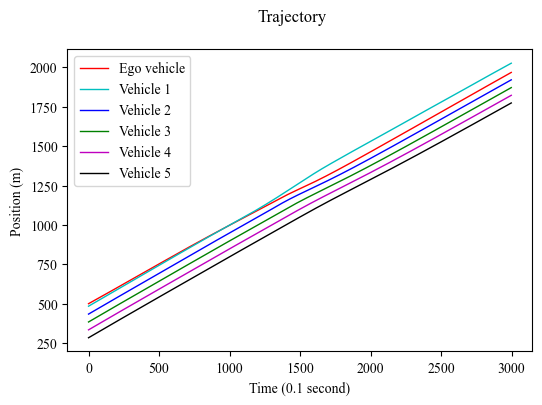

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


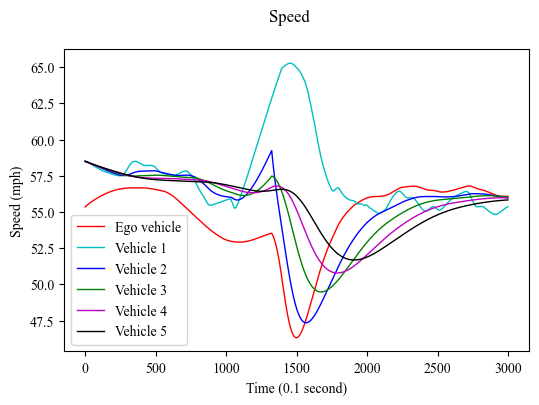

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


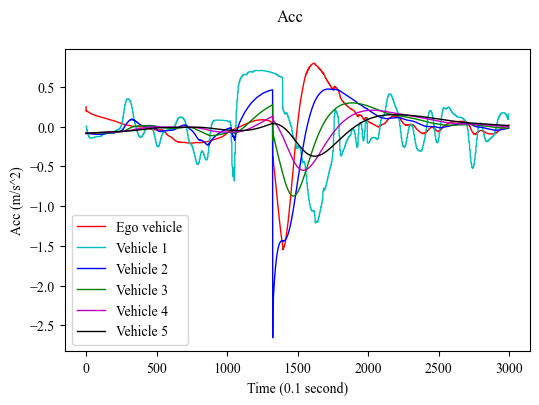

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Idx,  1


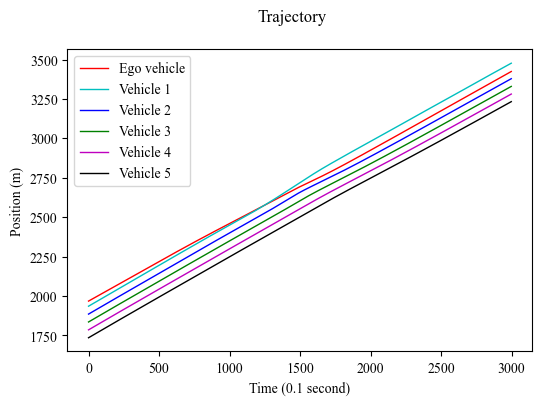

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


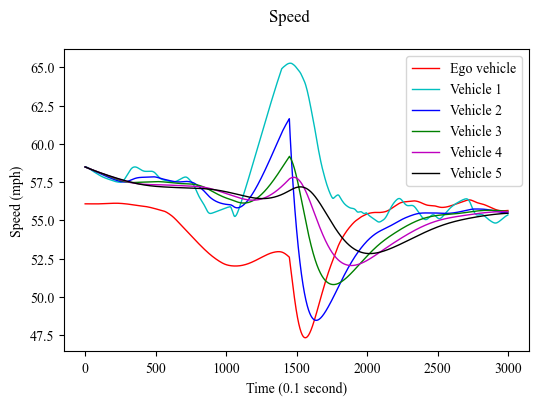

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


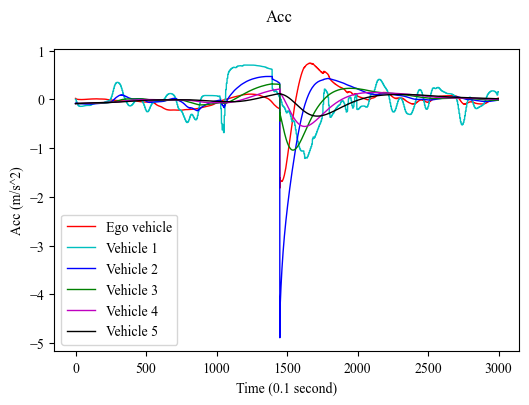

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Idx,  2


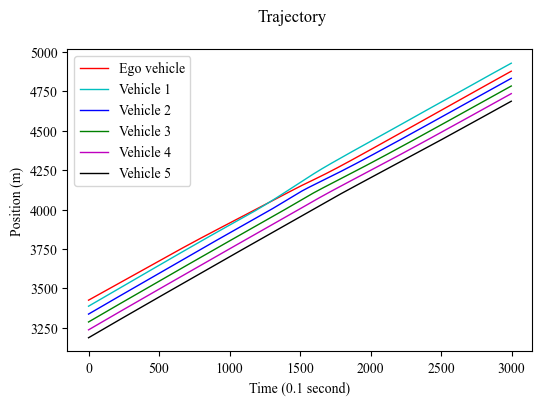

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


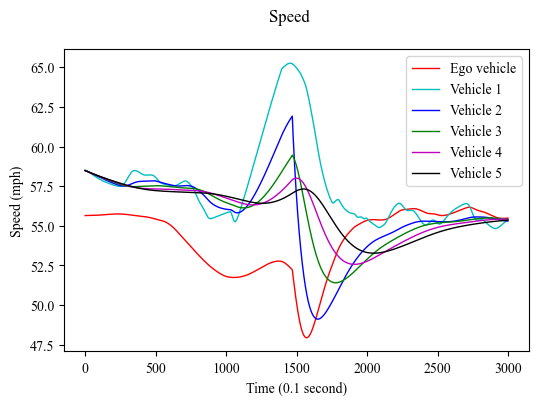

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


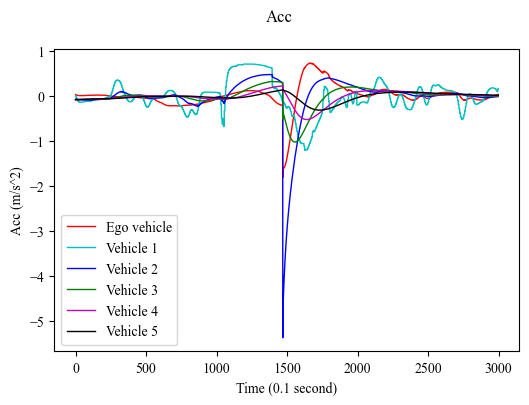

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Idx,  3


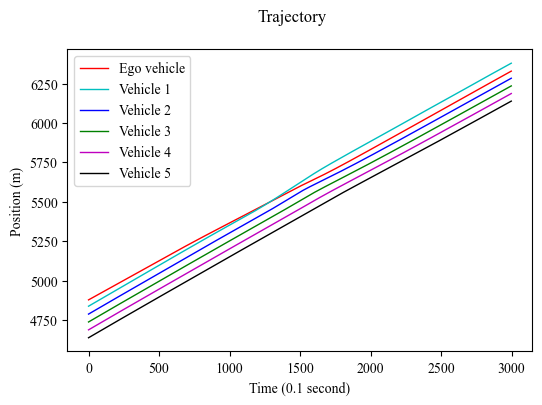

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


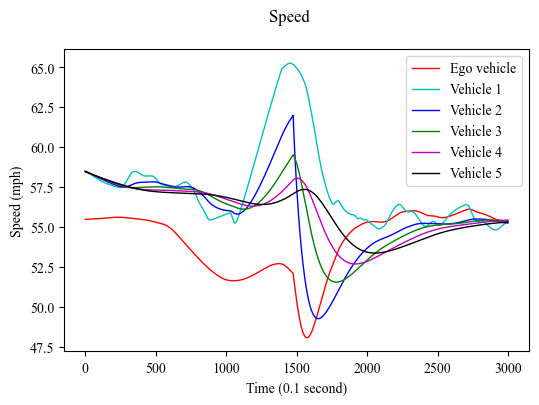

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


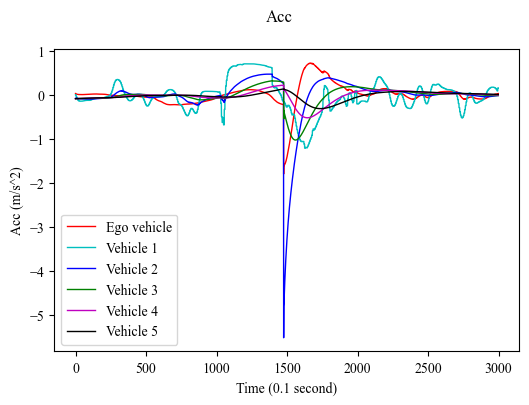

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Idx,  4


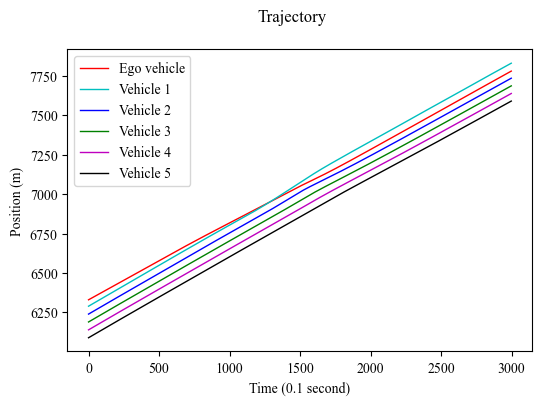

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


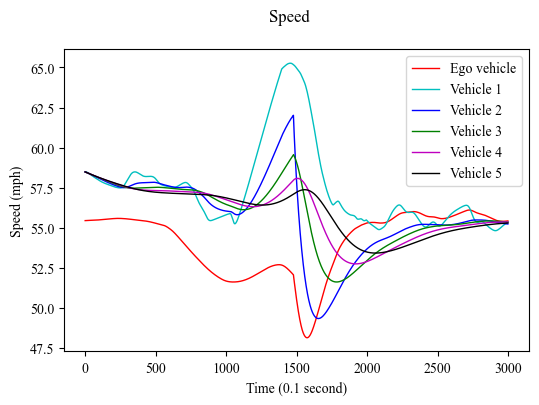

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


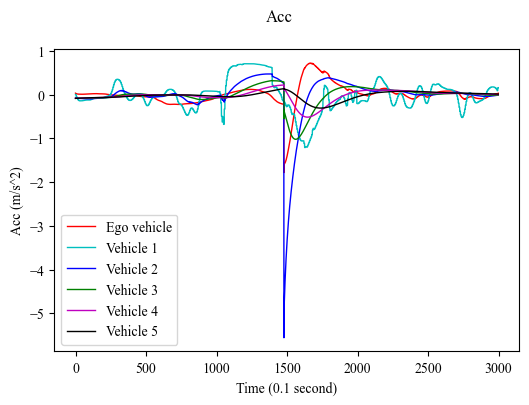

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Idx,  5


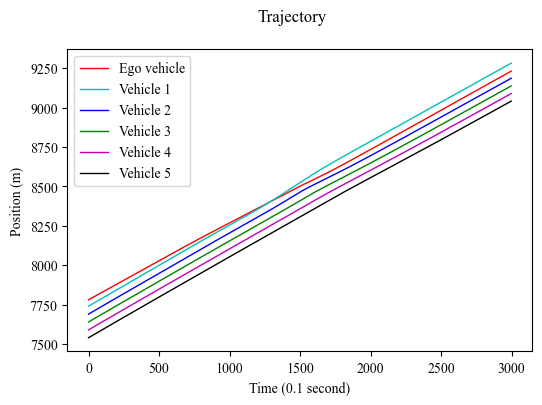

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


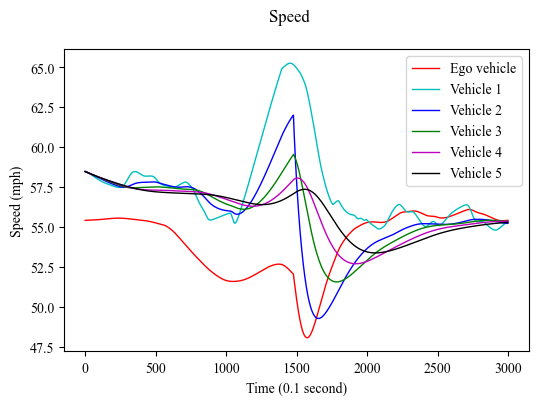

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


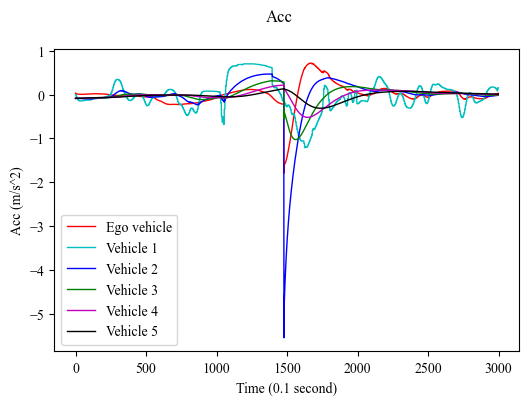

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Idx,  6


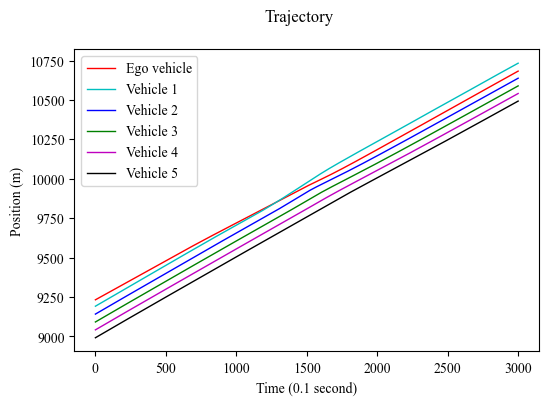

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


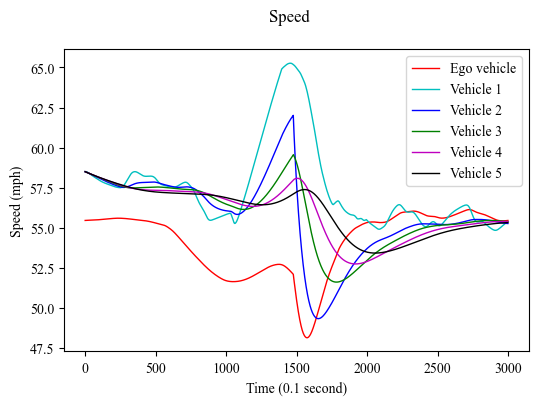

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


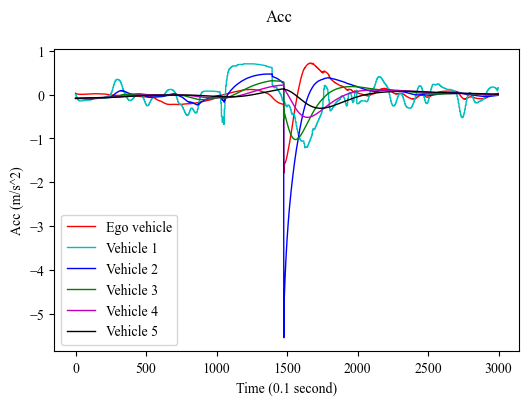

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Idx,  7


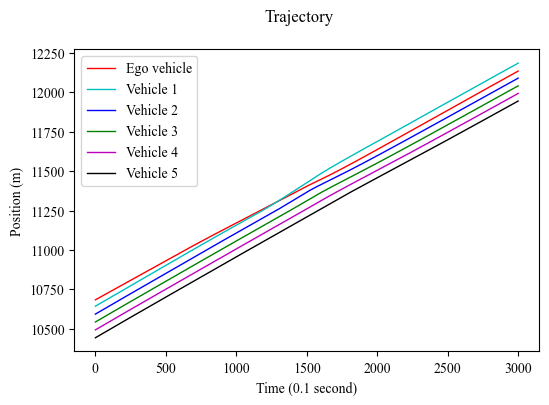

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


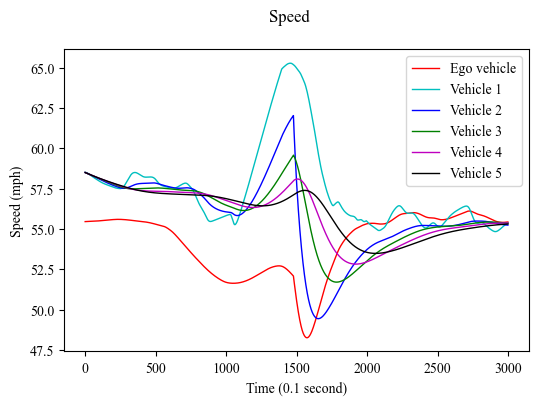

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


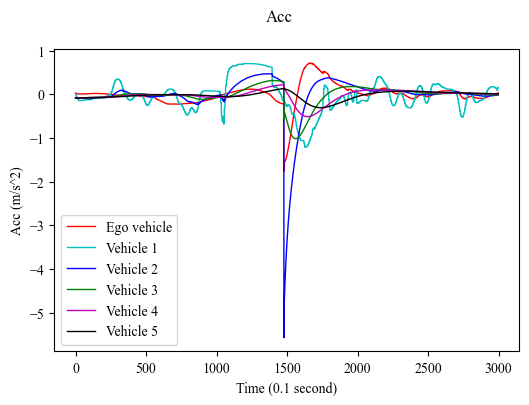

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Idx,  8


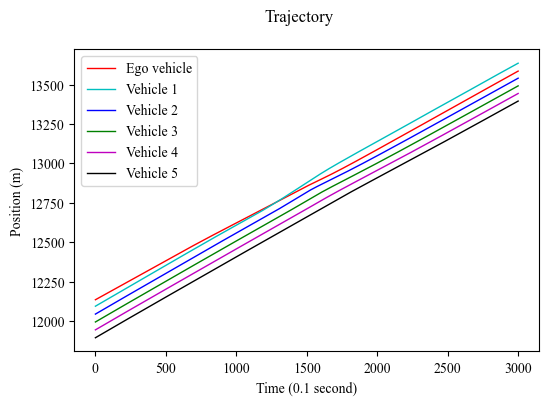

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


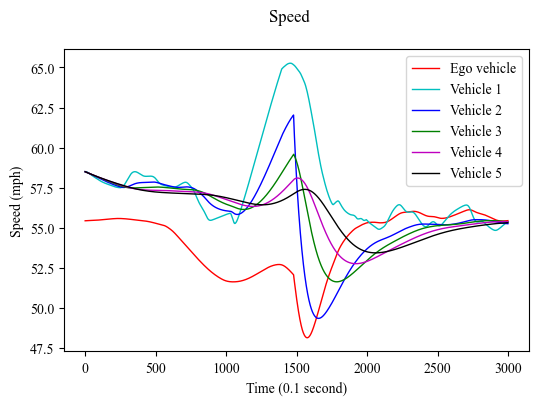

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


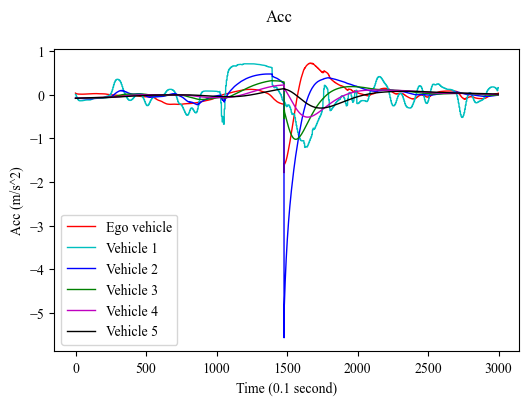

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Idx,  9


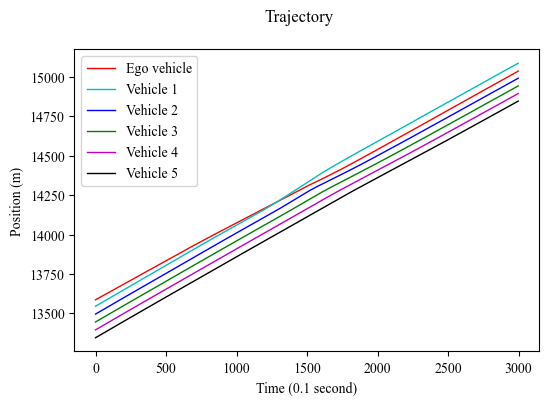

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


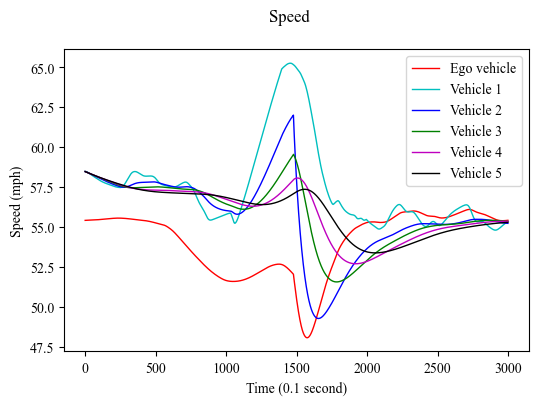

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


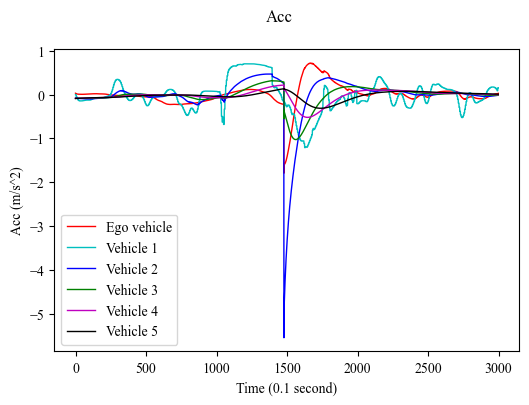

In [4]:
for k in range(10):
#k = 4
    print('Idx, ', k)
    #Traj_tmp = Dat[Run_len*k :Run_len*k + Run_len,k]   # ego platoon
    Traj_tmp = Dat[Run_len*k + 1:Run_len*k + Run_len,k+1]  # target platoon
    Traj_tmp_ego = Dat_ego[Run_len*k + 1:Run_len*k + Run_len]

    plt.figure(dpi=100)
    plt.plot(Traj_tmp_ego[:,0],c='r', linewidth=1.0, label = 'Ego vehicle')
    plt.plot(Traj_tmp[:,0,0],c='c', linewidth=1.0, label = 'Vehicle 1')
    plt.plot(Traj_tmp[:,1,0],c='b', linewidth=1.0, label = 'Vehicle 2')
    plt.plot(Traj_tmp[:,2,0],c='g', linewidth=1.0, label = 'Vehicle 3')
    plt.plot(Traj_tmp[:,3,0],c='m', linewidth=1.0, label = 'Vehicle 4')
    plt.plot(Traj_tmp[:,4,0],c='black', linewidth=1.0, label = 'Vehicle 5')
    plt.suptitle('Trajectory')
    plt.xlabel('Time (0.1 second)')
    plt.ylabel('Position (m)')
    plt.legend()
    plt.savefig('Traj.eps', dpi=300, format = 'eps')
    plt.show()

    plt.figure(dpi=100)
    plt.plot(Traj_tmp_ego[:,1]*2.23694,c='r', linewidth=1.0, label = 'Ego vehicle')
    plt.plot(Traj_tmp[:,0,1]*2.23694,c='c', linewidth=1.0, label = 'Vehicle 1')
    plt.plot(Traj_tmp[:,1,1]*2.23694,c='b', linewidth=1.0, label = 'Vehicle 2')
    plt.plot(Traj_tmp[:,2,1]*2.23694,c='g', linewidth=1.0, label = 'Vehicle 3')
    plt.plot(Traj_tmp[:,3,1]*2.23694,c='m', linewidth=1.0, label = 'Vehicle 4')
    plt.plot(Traj_tmp[:,4,1]*2.23694,c='black', linewidth=1.0, label = 'Vehicle 5')
    plt.suptitle('Speed')
    plt.xlabel('Time (0.1 second)')
    plt.ylabel('Speed (mph)')
    plt.legend()
    plt.savefig('Speed.eps', dpi=300, format = 'eps')
    plt.show()

    plt.figure(dpi=100)
    plt.plot(Traj_tmp_ego[:,2],c='r', linewidth=1.0, label = 'Ego vehicle')
    plt.plot(Traj_tmp[:,0,2],c='c', linewidth=1.0, label = 'Vehicle 1')
    plt.plot(Traj_tmp[:,1,2],c='b', linewidth=1.0, label = 'Vehicle 2')
    plt.plot(Traj_tmp[:,2,2],c='g', linewidth=1.0, label = 'Vehicle 3')
    plt.plot(Traj_tmp[:,3,2],c='m', linewidth=1.0, label = 'Vehicle 4')
    plt.plot(Traj_tmp[:,4,2],c='black', linewidth=1.0, label = 'Vehicle 5')
    plt.suptitle('Acc')
    plt.xlabel('Time (0.1 second)')
    plt.ylabel('Acc (m/s^2)')
    plt.legend()
    plt.savefig('Acc.eps', dpi=300, format = 'eps')
    plt.show()

# Backup 

## SetSpeed 

In [1]:
import os, sys, socket, re, json, random
import numpy as np
#import torch
#import torch.nn as nn

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj loading ########################
duration   = 2000
m2m        = 1/2.23694
Leader_old = np.loadtxt('Old_leader_0.02.txt', delimiter='\t') # (33000, 3) (time, (position, speed, acc))
Leader_new = np.loadtxt('New_leader_0.02.txt', delimiter='\t')
fre        = 0.02
Run_len    = int(60/fre)
Time_len   = 11*Run_len    
########################## Function ##########################
def EIDM(spacing, v, *cv_arg, v0 = 30, s0=2, a0=0.8, b0=1.5, T=1.2, sigma=4, Kf=0.85, Kg=0.6,):
    cv_arg         = cv_arg[0]
    CAV_count      = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta    = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i]  = 0.3/(0.3+np.exp(i))
            temp_v  += alpha[i]*cv_arg[2*i]
            temp_a  += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int  = -a0*(s_star/spacing)**2
    acc    = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)
v0=30; T0=1.2; s0=2; a0=0.8; b0=1.5; sigma=4; Kf=0.85; Kg=0.6
'''
class IDM(nn.Module):
    def __init__(self, 
        speed_desire, 
        time_gap, 
        acc_max, 
        dec_desire, 
        distance_jam
        ):
        super(IDM, self).__init__()  
        self.v_0 = speed_desire
        self.T   = time_gap
        self.a   = acc_max
        self.b   = dec_desire
        self.s_0 = distance_jam
        
    def forward(self, v_i, v_delta, s_i):
        s_temp = self.s_0 + v_i * self.T + v_i * v_delta / (2 * ((self.a * self.b)**0.5))
        output = self.a * (1 - (v_i / self.v_0)**4 - (s_temp / s_i)**2) 
        return output
'''
veh_len  = 5
lane_wid = 3.65
v0       = 30    

########################## Preliminaries ##########################
para_IDM  = [1.6, 0.73, 1.67]
T0        = np.random.normal(para_IDM[0], 0)#0.2)
a0        = np.random.normal(para_IDM[1], 0)#0.08)
b0        = np.random.normal(para_IDM[2], 0)#0.08)
s0        = np.random.normal(2, 0)#0.5)
#IDM_model = IDM(v0, T0, a0, b0, s0)

N_group     = 12
N_veh       = 5
N_veh_total = 55  
# gourp 0: 0 - 4
# group 1: 5 - 9
# group 2: 10 - 14

Dat = np.zeros((Time_len, N_group, N_veh, 3)) 
# Time_len: 33000
# N_group : 0 - old_leader platoon; 1-10 - new-leader platoon; 11 - non-sense
# N_veh   : 0 - leader; 1 - vehicle being but-in; >=2 -followers
# features: 0 - position; 1 - speed; 2 - acc
Dat_ego = np.zeros((Time_len, 6))
# longitudinal: 0 - position; 1 - speed; 2 - acc
# lateral     : 3 - position; 4 - speed; 5 - acc

Dat[:,0,0,1:3] = Leader_old[:,1:3]         # speed, acc

for i in range(1, N_group):
    if i == 1:
        Dat[:,i,0, 1:3] = Leader_new[:,1:3] # speed, acc
    else:
        Dat[(i-1)*Run_len:,i,0, 1:3] = Leader_new[0:-(i-1)*Run_len,1:3] # speed, acc

dis_0            = 91               # Spacing between two leaders
spacing_ego_0    = 75               # Spacing between the original leader and the ego vehicle
spacing_target_0 = 50               # Spacing between vehicles

Lane_ego     = 0                    # Ego vehicle start from Lane 0
Lane_target  = 1 
LC_direction = +1                   # left lane change; -1 right lane change
LC_do        = [0]*11               # Indication of lane change complete
# 1: 0->1; 1->2
#-1: 2->1; 1->0

############################## SUMO ############################################
#graph = sumolib.net.readNet('90_new_no.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
#vertex = graph.getNodes()
#edge = graph.getEdges(withInternal=True)

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(Leader_old[0,1]), departLane = str(0), typeID="vtypeauto")
traci.vehicle.setColor('ego', color=(0, 255, 0))
traci.vehicle.setLaneChangeMode('ego', 256)
traci.gui.track('ego')                    # Track the ego vehicle
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))
#traci.vehicle.getLanePosition("%d" % i)
#traci.vehicle.getSpeed("%d" % i)
#traci.vehicle.getAcceleration("%d" % i)
#traci.vehicle.getLaneIndex(self, vehID)
#traci.vehicle.getLateralLanePosition
#traci.vehicle.getLateralSpeed(self, vehID)
#traci.vehicle.changeLane(self, vehID, laneIndex, duration)
#traci.vehicle.changeLaneRelative(self, vehID, indexOffset, duration)
    

############################## Data transmission ############################################

#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))


##################################### Run ########################################
data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]
y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 814.42, 0.55  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)





traci.simulationStep()

step     = 0
max_iter = Time_len
while step < max_iter-1:

    ############################ Read ego vehicle information ######################
    
    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    y, x, z, vx, vy = data.split(";")
    #x, y = '6448.97', '-6645.57'
    X_offset, Y_offset = 814.42, 0.55  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    traci.vehicle.setSpeed('ego', 0.0)
    eLanePos = traci.vehicle.getLanePosition('ego')
    # traci.vehicle.getLateralLanePosition('ego')
    #print(eLanePos)
    #print(x, y)
    

    ############################# Initialization ##########################
    if step==0:
        # ego vehicle
        eLanePos = traci.vehicle.getLanePosition('ego')
        
        # ego platoon
        Lane_ego     = traci.vehicle.getLaneIndex('ego')              # lane index for the ego platoon
        Lane_target  = 1                                              # Lane index for the target platoon
        LC_direction = Lane_target - Lane_ego                         # lane-change direction
        
        Lane_ego_last     = Lane_ego                                  # Saved as backup
        Lane_target_last  = Lane_target
        LC_direction_last = LC_direction
        
        idx_group_ego     = 0                                         # Idx of the platoon
        # The leader
        Dat[step,idx_group_ego,0,0] = eLanePos + spacing_ego_0        # Initial position of the original leader
        pos_tmp, speed_tmp, acc_tmp = Dat[step,idx_group_ego,0]       # Read information
        # Add vehicle
        vid = "%d" % 0                                                # Vehicle ID
        traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_ego), typeID="vtypeauto")
        traci.vehicle.setColor(vid, (255, 0, 0))
        traci.vehicle.setLaneChangeMode(vid, 256)
        traci.vehicle.setSpeed(vid, speed_tmp + acc_tmp*fre)
        
        # The follower
        for i in range(1, N_veh):
            Dat[step,idx_group_ego,i,0] = eLanePos - spacing_target_0 * i # Position
            Dat[step,idx_group_ego,i,1] = Dat[step,idx_group_ego,0,1]     # Speed
            Dat[step,idx_group_ego,i,2] = 0                               # Acc
            pos_tmp, speed_tmp, acc_tmp = Dat[step,idx_group_ego,i]       # Read information
            # Add vehicle
            vid = "%d" % (idx_group_ego * N_veh + i)                      # Vehicle ID
            traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_ego), typeID="vtypeauto")
            traci.vehicle.setColor(vid, (0, 0, 255))
            traci.vehicle.setLaneChangeMode(vid, 256)
            traci.vehicle.setSpeed(vid, speed_tmp + acc_tmp*fre)
            
        
        # target platoon
        idx_group_target = 1                                              # Index for the target platoo
        
        Dat[step,idx_group_target,0,0] = Dat[step,idx_group_target - 1,0,0] - dis_0 # Initial position
        pos_tmp, speed_tmp, acc_tmp    = Dat[step,idx_group_target,0]     # Read information
        # Add vehicle
        vid = "%d" % (idx_group_target * N_veh)                           # Vehicle ID          
        traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_target), typeID="vtypeauto")
        traci.vehicle.setColor(vid, (255, 0, 0))
        traci.vehicle.setLaneChangeMode(vid, 256)
        traci.vehicle.setSpeed(vid, speed_tmp + acc_tmp*fre)
        
        for i in range(1, N_veh):
            Dat[step,idx_group_target,i,0] = Dat[step,idx_group_target,0,0] - spacing_target_0 * i
            Dat[step,idx_group_target,i,1] = Dat[step,idx_group_target,0,1]
            Dat[step,idx_group_target,i,2] = 0
            pos_tmp, speed_tmp, acc_tmp    = Dat[step,idx_group_target,i]  # Read information
            # Add vehicle
            vid = "%d" % (idx_group_target * N_veh + i)                    # Vehicle ID
            traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_target), typeID="vtypeauto")
            traci.vehicle.setColor(vid, (0, 0, 255))
            traci.vehicle.setLaneChangeMode(vid, 256)
            traci.vehicle.setSpeed(vid, speed_tmp + acc_tmp*fre)

    
    
    
    ############################# Add platoon  ##########################
    elif (step + 1) % Run_len == 0 and step != max_iter - 1:    
        # Lane-change direction
        Lane_ego = traci.vehicle.getLaneIndex('ego')       # Lane index of the ego vehicle
        if Lane_ego == 0 or Lane_ego == 2:
            Lane_target = 1
        elif Lane_ego == 1:
            Lane_target = Lane_ego + LC_direction_last
        LC_direction = Lane_target - Lane_ego       
        print(LC_direction)
        
        if Lane_ego != Lane_ego_last:                      # Did change lane
            # Remove vehicles
            idx_group_remove = idx_group_ego               # Remove old platoon
            idx_group_ego = int ((step + 1) / Run_len)     # New platoon become the ego platoon
        else:                                              # No lane change
            # Remove vehicles
            idx_group_remove = int ((step + 1) / Run_len)  # Remove the new platoon
        # Remove vehicles
        for i in range(N_veh):
            vid = "%d" % (idx_group_remove * N_veh + i)
            traci.vehicle.remove(vid)
        
        Lane_ego_last     = Lane_ego
        Lane_target_last  = Lane_target
        LC_direction_last = LC_direction 
        
        # Add new platoon
        idx_group_target  = int ((step + 1) / Run_len) + 1  # Index of the new platoon
        
        # The leader
        #ego_leader_pos                 = traci.vehicle.getLanePosition("%d" % (idx_group_ego * N_veh))
        ego_leader_pos                 = traci.vehicle.getLanePosition('ego')
        Dat[step,idx_group_target,0,0] = ego_leader_pos - dis_0 + spacing_ego_0 # Postion
        pos_tmp, _, _                  = Dat[step,idx_group_target,0]        # Speed
        _, speed_tmp, acc_tmp          = Dat[step + 1,idx_group_target,0]    # Acc      
        # Add vehicle
        vid = "%d" % (idx_group_target * N_veh)              # Vehicle ID
        traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_target), typeID="vtypeauto")
        traci.vehicle.setColor(vid, (255, 0, 0))
        traci.vehicle.setLaneChangeMode(vid, 256)
        traci.vehicle.setSpeed(vid, speed_tmp + acc_tmp*fre)
        
        # The followers
        for i in range(1, N_veh):
            Dat[step,idx_group_target,i,0] = Dat[step,idx_group_target,0,0] -spacing_target_0 * i
            Dat[step,idx_group_target,i,1] = Dat[step + 1,idx_group_target,0,1]
            Dat[step,idx_group_target,i,2] = 0
            pos_tmp, speed_tmp, acc_tmp    = Dat[step,idx_group_target,i]
            # Add vehicle
            vid = "%d" % (idx_group_target * N_veh + i)                         # Vehicle ID
            traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_target), typeID="vtypeauto")
            traci.vehicle.setColor(vid, (0, 0, 255))
            traci.vehicle.setLaneChangeMode(vid, 256)
            traci.vehicle.setSpeed(vid, speed_tmp + acc_tmp*fre)

            
############################# Leaders ##########################
    # ego platoon information
    # the leader
    vid = "%d" % (idx_group_ego * N_veh)
    Dat[step,idx_group_ego,0,0] = traci.vehicle.getLanePosition(vid)
    _, speed_tmp, _             = Dat[step,idx_group_ego,0]
    _, _, acc_next              = Dat[step + 1,idx_group_ego,0]
    traci.vehicle.setSpeed(vid, speed_tmp + acc_next*fre)
    # target platoon
    # the leader
    vid = "%d" % (idx_group_target * N_veh)
    Dat[step,idx_group_target,0,0] = traci.vehicle.getLanePosition(vid)
    _, speed_tmp, _                = Dat[step,idx_group_target,0]
    _, _, acc_next                 = Dat[step + 1,idx_group_target,0]
    traci.vehicle.setSpeed(vid, speed_tmp + acc_next*fre)
    

             
    ############################# Ego vehicle ##########################
    # Information for the ego vehicle
    #Dat_ego[step,0] = traci.vehicle.getLanePosition('ego')
    #Dat_ego[step,1] = traci.vehicle.getSpeed('ego')
    #Dat_ego[step,2] = traci.vehicle.getAcceleration('ego')
    Dat_ego[step,0] = traci.vehicle.getLanePosition('ego')
    Dat_ego[step,1] = (Dat_ego[step,0] - Dat_ego[step-1,0])/fre
    Dat_ego[step,2] = (Dat_ego[step,1] - Dat_ego[step-1,1])/fre
    
    Dat_ego[step,3] = lane_wid * (traci.vehicle.getLaneIndex('ego')+0.5) + traci.vehicle.getLateralLanePosition('ego') 
    Dat_ego[step,4] = traci.vehicle.getLateralSpeed('ego')
    
    if step == 0:
        Dat_ego[step,5] = 0
    else:
        Dat_ego[step,5] = (Dat_ego[step,4] - Dat_ego[step-1,4])/fre
    '''
    # The preceding vheicle information
    if step == 0:
        Leader = 0
    else:
        Leader = int(traci.vehicle.getLeader('ego')[0])
    
    idx_veh_tmp                 = Leader % N_veh                         # Vehicle index
    idx_group_tmp               = int(Leader/N_veh)                      # Platoon index
    pos_tmp, speed_tmp, acc_tmp = Dat_ego[step,0:3]                      # Read information of the ego vehicle
    pos_pre, speed_pre, acc_pre = Dat[step,idx_group_tmp,idx_veh_tmp]    # Read information of the target vehicle

    # EIDM
    space    = pos_pre - pos_tmp - veh_len
    v        = speed_tmp
    rel_v    = speed_pre - speed_tmp
    rel_acc  = acc_pre - acc_tmp
    acc_next = EIDM(space, v, (rel_v,rel_acc))
    
    # IDM
    v        = speed_tmp
    v_delt   = speed_tmp - speed_pre
    spacing  = pos_pre - pos_tmp - veh_len
    acc_next = IDM_model(v, v_delt, spacing)    
    
    traci.vehicle.setSpeed('ego', speed_tmp + acc_next*fre)   
    
    # Lane-change decision-making
    if (step + 1) % Run_len > (20/fre) and step != max_iter - 1:              # Time step
        if LC_direction   == 1:                                               # Lane change direction
            if len(traci.vehicle.getLeftLeaders('ego'))!=0:                   # Exist preceding vehicle
                if int(traci.vehicle.getLeftLeaders('ego')[0][0]) == idx_group_target * N_veh and LC_do[int((step + 1) / Run_len)]  == 0:                    # No lane change within this 60s
                    if Dat[step,idx_group_target,0,0] - pos_tmp >= 7.0 and pos_tmp - Dat[step,idx_group_target,1,0]>= 7.0:
                        traci.vehicle.changeLaneRelative('ego', LC_direction, 5)  # Change lane with relative direction
                        LC_do[int((step + 1) / Run_len)] = 1                      # Mark lane change
        elif LC_direction == -1:
            if len(traci.vehicle.getRightLeaders('ego'))!=0:
                if int(traci.vehicle.getRightLeaders('ego')[0][0]) == idx_group_target * N_veh and LC_do[int((step + 1) / Run_len)]  == 0:
                    if Dat[step,idx_group_target,0,0] - pos_tmp >= 7.0 and pos_tmp - Dat[step,idx_group_target,1,0]>= 7.0:
                        traci.vehicle.changeLaneRelative('ego', LC_direction, 5)
                        LC_do[int((step + 1) / Run_len)] = 1
                    
    '''
    
    ############################# Followers ##########################
    # ego platoon information
    # The follower
    for i in range(1, N_veh):
        vid = "%d" % (idx_group_ego * N_veh + i)
        Dat[step,idx_group_ego,i,0] = traci.vehicle.getLanePosition(vid)
        Dat[step,idx_group_ego,i,1] = traci.vehicle.getSpeed(vid)
        Dat[step,idx_group_ego,i,2] = traci.vehicle.getAcceleration(vid)
        # Read information
        pos_tmp, speed_tmp, acc_tmp = Dat[step,idx_group_ego,i]
        pos_pre, speed_pre, acc_pre = Dat[step,idx_group_ego,i-1]
        if i == 1 and step != 0 and (step + 1) % Run_len != 0:
            if traci.vehicle.getLeader(vid)[0]=='ego':
                pos_pre, speed_pre, acc_pre = Dat_ego[step,0:3]
        # EIDM
        space    = pos_pre - pos_tmp - veh_len
        v        = speed_tmp
        rel_v    = speed_pre - speed_tmp
        rel_acc  = acc_pre - acc_tmp
        acc_next = EIDM(space, v, (rel_v,rel_acc))
        '''
        # IDM
        v        = speed_tmp
        v_delt   = speed_tmp - speed_pre
        spacing  = pos_pre - pos_tmp - veh_len
        acc_next = IDM_model(v, v_delt, spacing)    
        '''        
        traci.vehicle.setSpeed(vid, speed_tmp + acc_next*fre)
    
    # target platoon
    # the followers
    for i in range(1, N_veh):
        vid = "%d" % (idx_group_target * N_veh + i)
        Dat[step,idx_group_target,i,0] = traci.vehicle.getLanePosition(vid)
        Dat[step,idx_group_target,i,1] = traci.vehicle.getSpeed(vid)
        Dat[step,idx_group_target,i,2] = traci.vehicle.getAcceleration(vid)
        # read information
        pos_tmp, speed_tmp, acc_tmp = Dat[step,idx_group_target,i]
        pos_pre, speed_pre, acc_pre = Dat[step,idx_group_target,i-1]
        if i == 1 and step != 0 and (step + 1) % Run_len != 0:
            if traci.vehicle.getLeader(vid)[0]=='ego':
                pos_pre, speed_pre, acc_pre = Dat_ego[step,0:3]
        # EIDM
        space    = pos_pre - pos_tmp - veh_len
        v        = speed_tmp
        rel_v    = speed_pre - speed_tmp
        rel_acc  = acc_pre - acc_tmp
        acc_next = EIDM(space, v, (rel_v,rel_acc))
        '''
        # IDM
        v        = speed_tmp
        v_delt   = speed_tmp - speed_pre
        spacing  = pos_pre - pos_tmp - veh_len
        acc_next = IDM_model(v, v_delt, spacing)   
        '''        
        traci.vehicle.setSpeed(vid, speed_tmp + acc_next*fre)


    ############################# Message transmission ##########################
    Message =''
    Message =  "0" + "," + "0" + "," + Message

    for i in range(0, N_veh):       
        vid = "%d" % (idx_group_ego * N_veh + i)
        Message += vid + ',' 

        Position = traci.vehicle.getPosition(vid)
        vel = Dat[step,idx_group_ego,i,1]
        acc = Dat[step,idx_group_ego,i,2]

        xx = "{0:.3f}".format(Position[0]-X_offset) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 
        Message += xx + "," + yy +","

        angle = traci.vehicle.getAngle('ego')
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","

        if acc < -0.1:
            sig = 3
        else:
            sig = 0
        Message +=  str(sig) + "," + str(vel) + ","   

    for i in range(0, N_veh):
        vid = "%d" % (idx_group_target * N_veh + i)
        Message += vid + ',' 

        Position = traci.vehicle.getPosition(vid)
        vel = Dat[step,idx_group_target,i,1]
        acc = Dat[step,idx_group_target,i,2]

        xx = "{0:.3f}".format(Position[0]-X_offset) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 
        Message += xx + "," + yy +","

        angle = traci.vehicle.getAngle('ego')
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","

        if acc < -0.1:
            sig = 3
        else:
            sig = 0
        Message +=  str(sig) + "," + str(vel) + ","  
        

        
    Message = Message[:-1]
    #print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))
    
    # Save the Dat
    if step == max_iter-2:
        print(Dat.shape)
        np.savetxt('Result/Data_EIDM.txt',Dat.reshape(-1,3),fmt = '%.15f', delimiter='\t', newline='\n')
        np.savetxt('Result/Data_ego_EIDM.txt',Dat_ego, fmt = '%.15f', delimiter='\t', newline='\n')
    
    step += 1
    
    traci.simulationStep()
    if step > max_iter:
        break

traci.close()

1
(33000, 12, 5, 3)


In [1]:
import os, sys, socket, re, json, random
import numpy as np
import torch
import torch.nn as nn

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj loading ########################
duration   = 2000
m2m        = 1/2.23694
Leader_old = np.loadtxt('Old_leader_0.02.txt', delimiter='\t') # (33000, 3) (time, (position, speed, acc))
Leader_new = np.loadtxt('New_leader_0.02.txt', delimiter='\t')
fre        = 0.02
Run_len    = int(60/fre)
Time_len   = 11*Run_len    
########################## Function ##########################
def EIDM(spacing, v, *cv_arg, v0 = 30, s0=2, a0=0.8, b0=1.5, T=1.2, sigma=4, Kf=0.85, Kg=0.6,):
    cv_arg         = cv_arg[0]
    CAV_count      = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta    = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i]  = 0.3/(0.3+np.exp(i))
            temp_v  += alpha[i]*cv_arg[2*i]
            temp_a  += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int  = -a0*(s_star/spacing)**2
    acc    = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)
v0=30; T0=1.2; s0=2; a0=0.8; b0=1.5; sigma=4; Kf=0.85; Kg=0.6

class IDM(nn.Module):
    def __init__(self, 
        speed_desire, 
        time_gap, 
        acc_max, 
        dec_desire, 
        distance_jam
        ):
        super(IDM, self).__init__()  
        self.v_0 = speed_desire
        self.T   = time_gap
        self.a   = acc_max
        self.b   = dec_desire
        self.s_0 = distance_jam
        
    def forward(self, v_i, v_delta, s_i):
        s_temp = self.s_0 + v_i * self.T + v_i * v_delta / (2 * ((self.a * self.b)**0.5))
        output = self.a * (1 - (v_i / self.v_0)**4 - (s_temp / s_i)**2) 
        return output

veh_len  = 5
lane_wid = 3.65
v0       = 30    

########################## Preliminaries ##########################
para_IDM  = [1.6, 0.73, 1.67]
T0        = np.random.normal(para_IDM[0], 0)#0.2)
a0        = np.random.normal(para_IDM[1], 0)#0.08)
b0        = np.random.normal(para_IDM[2], 0)#0.08)
s0        = np.random.normal(2, 0)#0.5)
IDM_model = IDM(v0, T0, a0, b0, s0)

N_group     = 12
N_veh       = 5
N_veh_total = 55  
# gourp 0: 0 - 4
# group 1: 5 - 9
# group 2: 10 - 14
Dat = np.zeros((Time_len, N_group, N_veh, 3)) 
Dat_record = Dat.copy()
# Time_len: 33000
# N_group : 0 - old_leader platoon; 1-10 - new-leader platoon; 11 - non-sense
# N_veh   : 0 - leader; 1 - vehicle being but-in; >=2 -followers
# features: 0 - position; 1 - speed; 2 - acc
Dat_ego = np.zeros((Time_len, 6))
# longitudinal: 0 - position; 1 - speed; 2 - acc
# lateral     : 3 - position; 4 - speed; 5 - acc

Dat[:,0,0,1:3] = Leader_old[:,1:3]         # speed, acc

for i in range(1, N_group):
    if i == 1:
        Dat[:,i,0, 1:3] = Leader_new[:,1:3] # speed, acc
    else:
        Dat[(i-1)*Run_len:,i,0, 1:3] = Leader_new[0:-(i-1)*Run_len,1:3] # speed, acc

dis_0            = 91               # Spacing between two leaders
spacing_ego_0    = 75               # Spacing between the original leader and the ego vehicle
spacing_target_0 = 50               # Spacing between vehicles

Lane_ego     = 0                    # Ego vehicle start from Lane 0
Lane_target  = 1 
LC_direction = +1                   # left lane change
LC_do        = [0]*11               # Indication of lane change complete
# 1: 0->1; 1->2
#-1: 2->1; 1->0

############################## SUMO ############################################
#graph = sumolib.net.readNet('90_new_no.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
#vertex = graph.getNodes()
#edge = graph.getEdges(withInternal=True)

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)

traci.route.add(routeID = 'route1', edges = ['-3.0.00'])
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(Leader_old[0,1]), departLane = str(0), typeID="vtypeauto")
traci.vehicle.setColor('ego', color=(0, 255, 0))
traci.vehicle.setLaneChangeMode('ego', 256)
traci.gui.track('ego')                    # Track the ego vehicle
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))
#traci.vehicle.getLanePosition("%d" % i)
#traci.vehicle.getSpeed("%d" % i)
#traci.vehicle.getAcceleration("%d" % i)
#traci.vehicle.getLaneIndex(self, vehID)
#traci.vehicle.getLateralLanePosition
#traci.vehicle.getLateralSpeed(self, vehID)
#traci.vehicle.changeLane(self, vehID, laneIndex, duration)
#traci.vehicle.changeLaneRelative(self, vehID, indexOffset, duration)
    
traci.simulationStep()

############################## Data transmission ############################################
'''
#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))
'''

    
##################################### Run ########################################
step     = 0
max_iter = Time_len/10
while step < max_iter-1:

    ############################ Read ego vehicle information ######################
    '''
    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    y, x, z, vx, vy = data.split(";")
    #x, y = '6448.97', '-6645.57'
    X_offset, Y_offset = 10273, 1000.5  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    traci.vehicle.setSpeed('ego', 0.0)
    eLanePos = traci.vehicle.getLanePosition('ego')
    # traci.vehicle.getLateralLanePosition('ego')
    #print(eLanePos)
    print(x, y)
    '''

    ############################# Initialization ##########################
    if step==0:
        # ego vehicle
        eLanePos = traci.vehicle.getLanePosition('ego')
        Dat_ego[step,0] = eLanePos
        Dat_ego[step,1] = Leader_old[0,1]
        Dat_ego[step,2] = 0    
        Dat_ego[step,3] = lane_wid * (traci.vehicle.getLaneIndex('ego')+0.5) + traci.vehicle.getLateralLanePosition('ego') 
        Dat_ego[step,4] = traci.vehicle.getLateralSpeed('ego')
        Dat_ego[step,5] = 0
    
        # ego platoon
        Lane_ego     = traci.vehicle.getLaneIndex('ego')              # lane index for the ego platoon
        Lane_target  = 1                                              # Lane index for the target platoon
        LC_direction = Lane_target - Lane_ego                         # lane-change direction
        
        Lane_ego_last     = Lane_ego                                  # Saved as backup
        Lane_target_last  = Lane_target
        LC_direction_last = LC_direction
        
        idx_group_ego     = 0                                         # Idx of the platoon
        # The leader
        Dat[step,idx_group_ego,0,0] = eLanePos + spacing_ego_0        # Initial position of the original leader
        pos_tmp, speed_tmp, acc_tmp = Dat[step,idx_group_ego,0]       # Read information
        # Add vehicle
        vid = "%d" % 0                                                # Vehicle ID
        traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_ego), typeID="vtypeauto")
        traci.vehicle.setColor(vid, (255, 0, 0))
        traci.vehicle.setLaneChangeMode(vid, 256)
        traci.vehicle.moveTo(vid, '-3.0.00_'+str(Lane_ego), pos_tmp)
        Dat_record[step,idx_group_ego,0, 0] = traci.vehicle.getLanePosition(vid)
        Dat_record[step,idx_group_ego,0, 1] = speed_tmp
        Dat_record[step,idx_group_ego,0, 2] = acc_tmp

        # The follower
        for i in range(1, N_veh):
            Dat[step,idx_group_ego,i,0] = eLanePos - spacing_target_0 * i # Position
            Dat[step,idx_group_ego,i,1] = Dat[step,idx_group_ego,0,1]     # Speed
            Dat[step,idx_group_ego,i,2] = 0                               # Acc
            pos_tmp, speed_tmp, acc_tmp = Dat[step,idx_group_ego,i]       # Read information
            # Add vehicle
            vid = "%d" % (idx_group_ego * N_veh + i)                      # Vehicle ID
            traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_ego), typeID="vtypeauto")
            traci.vehicle.setColor(vid, (0, 0, 255))
            traci.vehicle.setLaneChangeMode(vid, 256)
            traci.vehicle.moveTo(vid, '-3.0.00_'+str(Lane_ego), pos_tmp)
            Dat_record[step,idx_group_ego,i, 0] = traci.vehicle.getLanePosition(vid)
            Dat_record[step,idx_group_ego,i, 1] = speed_tmp
            Dat_record[step,idx_group_ego,i, 2] = acc_tmp
            
        
        # target platoon
        idx_group_target = 1                                              # Index for the target platoo
        
        Dat[step,idx_group_target,0,0] = Dat[step,idx_group_target - 1,0,0] - dis_0 # Initial position
        pos_tmp, speed_tmp, acc_tmp    = Dat[step,idx_group_target,0]     # Read information
        # Add vehicle
        vid = "%d" % (idx_group_target * N_veh)                           # Vehicle ID          
        traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_target), typeID="vtypeauto")
        traci.vehicle.setColor(vid, (255, 0, 0))
        traci.vehicle.setLaneChangeMode(vid, 256)
        traci.vehicle.moveTo(vid, '-3.0.00_'+str(Lane_target), pos_tmp)
        Dat_record[step,idx_group_target,0, 0] = traci.vehicle.getLanePosition(vid)
        Dat_record[step,idx_group_target,0, 1] = speed_tmp
        Dat_record[step,idx_group_target,0, 2] = acc_tmp
        
        for i in range(1, N_veh):
            Dat[step,idx_group_target,i,0] = Dat[step,idx_group_target,0,0] - spacing_target_0 * i
            Dat[step,idx_group_target,i,1] = Dat[step,idx_group_target,0,1]
            Dat[step,idx_group_target,i,2] = 0
            pos_tmp, speed_tmp, acc_tmp    = Dat[step,idx_group_target,i]  # Read information
            # Add vehicle
            vid = "%d" % (idx_group_target * N_veh + i)                    # Vehicle ID
            traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_target), typeID="vtypeauto")
            traci.vehicle.setColor(vid, (0, 0, 255))
            traci.vehicle.setLaneChangeMode(vid, 256)
            traci.vehicle.moveTo(vid, '-3.0.00_'+str(Lane_target), pos_tmp)
            Dat_record[step,idx_group_target,i, 0] = traci.vehicle.getLanePosition(vid)
            Dat_record[step,idx_group_target,i, 1] = speed_tmp
            Dat_record[step,idx_group_target,i, 2] = acc_tmp


    
    ############################# Add platoon  ##########################
    elif step % Run_len == 0 and step != max_iter - 1:    
        # Lane-change direction
        Lane_ego = traci.vehicle.getLaneIndex('ego')       # Lane index of the ego vehicle
        if Lane_ego == 0 or Lane_ego == 2:
            Lane_target = 1
        elif Lane_ego == 1:
            Lane_target = Lane_ego + LC_direction_last
        LC_direction = Lane_target - Lane_ego       
        print(LC_direction)
        
        if Lane_ego != Lane_ego_last:                      # Did change lane
            # Remove vehicles
            idx_group_remove = idx_group_ego               # Remove old platoon
            idx_group_ego = int (step  / Run_len)     # New platoon become the ego platoon
        else:                                              # No lane change
            # Remove vehicles
            idx_group_remove = int (step / Run_len)  # Remove the new platoon
        # Remove vehicles
        for i in range(N_veh):
            vid = "%d" % (idx_group_remove * N_veh + i)
            traci.vehicle.remove(vid)
        
        Lane_ego_last     = Lane_ego
        Lane_target_last  = Lane_target
        LC_direction_last = LC_direction 
        
        # Add new platoon
        idx_group_target  = int (step / Run_len) + 1  # Index of the new platoon
        
        # The leader
        ego_leader_pos                 = traci.vehicle.getLanePosition("%d" % (idx_group_ego * N_veh))
        Dat[step,idx_group_target,0,0] = ego_leader_pos - dis_0              # Postion
        pos_tmp, _, _                  = Dat[step,idx_group_target,0]        # Speed
        _, speed_tmp, acc_tmp          = Dat[step + 1,idx_group_target,0]    # Acc      
        # Add vehicle
        vid = "%d" % (idx_group_target * N_veh)              # Vehicle ID
        traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_target), typeID="vtypeauto")
        traci.vehicle.setColor(vid, (255, 0, 0))
        traci.vehicle.setLaneChangeMode(vid, 256)
        traci.vehicle.moveTo(vid, '-3.0.00_'+str(Lane_target), pos_tmp)
        Dat_record[step,idx_group_target,0, 0] = traci.vehicle.getLanePosition(vid)
        Dat_record[step,idx_group_target,0, 1] = speed_tmp
        Dat_record[step,idx_group_target,0, 2] = acc_tmp
        
        # The followers
        for i in range(1, N_veh):
            Dat[step,idx_group_target,i,0] = Dat[step,idx_group_target,0,0] -spacing_target_0 * i
            Dat[step,idx_group_target,i,1] = Dat[step + 1,idx_group_target,0,1]
            Dat[step,idx_group_target,i,2] = 0
            pos_tmp, speed_tmp, acc_tmp    = Dat[step,idx_group_target,i]
            # Add vehicle
            vid = "%d" % (idx_group_target * N_veh + i)                         # Vehicle ID
            traci.vehicle.add(vid, "route1", departPos=str(pos_tmp), departSpeed=str(speed_tmp), departLane = str(Lane_target), typeID="vtypeauto")
            traci.vehicle.setColor(vid, (0, 0, 255))
            traci.vehicle.setLaneChangeMode(vid, 256)
            traci.vehicle.moveTo(vid, '-3.0.00_'+str(Lane_target), pos_tmp)
            Dat_record[step,idx_group_target,i, 0] = traci.vehicle.getLanePosition(vid)
            Dat_record[step,idx_group_target,i, 1] = speed_tmp
            Dat_record[step,idx_group_target,i, 2] = acc_tmp

    ############################ Leaders #############################
    if step != 0:
        # ego platoon information
        # the leader
        vid = "%d" % (idx_group_ego * N_veh)
        Dat[step,idx_group_ego,0,0] = Dat[step-1,idx_group_ego,0,0] + Dat[step,idx_group_ego,0,1] * fre
        traci.vehicle.moveTo(vid, '-3.0.00_'+str(Lane_ego), Dat[step,idx_group_ego,0,0])
        Dat_record[step,idx_group_ego,0, 0] = traci.vehicle.getLanePosition(vid)
        Dat_record[step,idx_group_ego,0, 1] = (Dat_record[step,idx_group_ego,0, 0] - Dat_record[step-1,idx_group_ego,0, 0])/fre
        Dat_record[step,idx_group_ego,0, 2] = (Dat_record[step,idx_group_ego,0, 1] - Dat_record[step-1,idx_group_ego,0, 1])/fre
        
        if step % Run_len != 0:
            # target platoon
            # the leader
            vid = "%d" % (idx_group_target * N_veh)
            Dat[step,idx_group_target,0,0] = Dat[step-1,idx_group_target,0,0] + Dat[step,idx_group_target,0,1] * fre
            traci.vehicle.moveTo(vid, '-3.0.00_'+str(Lane_target), Dat[step,idx_group_target,0,0])
            Dat_record[step,idx_group_target,0, 0] = traci.vehicle.getLanePosition(vid)
            Dat_record[step,idx_group_target,0, 1] = (Dat_record[step,idx_group_target,0, 0] - Dat_record[step-1,idx_group_target,0, 0])/fre
            Dat_record[step,idx_group_target,0, 2] = (Dat_record[step,idx_group_target,0, 1] - Dat_record[step-1,idx_group_target,0, 1])/fre
        


    ############################# Ego vehicle ##########################
    # Information for the ego vehicle
    Dat_ego[step,0] = traci.vehicle.getLanePosition('ego')
    Dat_ego[step,1] = traci.vehicle.getSpeed('ego')
    Dat_ego[step,2] = traci.vehicle.getAcceleration('ego')

    Dat_ego[step,3] = lane_wid * (traci.vehicle.getLaneIndex('ego')+0.5) + traci.vehicle.getLateralLanePosition('ego') 
    Dat_ego[step,4] = traci.vehicle.getLateralSpeed('ego')
    
    if step == 0:
        Dat_ego[step,5] = 0
    else:
        Dat_ego[step,5] = (Dat_ego[step,4] - Dat_ego[step-1,4])/fre
    
    # The preceding vheicle information
    if step == 0:
        Leader = 0
    else:
        Leader = int(traci.vehicle.getLeader('ego')[0])

    idx_veh_tmp                 = Leader % N_veh                         # Vehicle index
    idx_group_tmp               = int(Leader/N_veh)                      # Platoon index
    pos_tmp, speed_tmp, acc_tmp = Dat_ego[step,0:3]                      # Read information of the ego vehicle
    pos_pre, speed_pre, acc_pre = Dat[step,idx_group_tmp,idx_veh_tmp]    # Read information of the target vehicle
        

    # EIDM
    space    = pos_pre - pos_tmp - veh_len
    v        = speed_tmp
    rel_v    = speed_pre - speed_tmp
    rel_acc  = acc_pre - acc_tmp
    acc_next = EIDM(space, v, (rel_v,rel_acc))
    '''
    # IDM
    v        = speed_tmp
    v_delt   = speed_tmp - speed_pre
    spacing  = pos_pre - pos_tmp - veh_len
    acc_next = IDM_model(v, v_delt, spacing)    
    '''
    traci.vehicle.setSpeed('ego', speed_tmp + acc_next*fre)   
    print(step, Leader, acc_next, traci.vehicle.getLaneIndex('ego')==Lane_target)
    
    # Lane-change decision-making
    if step % Run_len > (20/fre) and step != max_iter - 1:                    # Time step
        if LC_direction   == 1:                                               # Lane change direction
            if len(traci.vehicle.getLeftLeaders('ego'))!=0:                   # Exist preceding vehicle
                if int(traci.vehicle.getLeftLeaders('ego')[0][0]) == idx_group_target * N_veh and LC_do[int(step / Run_len)]  == 0:                          # No lane change within this 60s
                    traci.vehicle.changeLaneRelative('ego', LC_direction, 5)  # Change lane with relative direction
                    LC_do[int((step + 1) / Run_len)] = 1                      # Mark lane change
        elif LC_direction == -1:
            if len(traci.vehicle.getRightLeaders('ego'))!=0:
                if int(traci.vehicle.getRightLeaders('ego')[0][0]) == idx_group_target * N_veh and LC_do[int(step  / Run_len)]  == 0:
                    traci.vehicle.changeLaneRelative('ego', LC_direction, 5)
                    LC_do[int((step + 1) / Run_len)] = 1
    
    

    ############################# Followers ##########################
    if step != 0:

        # The follower
        for i in range(1, N_veh):
            vid = "%d" % (idx_group_ego * N_veh + i)
            # Read information
            pos_tmp, speed_tmp, acc_tmp = Dat[step-1,idx_group_ego,i]
            pos_pre, speed_pre, acc_pre = Dat[step-1,idx_group_ego,i-1]
            if i == 1 and step != 0 and step % Run_len != 0:
                if traci.vehicle.getLeader(vid)[0]=='ego':
                    pos_pre, speed_pre, acc_pre = Dat_ego[step-1,0:3]
            # EIDM
            space    = pos_pre - pos_tmp - veh_len
            v        = speed_tmp
            rel_v    = speed_pre - speed_tmp
            rel_acc  = acc_pre - acc_tmp
            acc_next = EIDM(space, v, (rel_v,rel_acc))

            # IDM
            #v        = speed_tmp
            #v_delt   = speed_tmp - speed_pre
            #spacing  = pos_pre - pos_tmp - veh_len
            #acc_next = IDM_model(v, v_delt, spacing)    

            Dat[step,idx_group_ego,i,2] = acc_next
            Dat[step,idx_group_ego,i,1] = Dat[step-1,idx_group_ego,i,1] + Dat[step,idx_group_ego,i,2] * fre
            Dat[step,idx_group_ego,i,0] = Dat[step-1,idx_group_ego,i,0] + Dat[step,idx_group_ego,i,1] * fre
            traci.vehicle.moveTo(vid, '-3.0.00_'+str(Lane_ego), Dat[step,idx_group_ego,i,0])
            Dat_record[step,idx_group_ego,i, 0] = traci.vehicle.getLanePosition(vid)
            Dat_record[step,idx_group_ego,i, 1] = (Dat_record[step,idx_group_ego,i, 0] - Dat_record[step-1,idx_group_ego,i, 0])/fre
            Dat_record[step,idx_group_ego,i, 2] = (Dat_record[step,idx_group_ego,i, 1] - Dat_record[step-1,idx_group_ego,i, 1])/fre
        
        
        if step % Run_len != 0:
            # target platoon
            # the followers
            for i in range(1, N_veh):
                vid = "%d" % (idx_group_target * N_veh + i)
                # read information
                pos_tmp, speed_tmp, acc_tmp = Dat[step-1,idx_group_target,i]
                pos_pre, speed_pre, acc_pre = Dat[step-1,idx_group_target,i-1]
                if i == 1 and step != 0 and step % Run_len != 0:
                    if traci.vehicle.getLeader(vid)[0]=='ego':
                        pos_pre, speed_pre, acc_pre = Dat_ego[step-1,0:3]
                # EIDM
                space    = pos_pre - pos_tmp - veh_len
                v        = speed_tmp
                rel_v    = speed_pre - speed_tmp
                rel_acc  = acc_pre - acc_tmp
                acc_next = EIDM(space, v, (rel_v,rel_acc))

                # IDM
                #v        = speed_tmp
                #v_delt   = speed_tmp - speed_pre
                #spacing  = pos_pre - pos_tmp - veh_len
                #acc_next = IDM_model(v, v_delt, spacing)   

                Dat[step,idx_group_target,i,2] = acc_next
                Dat[step,idx_group_target,i,1] = Dat[step-1,idx_group_target,i,1] + Dat[step,idx_group_target,i,2] * fre
                Dat[step,idx_group_target,i,0] = Dat[step-1,idx_group_target,i,0] + Dat[step,idx_group_target,i,1] * fre
                traci.vehicle.moveTo(vid, '-3.0.00_'+str(Lane_target), Dat[step,idx_group_target,i,0])
                Dat_record[step,idx_group_target,i, 0] = traci.vehicle.getLanePosition(vid)
                Dat_record[step,idx_group_target,i, 1] = (Dat_record[step,idx_group_target,i, 0] - Dat_record[step-1,idx_group_target,i, 0])/fre
                Dat_record[step,idx_group_target,i, 2] = (Dat_record[step,idx_group_target,i, 1] - Dat_record[step-1,idx_group_target,i, 1])/fre

                
                
    ############################# Message transmission ##########################
    '''
    Message =''
    Message =  "0" + "," + "0" + "," + Message
    for k in range(N_VEHICLES):
        vID = str(k)
        
        Position = traci.vehicle.getPosition(vID) 

        #if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
        #        continue
        Message += str(vID)+","

        #xx = "{0:.3f}".format(position[0]-x) 
        xx = "{0:.3f}".format(Position[0]-X_offset) 

        #yy = "{0:.3f}".format(position[1]-y) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 

        Message += xx +"," + yy +","
        #print(vID,Position[0],Position[1])
        #print(vID,xx,yy)
        angle = traci.vehicle.getAngle(vID)
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","

        
        vID = str(k)
        Position = traci.vehicle.getPosition(vID) 

        #if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
        #    continue
        Message += str(vID)+","

        #xx = "{0:.3f}".format(position[0]-x) 
        x_tmp = Position[0]

        #yy = "{0:.3f}".format(position[1]-y) 
        y_tmp = Position[1]
        delta_x = x_tmp-x0_sumo
        delta_y = y_tmp-y0_sumo
        
        len_tmp = np.sqrt((delta_x)**2 + (delta_y)**2)
        angle_tmp = (np.arctan(delta_x/delta_y)/np.pi)*180
        
        #print('delta_x:', delta_x, 'delta_y:', delta_y, 'angle_tmp:', angle_tmp, 'len_tmp:', len_tmp)
        
        
        x_offset = len_tmp*np.sin((angle_tmp+theta)*np.pi/180)
        y_offset = len_tmp*np.cos((angle_tmp+theta)*np.pi/180)
        
        #print('x_offset:', x_offset, 'y_offset:', y_offset)
        xx = x0_dx + x_offset
        yy = y0_dx + y_offset
        
        
        xx = "{0:.3f}".format(xx)
        yy = "{0:.3f}".format(yy)

        Message += xx +"," + yy +","

        angle = traci.vehicle.getAngle(vID)
        angle = "{0:.3f}".format(angle + theta)
        Message += angle + ","
        
    Message = Message[:-1]
    print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))
    
    '''
    # Save the Dat
    if step == max_iter-2:
        print(Dat.shape)
        np.savetxt('Result/Data_EIDM_record.txt',Dat_record.reshape(-1,3),fmt = '%.15f', delimiter='\t', newline='\n')
        np.savetxt('Result/Data_EIDM.txt',Dat.reshape(-1,3),fmt = '%.15f', delimiter='\t', newline='\n')
        np.savetxt('Result/Data_ego_EIDM.txt',Dat_ego, fmt = '%.15f', delimiter='\t', newline='\n')
    
    step += 1
    
    traci.simulationStep()
    if step > max_iter:
        break

traci.close()

0 0 [0.24817537] False
1 0 [0.19566993] False
2 0 [0.20193762] False
3 0 [0.20002899] False
4 0 [0.19926294] False
5 0 [0.19834232] False
6 0 [0.19537608] False
7 0 [0.19471238] False
8 0 [0.19373283] False
9 0 [0.19280187] False
10 0 [0.19186877] False
11 0 [0.18874059] False
12 0 [0.18806049] False
13 0 [0.18704442] False
14 0 [0.18607991] False
15 0 [0.18511299] False
16 0 [0.18225481] False
17 0 [0.18150734] False
18 0 [0.18047099] False
19 0 [0.17947975] False
20 0 [0.17848713] False
21 0 [0.17626425] False
22 0 [0.17541775] False
23 0 [0.17438463] False
24 0 [0.17338246] False
25 0 [0.17238093] False
26 0 [0.17094274] False
27 0 [0.16999918] False
28 0 [0.16899171] False
29 0 [0.16799808] False
30 0 [0.16700743] False
31 0 [0.16625949] False
32 0 [0.16525124] False
33 0 [0.16428408] False
34 0 [0.16331604] False
35 0 [0.16235294] False
36 0 [0.16205436] False
37 0 [0.16102659] False
38 0 [0.16010503] False
39 0 [0.15917338] False
40 0 [0.15824781] False
41 0 [0.15816498] False
42

341 0 [-7.28091394e-05] False
342 0 [-0.0004438] False
343 0 [-0.000756] False
344 0 [-0.00107449] False
345 0 [-0.00139022] False
346 0 [-0.00121288] False
347 0 [-0.00157802] False
348 0 [-0.0018658] False
349 0 [-0.00216259] False
350 0 [-0.00245637] False
351 0 [-0.00209551] False
352 0 [-0.00245622] False
353 0 [-0.00271477] False
354 0 [-0.00298592] False
355 0 [-0.00325371] False
356 0 [-0.00260978] False
357 0 [-0.00297227] False
358 0 [-0.00319311] False
359 0 [-0.00343224] False
360 0 [-0.0036674] False
361 0 [-0.00263612] False
362 0 [-0.00300427] False
363 0 [-0.00317625] False
364 0 [-0.00337438] False
365 0 [-0.00356767] False


FatalTraCIError: connection closed by SUMO